# Find IT UGM - ODE 

## Import Library

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import display

# Model Library
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import optuna

from catboost import CatBoostClassifier, Pool, cv

import lightgbm as lgb

import xgboost as xgb

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from category_encoders import OrdinalEncoder as oe

# custom plot seaborn
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='tab10')

np.random.seed(5)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Import Custom Classes / Function

In [3]:
from model import RandomForest

## Data Preparation + Cleansing

### Features

`h1n1_concern` - Level of concern about the H1N1 flu.
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.

`h1n1_knowledge` - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.

`behavioral_antiviral_meds` - Has taken antiviral medications. (binary)

`behavioral_avoidance` - Has avoided close contact with others with flu-like symptoms. (binary)

`behavioral_face_mask` - Has bought a face mask. (binary)

`behavioral_wash_hands` - Has frequently washed hands or used hand sanitizer. (binary)

`behavioral_large_gatherings` - Has reduced time at large gatherings. (binary)

`behavioral_outside_home` - Has reduced contact with people outside of own household. (binary)

`behavioral_touch_face` - Has avoided touching eyes, nose, or mouth. (binary)

`doctor_recc_h1n1` - H1N1 flu vaccine was recommended by doctor. (binary)

`doctor_recc_seasonal` - Seasonal flu vaccine was recommended by doctor. (binary)

`chronic_med_condition` - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

`child_under_6_months` - Has regular close contact with a child under the age of six months. (binary)

`health_worker` - Is a healthcare worker. (binary)

`health_insurance` - Has health insurance. (binary)

`opinion_h1n1_vacc_effective` - Respondent's opinion about H1N1 vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_h1n1_risk` - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_h1n1_sick_from_vacc` - Respondent's worry of getting sick from taking H1N1 vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`opinion_seas_vacc_effective` - Respondent's opinion about seasonal flu vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_seas_risk` - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_seas_sick_from_vacc` - Respondent's worry of getting sick from taking seasonal flu vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`age_group` - Age group of respondent.

`education` - Self-reported education level.

`race` - Race of respondent.

`sex` - Sex of respondent.

`income_poverty` - Household annual income of respondent with respect to 2008 Census poverty thresholds.

`marital_status` - Marital status of respondent.

`rent_or_own` - Housing situation of respondent.

`employment_status` - Employment status of respondent.

`hhs_geo_region` - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.

`census_msa` - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

`household_adults` - Number of other adults in household, top-coded to 3.

`household_children` - Number of children in household, top-coded to 3.

`employment_industry` - Type of industry respondent is employed in. Values are represented as short random character strings.

`employment_occupation` - Type of occupation of respondent. Values are represented as short random character strings.

### Target variables :
`h1n1_vaccine` - Whether respondent received H1N1 flu vaccine.

`seasonal_vaccine` - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes.

### Loading Data

In [6]:
df_features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")
df_labels = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

df_test_features = pd.read_csv('data/test_set_features.csv', index_col="respondent_id")

In [7]:
df_labels.columns

Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')

In [8]:
df_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [7]:
df_test_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

### Handling null data (method 1)

In [202]:
df_features.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

Features with null data: 

`h1n1_concern`                      92 - (0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.)

`h1n1_knowledge`                   116 - (0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.)

`behavioral_antiviral_meds`         71 - (binary)

`behavioral_avoidance`             208 - (binary)

`behavioral_face_mask`              19 - (binary)

`behavioral_wash_hands`             42 - (binary)

`behavioral_large_gatherings`       87 - (binary)

`behavioral_outside_home`           82 - (binary)

`behavioral_touch_face`            128 - (binary)

`doctor_recc_h1n1`                2160 - (binary)

`doctor_recc_seasonal`            2160 - (binary)

`chronic_med_condition`            971 - (binary)

`child_under_6_months`             820 - (binary)

`health_worker`                    804 - (binary)

`health_insurance`               12274 - (binary)

`opinion_h1n1_vacc_effective`      391 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_h1n1_risk`                388 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_h1n1_sick_from_vacc`      395 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`opinion_seas_vacc_effective`      462 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_seas_risk`                514 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_seas_sick_from_vacc`      537 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`education`                       1407 - ('< 12 Years', '12 Years', 'College Graduate', 'Some College')

`income_poverty`                  4423 - ('Below Poverty', '<= $75,000, Above Poverty', '> $75,000')

`marital_status`                  1408 - ('Not Married', 'Married')

`rent_or_own`                     2042 - ('own', 'rent')

`employment_status`               1463 - ('Not in Labor Force', 'Employed', 'Unemployed')

`household_adults`                 249 - (0, 1, 2, 3)

`household_children`               249 - (0, 1, 2, 3)

`employment_industry`            13330 - ('pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh','ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf','arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax','dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo', 'qnlwzans')

`employment_occupation`          13470 - ('xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp', 'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi', 'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss', 'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew', 'uqqtjvyb', 'pvmttkik', 'dcjcmpih')

In [203]:
df_test_features.isna().sum()

h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4497
marital_status                  1442
r

In [204]:
df_labels.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

`df_labels` doesn't contain any null data, so null data cleaning will be done to `df_features` only

In [205]:
df_features["employment_occupation"].unique()

array([nan, 'xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp',
       'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi',
       'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss',
       'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew',
       'uqqtjvyb', 'pvmttkik', 'dcjcmpih'], dtype=object)

In [206]:
df_features = pd.read_csv("data/training_set_features.csv")
df_test_features = pd.read_csv("data/test_set_features.csv")

#### Education columns

With the assumption that education is affected by sex and age group, education will be filled using RF on sex and age group columns

##### Train Data

In [207]:
age_group = pd.get_dummies(df_features["age_group"], prefix="age")
sex = pd.get_dummies(df_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_features = df_features.fillna(education_predict[["education"]])

##### Test Data

In [208]:
age_group = pd.get_dummies(df_test_features["age_group"], prefix="age")
sex = pd.get_dummies(df_test_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_test_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_test_features = df_test_features.fillna(education_predict[["education"]])

#### Employment Occupation and Industry Columns

In [209]:
df_features[["employment_occupation", "employment_industry", "employment_status"]].loc[(df_features["employment_status"] == "Unemployed") | (df_features["employment_status"] == "Not in Labor Force")].count()

employment_occupation        0
employment_industry          0
employment_status        11684
dtype: int64

NaN happened because the respondent is "Unemployed" or "Not in Labor" because of that, we can fill the NaN value with some specific value, such as "xxxxx"

In [210]:
df_features[["employment_occupation", "employment_industry"]] = df_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")
df_test_features[["employment_occupation", "employment_industry"]] = df_test_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")

#### Employment Status Columns

In [211]:
df_features[["employment_occupation", "employment_industry", "employment_status"]] .loc[(df_features["employment_status"].isna()) & ((df_features["employment_industry"]  != "xxxxx") | df_features["employment_occupation"]  != "xxxxx")].count()

employment_occupation    1463
employment_industry      1463
employment_status           0
dtype: int64

Because of above details, employment_status with NaN data will be filled with "Unemployed'

In [212]:
df_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")
df_test_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")

#### Other Columns

other features will be filled with the largest data / mode

In [213]:
df_features.fillna(df_features.mode().iloc[0], inplace=True)
df_test_features.fillna(df_test_features.mode().iloc[0], inplace=True)

<AxesSubplot:>

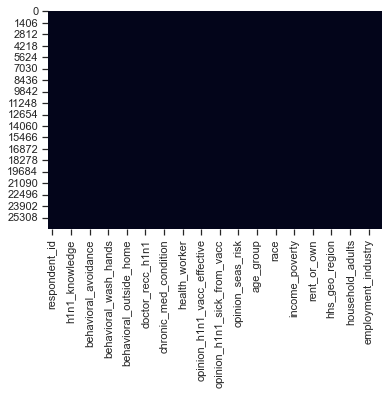

In [214]:
sns.heatmap(df_features.isnull(), cbar=False)

<AxesSubplot:>

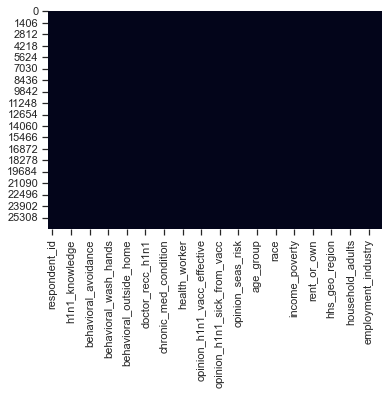

In [215]:
sns.heatmap(df_test_features.isnull(), cbar=False)

### Handling null data (method 2)

In [8]:
numerical_cols = df_features.select_dtypes('number').columns

categorical_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

ordinal_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [9]:
for col in (categorical_cols + ordinal_cols):
    df_features[col] = df_features[col].fillna(value='None')

for col in numerical_cols:
    df_features[col] = df_features[col].fillna(value=-1)

In [10]:
for col in (categorical_cols + ordinal_cols):
    df_test_features[col] = df_test_features[col].fillna(value='None')

for col in numerical_cols:
    df_test_features[col] = df_test_features[col].fillna(value=-1)

### Handling null data (method 3)

In [9]:
df_features[["employment_occupation", "employment_industry"]] = df_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")
df_test_features[["employment_occupation", "employment_industry"]] = df_test_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")

df_features[["employment_occupation", "employment_industry", "employment_status"]] .loc[(df_features["employment_status"].isna()) & ((df_features["employment_industry"]  != "xxxxx") | df_features["employment_occupation"]  != "xxxxx")].count()

df_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")
df_test_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")

In [10]:
numerical_cols = df_features.select_dtypes('number').columns

categorical_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

ordinal_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [11]:
for col in (categorical_cols + ordinal_cols):
    df_features[col] = df_features[col].fillna(value='None')

for col in numerical_cols:
    df_features[col] = df_features[col].fillna(value=-1)

In [12]:
for col in (categorical_cols + ordinal_cols):
    df_test_features[col] = df_test_features[col].fillna(value='None')

for col in numerical_cols:
    df_test_features[col] = df_test_features[col].fillna(value=-1)

## EDA

In [13]:
# delete soon
df_features.select_dtypes(include=['int64', 'float64']).columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')

In [14]:
# delete soon

df_features.select_dtypes(include=['object']).columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

Numeric

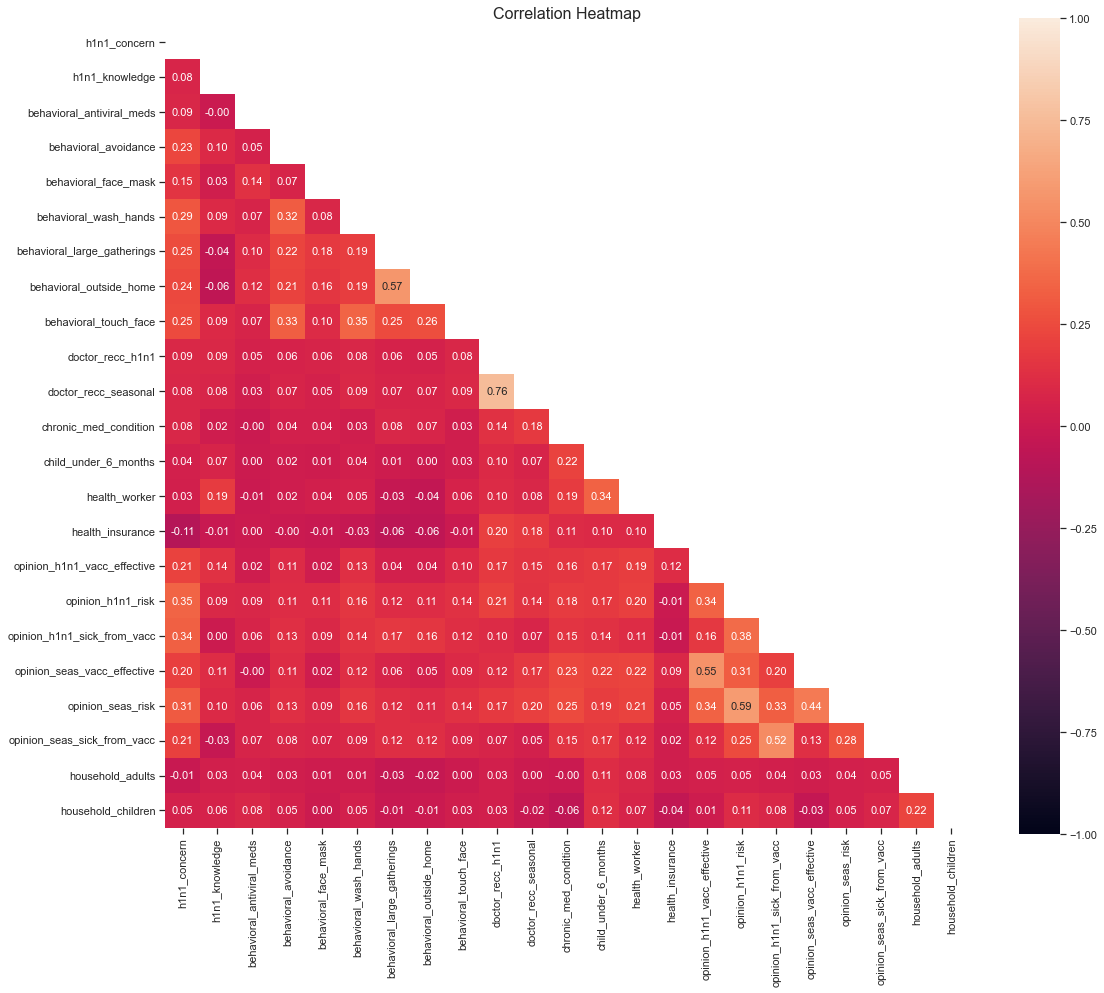

In [15]:
# correlation matrix

plt.figure(figsize=(18,15))

mask = np.triu(np.ones_like(df_features.corr(numeric_only=True), dtype=bool))
sns.heatmap(df_features.corr(), vmin=-1, vmax=1, annot=True, square=True, mask=mask, 
            fmt='.2f', annot_kws={'size':11})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Text(0, 0.5, 'Count')

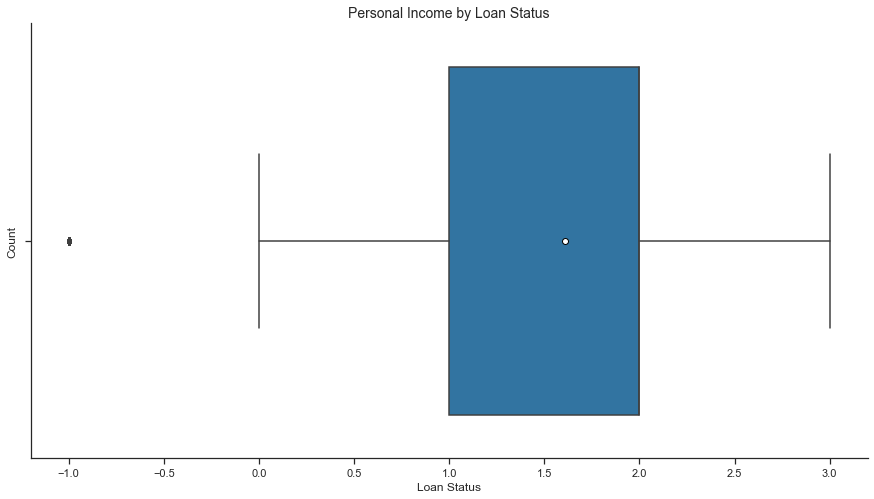

In [16]:
plt.figure(figsize=(15,8))

ax1 = sns.boxplot(data=df_features, x='h1n1_concern', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax1.set_title('Personal Income by Loan Status', fontsize=14)
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (4).

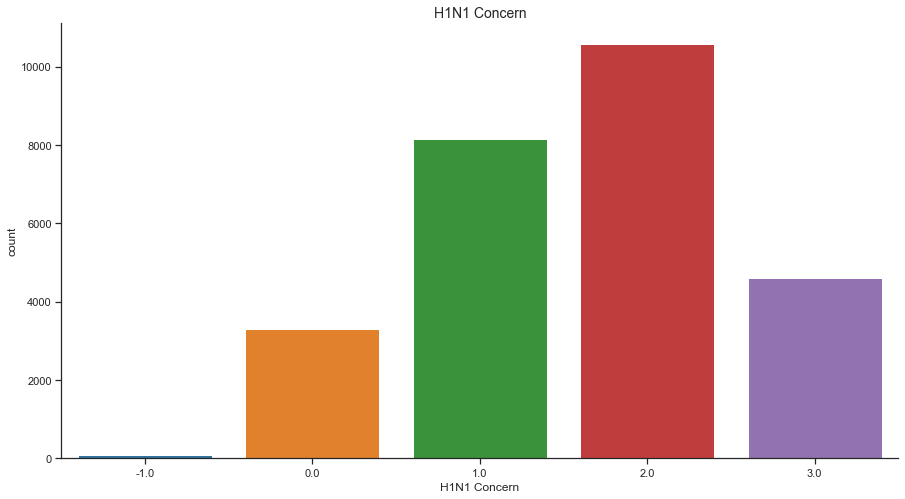

In [17]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='h1n1_concern')
ax.set_title("H1N1 Concern", fontsize=14)
ax.set_xlabel('H1N1 Concern')
ax.set_xticklabels([0,1,2,3])
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

Categorical

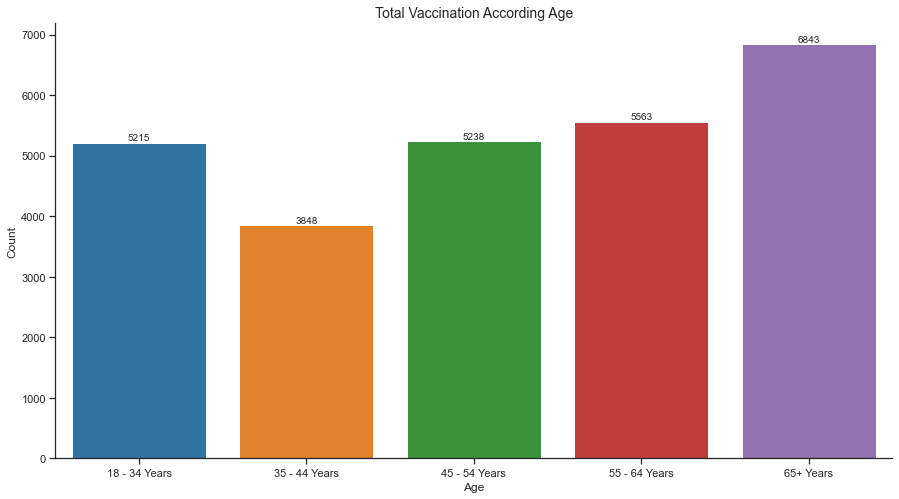

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='age_group', 
                   order=['18 - 34 Years','35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'])
ax.set_title("Total Vaccination According Age", fontsize=14)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

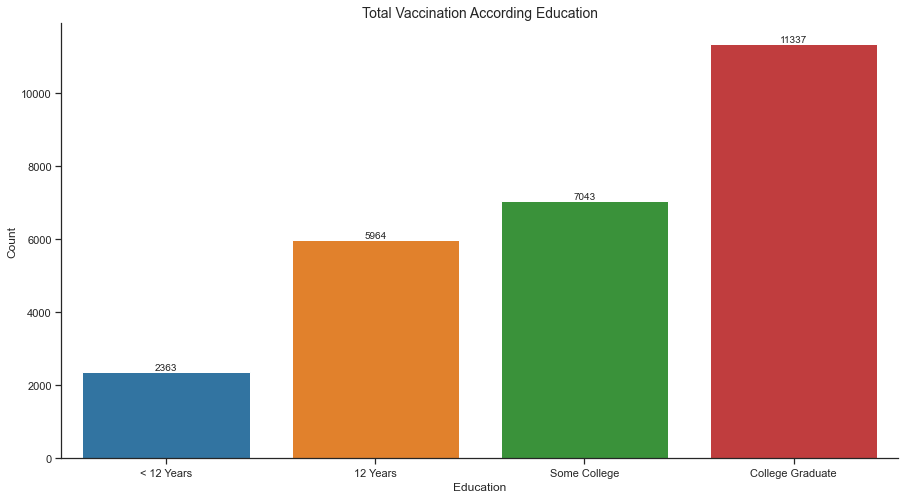

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='education',
                   order=['< 12 Years', '12 Years', 'Some College', 'College Graduate'])
ax.set_title("Total Vaccination According Education", fontsize=14)
ax.set_xlabel('Education')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

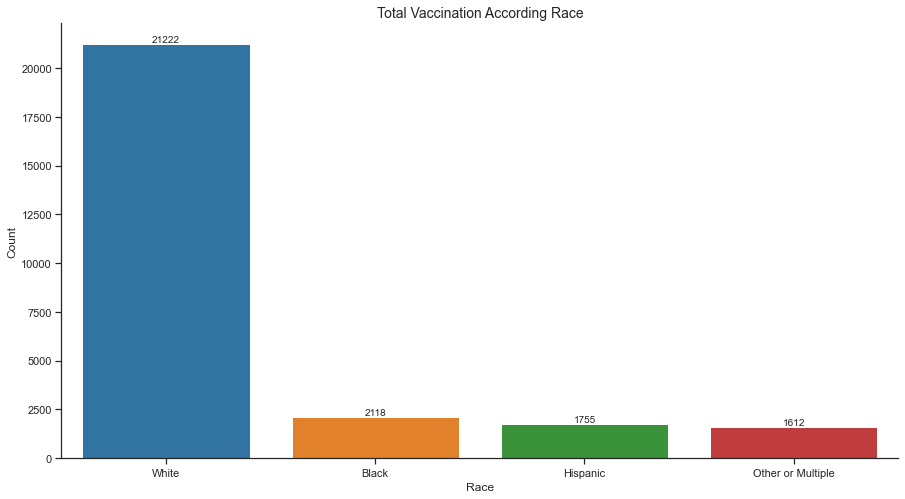

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='race', order=df_features['race'].value_counts().index)
ax.set_title("Total Vaccination According Race", fontsize=14)
ax.set_xlabel('Race')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

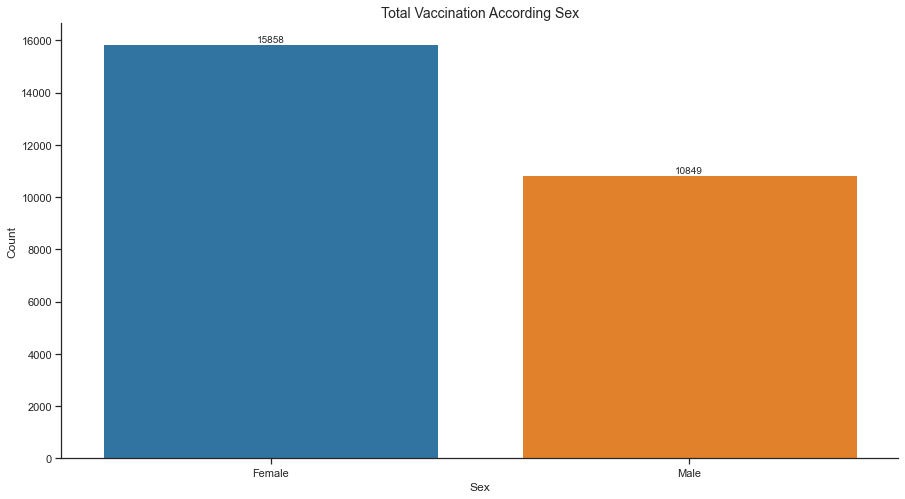

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='sex', order=df_features['sex'].value_counts().index)
ax.set_title("Total Vaccination According Sex", fontsize=14)
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

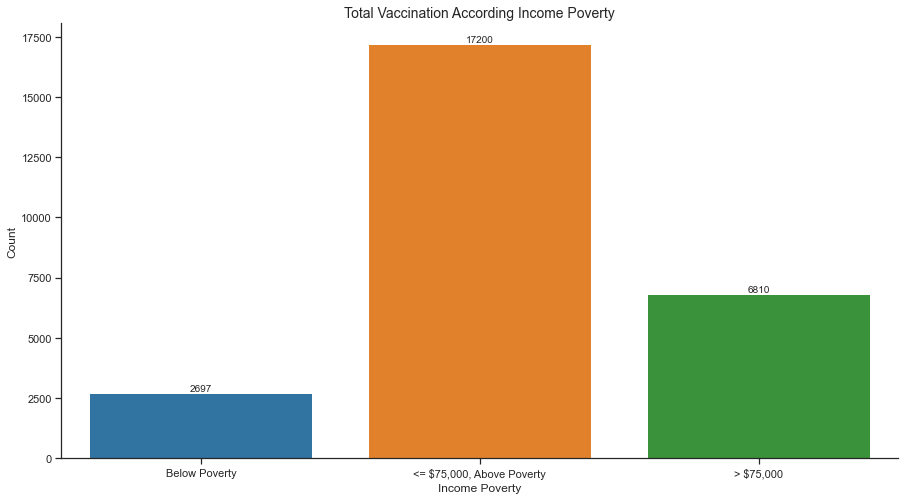

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='income_poverty', order=['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'])
ax.set_title("Total Vaccination According Income Poverty", fontsize=14)
ax.set_xlabel('Income Poverty')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

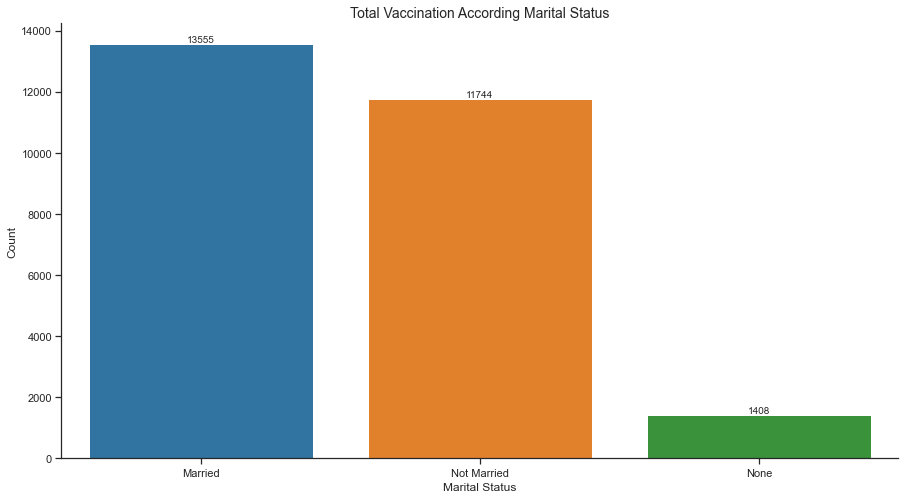

In [18]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='marital_status', order=df_features['marital_status'].value_counts().index)
ax.set_title("Total Vaccination According Marital Status", fontsize=14)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

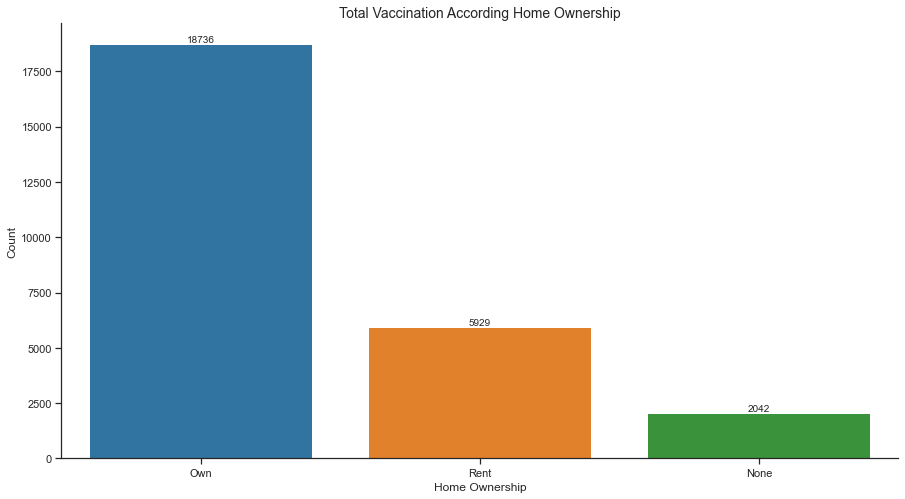

In [19]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='rent_or_own', order=df_features['rent_or_own'].value_counts().index)
ax.set_title("Total Vaccination According Home Ownership", fontsize=14)
ax.set_xlabel('Home Ownership')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

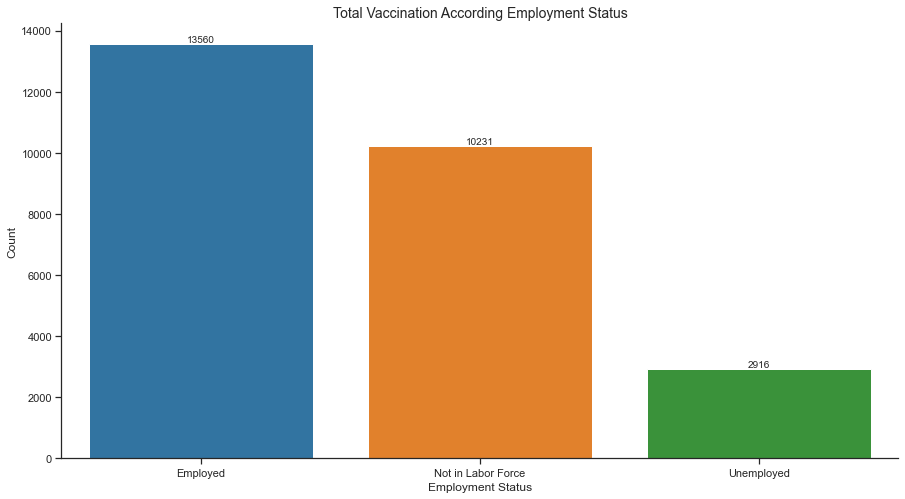

In [20]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_status', order=df_features['employment_status'].value_counts().index)
ax.set_title("Total Vaccination According Employment Status", fontsize=14)
ax.set_xlabel('Employment Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

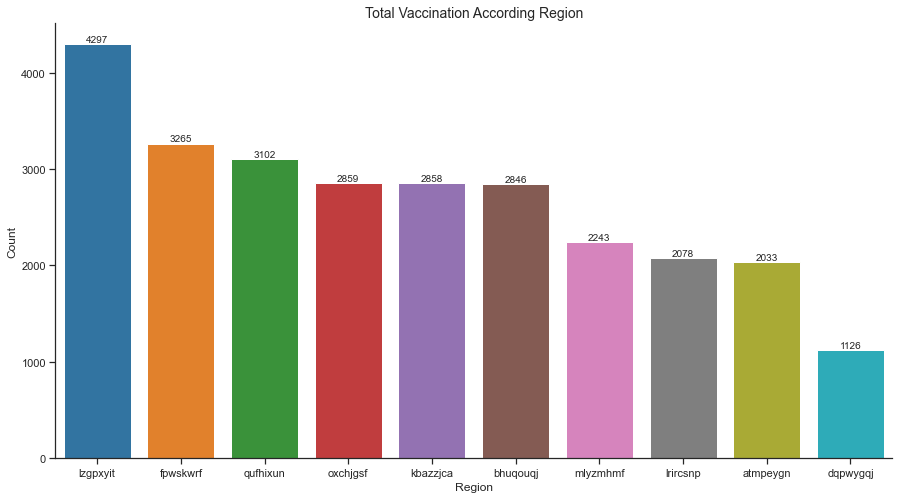

In [21]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='hhs_geo_region', order=df_features['hhs_geo_region'].value_counts().index)
ax.set_title("Total Vaccination According Region", fontsize=14)
ax.set_xlabel('Region')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

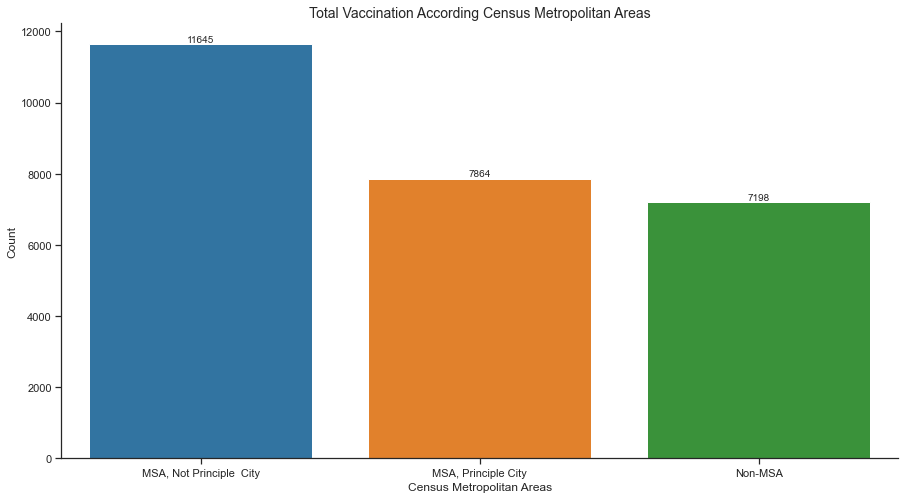

In [22]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='census_msa', order=df_features['census_msa'].value_counts().index)
ax.set_title("Total Vaccination According Census Metropolitan Areas", fontsize=14)
ax.set_xlabel('Census Metropolitan Areas')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

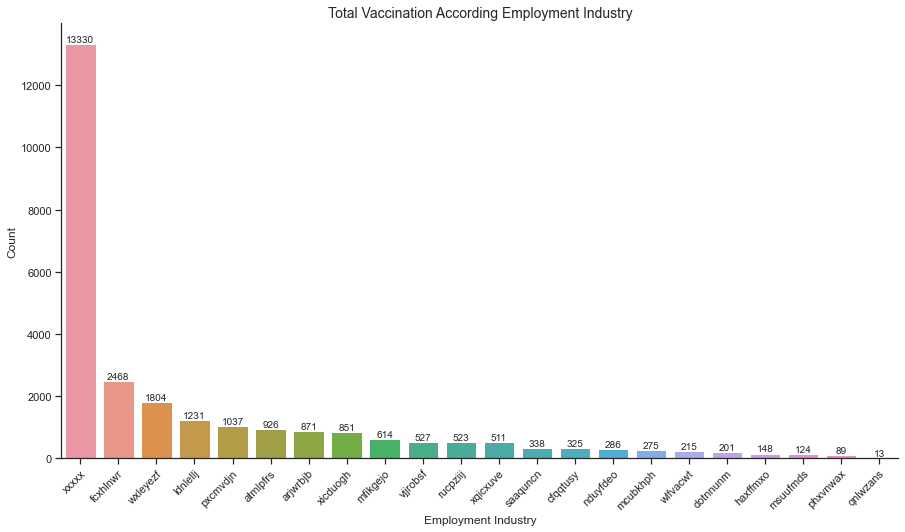

In [23]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_industry', order=df_features['employment_industry'].value_counts().index)
ax.set_title("Total Vaccination According Employment Industry", fontsize=14)
ax.set_xlabel('Employment Industry')
ax.set_xticklabels(df_features['employment_industry'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

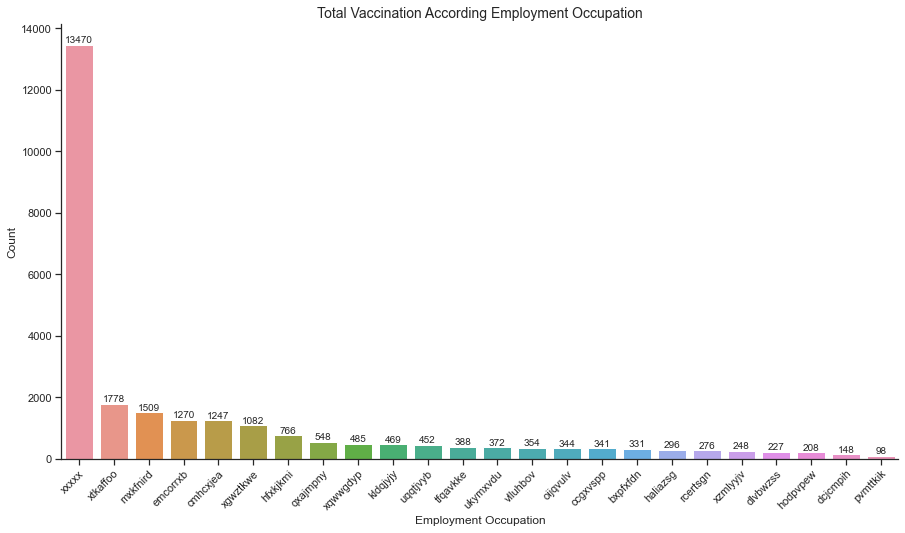

In [24]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_occupation', order=df_features['employment_occupation'].value_counts().index)
ax.set_title("Total Vaccination According Employment Occupation", fontsize=14)
ax.set_xlabel('Employment Occupation')
ax.set_xticklabels(df_features['employment_occupation'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [39]:
df_features.select_dtypes(include=['object'])

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,xxxxx,xxxxx
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",xxxxx,xxxxx
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,xxxxx,xxxxx
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,lzgpxyit,"MSA, Not Principle City",xxxxx,xxxxx
26705,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


## Modelling

### Catboost

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [74]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [75]:
sfs1 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [76]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  3.0min finished

[2023-05-02 22:05:17] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  3.2min finished

[2023-05-02 22:08:30] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  3.2min finished

[2023-05-02 22:11:40] Features: 3/35 -- score: 0.8291998687211235[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [90]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7061011369206145, 0.7118158376630549, 0.718...",0.705704,"(28,)",0.014972,0.011649,0.005824
2,"(21, 28)","[0.7817477455244676, 0.7842366891563913, 0.791...",0.785562,"(21, 28)",0.01093,0.008504,0.004252
3,"(21, 26, 28)","[0.8217985333484147, 0.8251520218065574, 0.832...",0.8292,"(21, 26, 28)",0.011063,0.008608,0.004304
4,"(21, 26, 27, 28)","[0.8435825852690462, 0.8473829905084287, 0.853...",0.849077,"(21, 26, 27, 28)",0.008616,0.006704,0.003352
5,"(10, 21, 26, 27, 28)","[0.853092556031986, 0.8552019580699758, 0.8590...",0.856325,"(10, 21, 26, 27, 28)",0.00912,0.007096,0.003548
6,"(10, 21, 25, 26, 27, 28)","[0.853809772307397, 0.857762336602776, 0.86417...",0.858863,"(10, 21, 25, 26, 27, 28)",0.008396,0.006533,0.003266
7,"(10, 21, 22, 25, 26, 27, 28)","[0.8548564624871038, 0.8609549443578358, 0.864...",0.8609,"(10, 21, 22, 25, 26, 27, 28)",0.008426,0.006556,0.003278
8,"(10, 21, 22, 25, 26, 27, 28, 30)","[0.8564329244257987, 0.8619371041076493, 0.866...",0.861915,"(10, 21, 22, 25, 26, 27, 28, 30)",0.007571,0.00589,0.002945
9,"(1, 10, 21, 22, 25, 26, 27, 28, 30)","[0.8588095066717395, 0.8627212909290303, 0.868...",0.862985,"(1, 10, 21, 22, 25, 26, 27, 28, 30)",0.006364,0.004951,0.002476
10,"(1, 10, 21, 22, 25, 26, 27, 28, 30, 31)","[0.8585747190260253, 0.8620608104348213, 0.869...",0.86344,"(1, 10, 21, 22, 25, 26, 27, 28, 30, 31)",0.007346,0.005716,0.002858


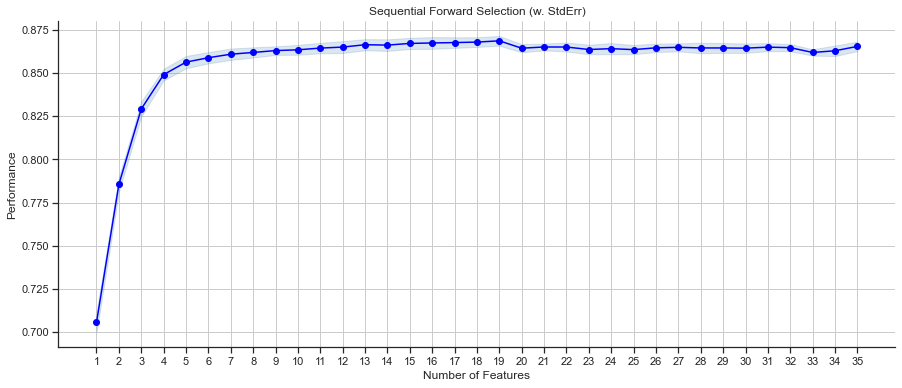

In [91]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [92]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [93]:
selected_columns_1

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_avoidance',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

##### Seasonal Flu Vaccines

In [82]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [83]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished

[2023-05-02 23:11:36] Features: 1/35 -- score: 0.7183836938438439[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  2.6min finished

[2023-05-02 23:14:12] Features: 2/35 -- score: 0.7779178245402318[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  2.4min finished

[2023-05-02 23:16:35] Features: 3/35 -- score: 0.8114257239983178[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [94]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7266282156510848, 0.7165140310424655, 0.724...",0.718384,"(31,)",0.011555,0.00899,0.004495
2,"(0, 31)","[0.7885046409441441, 0.7809378529057273, 0.788...",0.777918,"(0, 31)",0.014959,0.011638,0.005819
3,"(0, 22, 31)","[0.8249092589799938, 0.8134191377502213, 0.812...",0.811426,"(0, 22, 31)",0.011663,0.009074,0.004537
4,"(0, 22, 30, 31)","[0.8482991742653516, 0.8318889500288369, 0.838...",0.834616,"(0, 22, 30, 31)",0.011009,0.008566,0.004283
5,"(0, 10, 22, 30, 31)","[0.858806051933909, 0.8407863473473002, 0.8481...",0.844697,"(0, 10, 22, 30, 31)",0.010782,0.008389,0.004195
6,"(0, 10, 22, 30, 31, 32)","[0.8622886306941213, 0.8474972400685636, 0.852...",0.849493,"(0, 10, 22, 30, 31, 32)",0.010007,0.007785,0.003893
7,"(0, 10, 22, 26, 30, 31, 32)","[0.8636639917299906, 0.8503951680766588, 0.856...",0.852153,"(0, 10, 22, 26, 30, 31, 32)",0.01075,0.008364,0.004182
8,"(0, 10, 13, 22, 26, 30, 31, 32)","[0.865592202431042, 0.8520423492628479, 0.8594...",0.853806,"(0, 10, 13, 22, 26, 30, 31, 32)",0.010983,0.008545,0.004272
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.866819925841592, 0.8515428851327471, 0.8612...",0.855309,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.010742,0.008358,0.004179
10,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)","[0.8672024022627409, 0.8530847342119835, 0.861...",0.856469,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)",0.009631,0.007493,0.003747


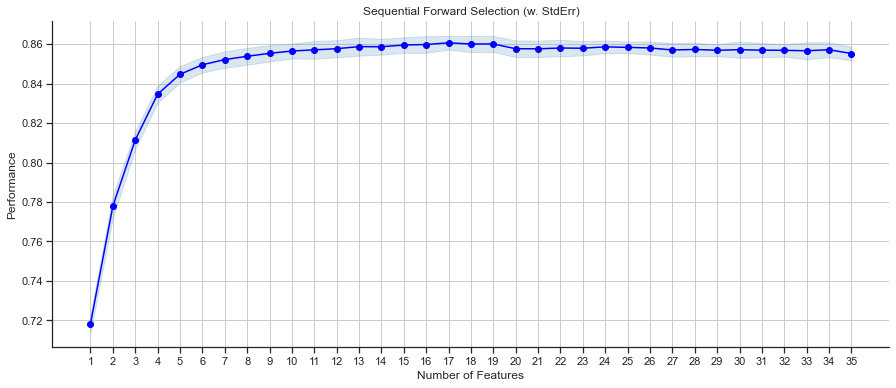

In [95]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [96]:
sfdf2['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()
selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [97]:
selected_columns_2

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_wash_hands',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'health_worker',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_occupation']

#### Model Optimization

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != float)[0]

train_dataset = Pool(data = X_train[selected_columns_1],
                     label = y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [100]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
    }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [117]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7721669453698692
  Params: 
    iterations=200,
    learning_rate=0.1933773551934663,
    random_strength=1,
    bagging_temperature=4,
    max_bin=30,
    grow_policy=Depthwise,
    min_data_in_leaf=1,
    max_depth=2,
    l2_leaf_reg=6.172494631961106e-08,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,


##### Seasonal Flu Vaccines

In [103]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != float)[0]

train_dataset_se = Pool(data = X_train[selected_columns_2],
                     label = y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [104]:
def objective2(trial):
    param = {
        'iterations' : trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate' : trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength' : trial.suggest_int("random_strength", 1,10),
        'bagging_temperature' : trial.suggest_int("bagging_temperature", 0,10),
        'max_bin' : trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function" : "Logloss",
        'auto_class_weights' : trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [ ]:
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

In [118]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7921368195574383
  Params: 
    iterations=1000,
    learning_rate=0.0495571281798243,
    random_strength=3,
    bagging_temperature=8,
    max_bin=8,
    grow_policy=Depthwise,
    min_data_in_leaf=3,
    max_depth=5,
    l2_leaf_reg=58.386263935379176,
    one_hot_max_size=1024,
    auto_class_weights=Balanced,


#### Model Optimization (using all features)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [13]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]

train_dataset = Pool(data = X_train,
                     label = y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [14]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
    }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [15]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2023-05-03 22:53:41,910] A new study created in memory with name: no-name-fc3498e9-f63a-4bed-bd04-24704a87d1d9


Training on fold [0/5]

bestTest = 0.479575293
bestIteration = 64

Training on fold [1/5]

bestTest = 0.4431561246
bestIteration = 79

Training on fold [2/5]

bestTest = 0.4567190774
bestIteration = 79

Training on fold [3/5]

bestTest = 0.4672265726
bestIteration = 69

Training on fold [4/5]

bestTest = 0.464904162
bestIteration = 71



[I 2023-05-03 22:53:52,096] Trial 0 finished with value: 0.8626614088746252 and parameters: {'iterations': 500, 'learning_rate': 0.15600697837401004, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.028437810203034e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8626614088746252.


Training on fold [0/5]

bestTest = 0.4383169109
bestIteration = 158

Training on fold [1/5]

bestTest = 0.4108928038
bestIteration = 165

Training on fold [2/5]

bestTest = 0.4163514671
bestIteration = 214

Training on fold [3/5]

bestTest = 0.4260461314
bestIteration = 135

Training on fold [4/5]

bestTest = 0.4223476665
bestIteration = 211



[I 2023-05-03 22:54:23,579] Trial 1 finished with value: 0.8669605055389902 and parameters: {'iterations': 300, 'learning_rate': 0.19229875766312626, 'random_strength': 10, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 2, 'l2_leaf_reg': 7.332581251077417e-08, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4447802045
bestIteration = 22

Training on fold [1/5]

bestTest = 0.4169234847
bestIteration = 24

Training on fold [2/5]

bestTest = 0.4285167048
bestIteration = 33

Training on fold [3/5]

bestTest = 0.4381050154
bestIteration = 22

Training on fold [4/5]

bestTest = 0.4412411413
bestIteration = 33



[I 2023-05-03 22:54:38,885] Trial 2 finished with value: 0.8593046181960421 and parameters: {'iterations': 100, 'learning_rate': 0.23904667353594525, 'random_strength': 1, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 1.0192312448477406e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4495141134
bestIteration = 42

Training on fold [1/5]

bestTest = 0.4175605511
bestIteration = 43

Training on fold [2/5]

bestTest = 0.433839343
bestIteration = 38

Training on fold [3/5]

bestTest = 0.4480339836
bestIteration = 32

Training on fold [4/5]

bestTest = 0.4347856053
bestIteration = 38



[I 2023-05-03 22:54:59,924] Trial 3 finished with value: 0.8562132608956882 and parameters: {'iterations': 100, 'learning_rate': 0.2955559025110455, 'random_strength': 9, 'bagging_temperature': 0, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 0.0405923233680353, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4381069909
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4119086721
bestIteration = 104

Training on fold [2/5]

bestTest = 0.4249724459
bestIteration = 105

Training on fold [3/5]

bestTest = 0.4308526284
bestIteration = 109

Training on fold [4/5]

bestTest = 0.4339526509
bestIteration = 98



[I 2023-05-03 22:55:15,766] Trial 4 finished with value: 0.8617684445997085 and parameters: {'iterations': 1200, 'learning_rate': 0.13547332381107027, 'random_strength': 9, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 0.005125688016017658, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4821000238
bestIteration = 66

Training on fold [1/5]

bestTest = 0.4447936194
bestIteration = 63

Training on fold [2/5]

bestTest = 0.47418959
bestIteration = 33

Training on fold [3/5]

bestTest = 0.457565478
bestIteration = 72

Training on fold [4/5]

bestTest = 0.4637884651
bestIteration = 69



[I 2023-05-03 22:55:34,611] Trial 5 finished with value: 0.8621078565507186 and parameters: {'iterations': 1000, 'learning_rate': 0.19023875669649917, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.0006017458461802345, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4373510279
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4096362311
bestIteration = 76

Training on fold [2/5]

bestTest = 0.4260331701
bestIteration = 84

Training on fold [3/5]

bestTest = 0.4393026559
bestIteration = 59

Training on fold [4/5]

bestTest = 0.4243275823
bestIteration = 91



[I 2023-05-03 22:57:19,950] Trial 6 finished with value: 0.8635195135708813 and parameters: {'iterations': 100, 'learning_rate': 0.1818962897335705, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 0.017682540913767256, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4845626707
bestIteration = 26

Training on fold [1/5]

bestTest = 0.4471222179
bestIteration = 45

Training on fold [2/5]

bestTest = 0.4634855109
bestIteration = 33

Training on fold [3/5]

bestTest = 0.4739292709
bestIteration = 29

Training on fold [4/5]

bestTest = 0.4702318948
bestIteration = 25



[I 2023-05-03 22:57:25,225] Trial 7 finished with value: 0.8586771321609463 and parameters: {'iterations': 100, 'learning_rate': 0.22839893058460567, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 0.0009334767397996896, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4949326232
bestIteration = 45

Training on fold [1/5]

bestTest = 0.4396525149
bestIteration = 54

Training on fold [2/5]

bestTest = 0.4666817319
bestIteration = 50

Training on fold [3/5]

bestTest = 0.479803119
bestIteration = 45

Training on fold [4/5]

bestTest = 0.484916756
bestIteration = 48



[I 2023-05-03 22:58:30,078] Trial 8 finished with value: 0.8555002005312236 and parameters: {'iterations': 1000, 'learning_rate': 0.2667896345591587, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 0.007620722139832508, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4724733757
bestIteration = 66

Training on fold [1/5]

bestTest = 0.4383838862
bestIteration = 73

Training on fold [2/5]

bestTest = 0.4454566064
bestIteration = 60

Training on fold [3/5]

bestTest = 0.4580881148
bestIteration = 67

Training on fold [4/5]

bestTest = 0.4627237811
bestIteration = 48



[I 2023-05-03 22:59:50,689] Trial 9 finished with value: 0.8666798562167768 and parameters: {'iterations': 200, 'learning_rate': 0.24355357877742542, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 10, 'l2_leaf_reg': 41.08476065883486, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4427031518
bestIteration = 253

Training on fold [1/5]

bestTest = 0.414487184
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4217935819
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4275492843
bestIteration = 299

Training on fold [4/5]

bestTest = 0.4289444332
bestIteration = 298



[I 2023-05-03 23:00:05,422] Trial 10 finished with value: 0.8650981491959217 and parameters: {'iterations': 300, 'learning_rate': 0.07518095681798408, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 1.354730610038692e-08, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4742039274
bestIteration = 172

Training on fold [1/5]

bestTest = 0.4398567973
bestIteration = 151

Training on fold [2/5]

bestTest = 0.4480624164
bestIteration = 163

Training on fold [3/5]

bestTest = 0.4595254455
bestIteration = 100

Training on fold [4/5]

bestTest = 0.4588621621
bestIteration = 123



[I 2023-05-03 23:00:28,507] Trial 11 finished with value: 0.8665231859951913 and parameters: {'iterations': 200, 'learning_rate': 0.22976633718792222, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 2, 'l2_leaf_reg': 76.4489926067291, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4721348747
bestIteration = 47

Training on fold [1/5]

bestTest = 0.4419729932
bestIteration = 52

Training on fold [2/5]

bestTest = 0.4540744583
bestIteration = 51

Training on fold [3/5]

bestTest = 0.4579583246
bestIteration = 50

Training on fold [4/5]

bestTest = 0.4569444777
bestIteration = 70



[I 2023-05-03 23:00:54,451] Trial 12 finished with value: 0.8660592466940887 and parameters: {'iterations': 300, 'learning_rate': 0.2974499172151603, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 74.25324015898596, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8669605055389902.


Training on fold [0/5]

bestTest = 0.4340979487
bestIteration = 580

Training on fold [1/5]

bestTest = 0.4013852999
bestIteration = 672

Training on fold [2/5]

bestTest = 0.4157120403
bestIteration = 601

Training on fold [3/5]

bestTest = 0.4218313641
bestIteration = 585

Training on fold [4/5]

bestTest = 0.4197609518
bestIteration = 660



[I 2023-05-03 23:12:52,777] Trial 13 finished with value: 0.8697025748053214 and parameters: {'iterations': 1500, 'learning_rate': 0.023168853929799726, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 0.6423752435829563, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4748876369
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4579241332
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4694014693
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4688680843
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.466833382
bestIteration = 1499



[I 2023-05-03 23:24:11,440] Trial 14 finished with value: 0.8562008657576964 and parameters: {'iterations': 1500, 'learning_rate': 0.0011594141581527106, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 1.0456412571761415e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4342983831
bestIteration = 237

Training on fold [1/5]

bestTest = 0.4057094991
bestIteration = 261

Training on fold [2/5]

bestTest = 0.4128246733
bestIteration = 244

Training on fold [3/5]

bestTest = 0.4231728347
bestIteration = 197

Training on fold [4/5]

bestTest = 0.420552832
bestIteration = 225



[I 2023-05-03 23:24:31,817] Trial 15 finished with value: 0.8691973913600035 and parameters: {'iterations': 1500, 'learning_rate': 0.10058117094016887, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 0.6669260397946728, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4346110294
bestIteration = 213

Training on fold [1/5]

bestTest = 0.402101407
bestIteration = 245

Training on fold [2/5]

bestTest = 0.4183429829
bestIteration = 223

Training on fold [3/5]

bestTest = 0.4244907984
bestIteration = 214

Training on fold [4/5]

bestTest = 0.4196287903
bestIteration = 251



[I 2023-05-03 23:25:10,579] Trial 16 finished with value: 0.868567337223471 and parameters: {'iterations': 1500, 'learning_rate': 0.06173002496486796, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 2.302897880070022, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4544192889
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4328600172
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4406928041
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4431494479
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4424487494
bestIteration = 1499



[I 2023-05-03 23:27:01,253] Trial 17 finished with value: 0.8593613960266854 and parameters: {'iterations': 1500, 'learning_rate': 0.003746790886977769, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 0.43306034152078626, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4335953074
bestIteration = 133

Training on fold [1/5]

bestTest = 0.4046242441
bestIteration = 165

Training on fold [2/5]

bestTest = 0.4160612589
bestIteration = 141

Training on fold [3/5]

bestTest = 0.4237036485
bestIteration = 143

Training on fold [4/5]

bestTest = 0.418926926
bestIteration = 155



[I 2023-05-03 23:27:26,624] Trial 18 finished with value: 0.8687324358063376 and parameters: {'iterations': 1500, 'learning_rate': 0.10060450887305959, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 1.1709248529661644, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.430397112
bestIteration = 424

Training on fold [1/5]

bestTest = 0.4052727264
bestIteration = 348

Training on fold [2/5]

bestTest = 0.4164402318
bestIteration = 417

Training on fold [3/5]

bestTest = 0.4215817539
bestIteration = 357

Training on fold [4/5]

bestTest = 0.4238756714
bestIteration = 332



[I 2023-05-03 23:28:23,415] Trial 19 finished with value: 0.8690035102979363 and parameters: {'iterations': 1500, 'learning_rate': 0.03785701625542444, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 0.18562119391556703, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4313995771
bestIteration = 182

Training on fold [1/5]

bestTest = 0.4058328783
bestIteration = 167

Training on fold [2/5]

bestTest = 0.4155633364
bestIteration = 161

Training on fold [3/5]

bestTest = 0.4208108689
bestIteration = 161

Training on fold [4/5]

bestTest = 0.420875339
bestIteration = 145



[I 2023-05-03 23:28:43,274] Trial 20 finished with value: 0.869306020596204 and parameters: {'iterations': 500, 'learning_rate': 0.1056733039051707, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 4.242309965450355, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4341518997
bestIteration = 154

Training on fold [1/5]

bestTest = 0.4057888522
bestIteration = 171

Training on fold [2/5]

bestTest = 0.4163427081
bestIteration = 196

Training on fold [3/5]

bestTest = 0.424488661
bestIteration = 152

Training on fold [4/5]

bestTest = 0.4225098067
bestIteration = 136



[I 2023-05-03 23:29:03,644] Trial 21 finished with value: 0.8681687058987402 and parameters: {'iterations': 500, 'learning_rate': 0.10758936392053418, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 4.540439540943008, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4353212464
bestIteration = 366

Training on fold [1/5]

bestTest = 0.4054938989
bestIteration = 378

Training on fold [2/5]

bestTest = 0.4136008418
bestIteration = 401

Training on fold [3/5]

bestTest = 0.4229249415
bestIteration = 357

Training on fold [4/5]

bestTest = 0.4241361189
bestIteration = 408



[I 2023-05-03 23:29:37,786] Trial 22 finished with value: 0.8689976811293201 and parameters: {'iterations': 500, 'learning_rate': 0.052527618281567094, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 3, 'l2_leaf_reg': 6.001596589008304, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4339894993
bestIteration = 181

Training on fold [1/5]

bestTest = 0.4025413967
bestIteration = 189

Training on fold [2/5]

bestTest = 0.4177413725
bestIteration = 180

Training on fold [3/5]

bestTest = 0.4241496138
bestIteration = 159

Training on fold [4/5]

bestTest = 0.4235003493
bestIteration = 145



[I 2023-05-03 23:29:57,770] Trial 23 finished with value: 0.8678173321892644 and parameters: {'iterations': 1200, 'learning_rate': 0.09877488267831802, 'random_strength': 8, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 0.16528241686616366, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4368662328
bestIteration = 271

Training on fold [1/5]

bestTest = 0.406719834
bestIteration = 395

Training on fold [2/5]

bestTest = 0.4141531605
bestIteration = 295

Training on fold [3/5]

bestTest = 0.4261770828
bestIteration = 248

Training on fold [4/5]

bestTest = 0.422257067
bestIteration = 292



[I 2023-05-03 23:30:24,490] Trial 24 finished with value: 0.8675146831921463 and parameters: {'iterations': 500, 'learning_rate': 0.0764279591734638, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 3, 'l2_leaf_reg': 9.244568946771754, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4317417794
bestIteration = 481

Training on fold [1/5]

bestTest = 0.4038791554
bestIteration = 449

Training on fold [2/5]

bestTest = 0.4162399108
bestIteration = 441

Training on fold [3/5]

bestTest = 0.4225488611
bestIteration = 465

Training on fold [4/5]

bestTest = 0.4213976151
bestIteration = 457



[I 2023-05-03 23:31:32,596] Trial 25 finished with value: 0.8693226086004421 and parameters: {'iterations': 1500, 'learning_rate': 0.03199847441897219, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.5941359355841551, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8697025748053214.


Training on fold [0/5]

bestTest = 0.4316436215
bestIteration = 666

Training on fold [1/5]

bestTest = 0.4032924384
bestIteration = 629

Training on fold [2/5]

bestTest = 0.4129846739
bestIteration = 641

Training on fold [3/5]

bestTest = 0.4225072296
bestIteration = 606

Training on fold [4/5]

bestTest = 0.4196975727
bestIteration = 618



[I 2023-05-03 23:32:51,691] Trial 26 finished with value: 0.8703514161598858 and parameters: {'iterations': 1500, 'learning_rate': 0.02316436488889992, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 14.828143297443527, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 26 with value: 0.8703514161598858.


Training on fold [0/5]

bestTest = 0.4325292336
bestIteration = 540

Training on fold [1/5]

bestTest = 0.4024404957
bestIteration = 538

Training on fold [2/5]

bestTest = 0.4138927766
bestIteration = 552

Training on fold [3/5]

bestTest = 0.4205257258
bestIteration = 511

Training on fold [4/5]

bestTest = 0.4196130661
bestIteration = 528



[I 2023-05-03 23:34:00,405] Trial 27 finished with value: 0.8704739603213772 and parameters: {'iterations': 1500, 'learning_rate': 0.02749080456719725, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 20.58656927405245, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 27 with value: 0.8704739603213772.


Training on fold [0/5]

bestTest = 0.4303964018
bestIteration = 707

Training on fold [1/5]

bestTest = 0.402161144
bestIteration = 705

Training on fold [2/5]

bestTest = 0.4133644519
bestIteration = 732

Training on fold [3/5]

bestTest = 0.421336242
bestIteration = 640

Training on fold [4/5]

bestTest = 0.4191999784
bestIteration = 724



[I 2023-05-03 23:35:29,745] Trial 28 finished with value: 0.8708433113644553 and parameters: {'iterations': 1500, 'learning_rate': 0.020917849073951982, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 15.454852967506062, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.8708433113644553.


Training on fold [0/5]

bestTest = 0.4311884178
bestIteration = 469

Training on fold [1/5]

bestTest = 0.4033524117
bestIteration = 452

Training on fold [2/5]

bestTest = 0.4132624791
bestIteration = 478

Training on fold [3/5]

bestTest = 0.4193543322
bestIteration = 434

Training on fold [4/5]

bestTest = 0.4182111101
bestIteration = 433



[I 2023-05-03 23:36:29,626] Trial 29 finished with value: 0.8708353948986559 and parameters: {'iterations': 1500, 'learning_rate': 0.03285207060464862, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 18.502170423292327, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.8708433113644553.


Training on fold [0/5]

bestTest = 0.4328190674
bestIteration = 252

Training on fold [1/5]

bestTest = 0.4016761501
bestIteration = 246

Training on fold [2/5]

bestTest = 0.4152848209
bestIteration = 298

Training on fold [3/5]

bestTest = 0.4221602788
bestIteration = 256

Training on fold [4/5]

bestTest = 0.4201453211
bestIteration = 224



[I 2023-05-03 23:37:05,472] Trial 30 finished with value: 0.8701470330178862 and parameters: {'iterations': 1500, 'learning_rate': 0.04861929664505757, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 15.316959541764236, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.8708433113644553.


Training on fold [0/5]

bestTest = 0.4313682577
bestIteration = 1260

Training on fold [1/5]

bestTest = 0.4024362187
bestIteration = 1374

Training on fold [2/5]

bestTest = 0.4130934197
bestIteration = 1349

Training on fold [3/5]

bestTest = 0.4216683767
bestIteration = 1239

Training on fold [4/5]

bestTest = 0.4182921076
bestIteration = 1309



[I 2023-05-03 23:39:48,353] Trial 31 finished with value: 0.8708206083271521 and parameters: {'iterations': 1500, 'learning_rate': 0.01103719950258506, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 20.848518525731915, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.8708433113644553.


Training on fold [0/5]

bestTest = 0.4310772962
bestIteration = 1122

Training on fold [1/5]

bestTest = 0.403113339
bestIteration = 1105

Training on fold [2/5]

bestTest = 0.413032679
bestIteration = 1145

Training on fold [3/5]

bestTest = 0.4205531688
bestIteration = 1073

Training on fold [4/5]

bestTest = 0.4191862067
bestIteration = 1099



[I 2023-05-03 23:42:15,772] Trial 32 finished with value: 0.8710488234628724 and parameters: {'iterations': 1500, 'learning_rate': 0.013036806524709744, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 27.109941042422268, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 32 with value: 0.8710488234628724.


Training on fold [0/5]

bestTest = 0.4315767875
bestIteration = 1418

Training on fold [1/5]

bestTest = 0.4031168972
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4129598493
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4212447623
bestIteration = 1449

Training on fold [4/5]

bestTest = 0.4191819558
bestIteration = 1482



[I 2023-05-03 23:44:57,650] Trial 33 finished with value: 0.8706372115621791 and parameters: {'iterations': 1500, 'learning_rate': 0.009871137481001692, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 54.644809195877414, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 32 with value: 0.8710488234628724.


Training on fold [0/5]

bestTest = 0.4322972816
bestIteration = 782

Training on fold [1/5]

bestTest = 0.4049221119
bestIteration = 829

Training on fold [2/5]

bestTest = 0.4121782326
bestIteration = 959

Training on fold [3/5]

bestTest = 0.421579685
bestIteration = 774

Training on fold [4/5]

bestTest = 0.4202080312
bestIteration = 776



[I 2023-05-03 23:46:43,566] Trial 34 finished with value: 0.8702992485512704 and parameters: {'iterations': 1500, 'learning_rate': 0.018941912761142675, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 87.23992488883262, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 32 with value: 0.8710488234628724.


Training on fold [0/5]

bestTest = 0.4337356964
bestIteration = 340

Training on fold [1/5]

bestTest = 0.4021863586
bestIteration = 369

Training on fold [2/5]

bestTest = 0.4152429402
bestIteration = 379

Training on fold [3/5]

bestTest = 0.4224709129
bestIteration = 348

Training on fold [4/5]

bestTest = 0.4185955355
bestIteration = 344



[I 2023-05-03 23:47:37,138] Trial 35 finished with value: 0.8696861312372061 and parameters: {'iterations': 1200, 'learning_rate': 0.04105528308088659, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 2.528491943427646, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 32 with value: 0.8710488234628724.


Training on fold [0/5]

bestTest = 0.4306714138
bestIteration = 933

Training on fold [1/5]

bestTest = 0.4010413006
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4132253147
bestIteration = 996

Training on fold [3/5]

bestTest = 0.4202445638
bestIteration = 880

Training on fold [4/5]

bestTest = 0.4190792501
bestIteration = 899



[I 2023-05-03 23:49:20,660] Trial 36 finished with value: 0.871252853864655 and parameters: {'iterations': 1000, 'learning_rate': 0.014939102213625979, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 14.213388521513, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4338631304
bestIteration = 238

Training on fold [1/5]

bestTest = 0.4014144412
bestIteration = 336

Training on fold [2/5]

bestTest = 0.4223258479
bestIteration = 257

Training on fold [3/5]

bestTest = 0.4279495067
bestIteration = 219

Training on fold [4/5]

bestTest = 0.4212765657
bestIteration = 306



[I 2023-05-03 23:52:20,210] Trial 37 finished with value: 0.8680378160759826 and parameters: {'iterations': 1000, 'learning_rate': 0.03911639312303836, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 6.719956071978472, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4797532359
bestIteration = 385

Training on fold [1/5]

bestTest = 0.4389004236
bestIteration = 677

Training on fold [2/5]

bestTest = 0.45583132
bestIteration = 540

Training on fold [3/5]

bestTest = 0.4593613608
bestIteration = 522

Training on fold [4/5]

bestTest = 0.4551220454
bestIteration = 666



[I 2023-05-03 23:53:15,004] Trial 38 finished with value: 0.8664416530085157 and parameters: {'iterations': 1000, 'learning_rate': 0.018257303184211402, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.07481853418286817, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4381107284
bestIteration = 130

Training on fold [1/5]

bestTest = 0.4043945927
bestIteration = 197

Training on fold [2/5]

bestTest = 0.4206401163
bestIteration = 160

Training on fold [3/5]

bestTest = 0.4287772579
bestIteration = 112

Training on fold [4/5]

bestTest = 0.4250757901
bestIteration = 131



[I 2023-05-03 23:53:57,028] Trial 39 finished with value: 0.8670524883875345 and parameters: {'iterations': 1000, 'learning_rate': 0.059606969639212005, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 2.271074504557397, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4777924006
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4643619942
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4695372539
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4715742793
bestIteration = 999

Training on fold [4/5]

bestTest = 0.4697710411
bestIteration = 999



[I 2023-05-04 00:00:06,966] Trial 40 finished with value: 0.8588771119177008 and parameters: {'iterations': 1000, 'learning_rate': 0.0011890474985799503, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 19.80378307740005, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4630971424
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4461778882
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4528421988
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4554488772
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4534749463
bestIteration = 199



[I 2023-05-04 00:00:36,158] Trial 41 finished with value: 0.8589083857311323 and parameters: {'iterations': 200, 'learning_rate': 0.014315395604515748, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 23.95434800061156, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4546965566
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4322683635
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4403432341
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4444092363
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4396958743
bestIteration = 99



[I 2023-05-04 00:00:56,473] Trial 42 finished with value: 0.8613599459802058 and parameters: {'iterations': 100, 'learning_rate': 0.035776793720454204, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 27.86939475747989, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4564084684
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4361185952
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4427347541
bestIteration = 299

Training on fold [3/5]

bestTest = 0.445857963
bestIteration = 299

Training on fold [4/5]

bestTest = 0.4456724144
bestIteration = 299



[I 2023-05-04 00:01:22,193] Trial 43 finished with value: 0.8591057341285623 and parameters: {'iterations': 300, 'learning_rate': 0.01588616599662749, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 1.694632472597253, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4707025803
bestIteration = 274

Training on fold [1/5]

bestTest = 0.4354930463
bestIteration = 293

Training on fold [2/5]

bestTest = 0.4502004299
bestIteration = 270

Training on fold [3/5]

bestTest = 0.4555581502
bestIteration = 286

Training on fold [4/5]

bestTest = 0.4550348101
bestIteration = 279



[I 2023-05-04 00:02:06,307] Trial 44 finished with value: 0.8685452405969214 and parameters: {'iterations': 1500, 'learning_rate': 0.04834525111612689, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 6.161119240723583, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4317938596
bestIteration = 470

Training on fold [1/5]

bestTest = 0.4022466506
bestIteration = 529

Training on fold [2/5]

bestTest = 0.4148650909
bestIteration = 440

Training on fold [3/5]

bestTest = 0.4203089538
bestIteration = 467

Training on fold [4/5]

bestTest = 0.4193575606
bestIteration = 494



[I 2023-05-04 00:13:48,699] Trial 45 finished with value: 0.8705826605290812 and parameters: {'iterations': 1000, 'learning_rate': 0.03233378277095225, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 89.2987053705751, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.5144835919
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5051467996
bestIteration = 99

Training on fold [2/5]

bestTest = 0.510730947
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5084200005
bestIteration = 99

Training on fold [4/5]

bestTest = 0.5107219755
bestIteration = 99



[I 2023-05-04 00:14:09,966] Trial 46 finished with value: 0.8541983095049579 and parameters: {'iterations': 100, 'learning_rate': 0.009399495045854137, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 30.409106293853075, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4755793449
bestIteration = 187

Training on fold [1/5]

bestTest = 0.4383843825
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4670009932
bestIteration = 124

Training on fold [3/5]

bestTest = 0.4606320325
bestIteration = 176

Training on fold [4/5]

bestTest = 0.4651703253
bestIteration = 197



[I 2023-05-04 00:14:32,743] Trial 47 finished with value: 0.863816977376144 and parameters: {'iterations': 200, 'learning_rate': 0.06960216312562602, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 0.01630397701545314, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.432883915
bestIteration = 582

Training on fold [1/5]

bestTest = 0.4014412504
bestIteration = 598

Training on fold [2/5]

bestTest = 0.4154436254
bestIteration = 556

Training on fold [3/5]

bestTest = 0.4234266422
bestIteration = 532

Training on fold [4/5]

bestTest = 0.4197299198
bestIteration = 578



[I 2023-05-04 00:26:29,321] Trial 48 finished with value: 0.8696588603577216 and parameters: {'iterations': 1500, 'learning_rate': 0.02606057867187598, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 7.595624519914786, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4539686577
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4336955874
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4406525432
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4429670972
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.4416470791
bestIteration = 1199



[I 2023-05-04 00:28:18,154] Trial 49 finished with value: 0.8606375090069778 and parameters: {'iterations': 1200, 'learning_rate': 0.004075111082540965, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 92.96102014723597, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4332349366
bestIteration = 251

Training on fold [1/5]

bestTest = 0.4040261694
bestIteration = 261

Training on fold [2/5]

bestTest = 0.4140527691
bestIteration = 265

Training on fold [3/5]

bestTest = 0.4210677648
bestIteration = 246

Training on fold [4/5]

bestTest = 0.4178810949
bestIteration = 267



[I 2023-05-04 00:28:44,092] Trial 50 finished with value: 0.8701615172896572 and parameters: {'iterations': 300, 'learning_rate': 0.05420047737612772, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 1.8682463866262522, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4315435857
bestIteration = 952

Training on fold [1/5]

bestTest = 0.4024162731
bestIteration = 1144

Training on fold [2/5]

bestTest = 0.4130367417
bestIteration = 1040

Training on fold [3/5]

bestTest = 0.4200965444
bestIteration = 1016

Training on fold [4/5]

bestTest = 0.417576519
bestIteration = 1031



[I 2023-05-04 00:30:17,989] Trial 51 finished with value: 0.8711170064453656 and parameters: {'iterations': 1500, 'learning_rate': 0.014237445388801126, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 42.71676780757178, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4313789316
bestIteration = 855

Training on fold [1/5]

bestTest = 0.4015678338
bestIteration = 915

Training on fold [2/5]

bestTest = 0.4130174007
bestIteration = 886

Training on fold [3/5]

bestTest = 0.4199874329
bestIteration = 827

Training on fold [4/5]

bestTest = 0.4196891587
bestIteration = 859



[I 2023-05-04 00:31:39,491] Trial 52 finished with value: 0.870870086072828 and parameters: {'iterations': 1500, 'learning_rate': 0.017065216297185385, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 36.34636667371757, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4321831224
bestIteration = 520

Training on fold [1/5]

bestTest = 0.4021330654
bestIteration = 540

Training on fold [2/5]

bestTest = 0.4132485337
bestIteration = 523

Training on fold [3/5]

bestTest = 0.420252395
bestIteration = 533

Training on fold [4/5]

bestTest = 0.4187014157
bestIteration = 526



[I 2023-05-04 00:32:28,916] Trial 53 finished with value: 0.8708262205911572 and parameters: {'iterations': 1500, 'learning_rate': 0.02763182089111954, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 41.91718112417119, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4312331448
bestIteration = 331

Training on fold [1/5]

bestTest = 0.4022950025
bestIteration = 340

Training on fold [2/5]

bestTest = 0.4152644037
bestIteration = 340

Training on fold [3/5]

bestTest = 0.4204669853
bestIteration = 327

Training on fold [4/5]

bestTest = 0.419650275
bestIteration = 350



[I 2023-05-04 00:33:02,648] Trial 54 finished with value: 0.8702875783238456 and parameters: {'iterations': 1500, 'learning_rate': 0.04481783707659395, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 10.778068361145646, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4682638692
bestIteration = 634

Training on fold [1/5]

bestTest = 0.4348730535
bestIteration = 661

Training on fold [2/5]

bestTest = 0.449976423
bestIteration = 639

Training on fold [3/5]

bestTest = 0.4522739018
bestIteration = 710

Training on fold [4/5]

bestTest = 0.4502534539
bestIteration = 665



[I 2023-05-04 00:33:50,107] Trial 55 finished with value: 0.8704575781528391 and parameters: {'iterations': 1500, 'learning_rate': 0.02132100166102477, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 41.12494455390504, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4568490193
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4368466646
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.444567135
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4463454733
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4449150863
bestIteration = 1499



[I 2023-05-04 00:35:57,699] Trial 56 finished with value: 0.8600734543969292 and parameters: {'iterations': 1500, 'learning_rate': 0.002484041264185643, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 1.0501258195793346, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4314686495
bestIteration = 378

Training on fold [1/5]

bestTest = 0.4049329005
bestIteration = 365

Training on fold [2/5]

bestTest = 0.4143374502
bestIteration = 369

Training on fold [3/5]

bestTest = 0.421636138
bestIteration = 357

Training on fold [4/5]

bestTest = 0.4203985542
bestIteration = 370



[I 2023-05-04 00:40:39,346] Trial 57 finished with value: 0.8698961362999393 and parameters: {'iterations': 1500, 'learning_rate': 0.03732750824540644, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 3.465830202662602, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4346906361
bestIteration = 194

Training on fold [1/5]

bestTest = 0.4022151974
bestIteration = 267

Training on fold [2/5]

bestTest = 0.4119527198
bestIteration = 206

Training on fold [3/5]

bestTest = 0.4229997106
bestIteration = 231

Training on fold [4/5]

bestTest = 0.420590133
bestIteration = 203



[I 2023-05-04 00:43:24,115] Trial 58 finished with value: 0.8695375284679541 and parameters: {'iterations': 1000, 'learning_rate': 0.06805876871685039, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 11.969618273080867, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4358343736
bestIteration = 565

Training on fold [1/5]

bestTest = 0.4011466376
bestIteration = 842

Training on fold [2/5]

bestTest = 0.4162657163
bestIteration = 843

Training on fold [3/5]

bestTest = 0.4228799938
bestIteration = 792

Training on fold [4/5]

bestTest = 0.4187701039
bestIteration = 785



[I 2023-05-04 00:44:55,651] Trial 59 finished with value: 0.8695110200225692 and parameters: {'iterations': 1500, 'learning_rate': 0.015208622008110515, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 4.776913007566357, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4673438143
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4507569185
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4607229894
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4607970322
bestIteration = 99

Training on fold [4/5]

bestTest = 0.45947463
bestIteration = 99



[I 2023-05-04 00:46:11,428] Trial 60 finished with value: 0.8579387207236984 and parameters: {'iterations': 100, 'learning_rate': 0.029753360906633643, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 0.2577530036579154, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4309627798
bestIteration = 576

Training on fold [1/5]

bestTest = 0.4024907531
bestIteration = 592

Training on fold [2/5]

bestTest = 0.4134021977
bestIteration = 514

Training on fold [3/5]

bestTest = 0.4218682498
bestIteration = 533

Training on fold [4/5]


[I 2023-05-04 00:47:04,026] Trial 61 finished with value: 0.8709161014877116 and parameters: {'iterations': 1500, 'learning_rate': 0.026754916578539185, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 43.48541060477251, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.



bestTest = 0.4189669281
bestIteration = 535

Training on fold [0/5]

bestTest = 0.4313940722
bestIteration = 341

Training on fold [1/5]

bestTest = 0.4023536223
bestIteration = 363

Training on fold [2/5]

bestTest = 0.4144188587
bestIteration = 359

Training on fold [3/5]

bestTest = 0.4206043706
bestIteration = 318

Training on fold [4/5]

bestTest = 0.4188115756
bestIteration = 328



[I 2023-05-04 00:47:38,013] Trial 62 finished with value: 0.8707275564311285 and parameters: {'iterations': 1500, 'learning_rate': 0.04507272043408243, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 46.492371601877686, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4322578101
bestIteration = 651

Training on fold [1/5]

bestTest = 0.4021036111
bestIteration = 657

Training on fold [2/5]

bestTest = 0.4134893729
bestIteration = 645

Training on fold [3/5]

bestTest = 0.4211902685
bestIteration = 600

Training on fold [4/5]

bestTest = 0.419340639
bestIteration = 602



[I 2023-05-04 00:48:37,959] Trial 63 finished with value: 0.8706916925936424 and parameters: {'iterations': 1500, 'learning_rate': 0.022214614920778364, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 13.581981729015157, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4316643429
bestIteration = 1415

Training on fold [1/5]

bestTest = 0.4023286462
bestIteration = 1492

Training on fold [2/5]

bestTest = 0.4135195317
bestIteration = 1405

Training on fold [3/5]

bestTest = 0.4203697752
bestIteration = 1349

Training on fold [4/5]

bestTest = 0.4185700601
bestIteration = 1325



[I 2023-05-04 00:50:40,433] Trial 64 finished with value: 0.871032556576326 and parameters: {'iterations': 1500, 'learning_rate': 0.010566641154714156, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 39.53930918419203, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4338477902
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4066429598
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4157808656
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4227460142
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4214809003
bestIteration = 1499



[I 2023-05-04 00:52:54,001] Trial 65 finished with value: 0.8695809522151483 and parameters: {'iterations': 1500, 'learning_rate': 0.008726635875312907, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 91.10723671301221, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4663525011
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4493289098
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4558449693
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4561704817
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4557503525
bestIteration = 199



[I 2023-05-04 00:53:12,515] Trial 66 finished with value: 0.8576922221124329 and parameters: {'iterations': 200, 'learning_rate': 0.01240658765514419, 'random_strength': 4, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 37.56166955256368, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4341677915
bestIteration = 260

Training on fold [1/5]

bestTest = 0.4042249711
bestIteration = 288

Training on fold [2/5]

bestTest = 0.4148568954
bestIteration = 269

Training on fold [3/5]

bestTest = 0.4242369882
bestIteration = 278

Training on fold [4/5]


[I 2023-05-04 00:53:38,793] Trial 67 finished with value: 0.8687633935978688 and parameters: {'iterations': 1500, 'learning_rate': 0.05275772173700759, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 3.80425923240234, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.



bestTest = 0.4209877758
bestIteration = 256

Training on fold [0/5]

bestTest = 0.4428141233
bestIteration = 298

Training on fold [1/5]

bestTest = 0.4165961434
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4262719484
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4324616655
bestIteration = 299

Training on fold [4/5]

bestTest = 0.4293773085
bestIteration = 299



[I 2023-05-04 00:54:48,753] Trial 68 finished with value: 0.8646029928892176 and parameters: {'iterations': 300, 'learning_rate': 0.025280506138668613, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 1.1066632301557924, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4711272445
bestIteration = 350

Training on fold [1/5]

bestTest = 0.4337158997
bestIteration = 349

Training on fold [2/5]

bestTest = 0.4506782631
bestIteration = 316

Training on fold [3/5]

bestTest = 0.4547059005
bestIteration = 331

Training on fold [4/5]

bestTest = 0.4551348669
bestIteration = 316



[I 2023-05-04 00:55:20,877] Trial 69 finished with value: 0.8690797857680875 and parameters: {'iterations': 1200, 'learning_rate': 0.04252768309015322, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 9.44108265334499, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4747085082
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4597373679
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4677300938
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4665861092
bestIteration = 499

Training on fold [4/5]

bestTest = 0.4661950596
bestIteration = 499



[I 2023-05-04 00:56:02,854] Trial 70 finished with value: 0.8564741499994188 and parameters: {'iterations': 500, 'learning_rate': 0.004432916664043118, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 53.34604942397961, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4311800083
bestIteration = 510

Training on fold [1/5]

bestTest = 0.4027307296
bestIteration = 482

Training on fold [2/5]

bestTest = 0.4147012896
bestIteration = 475

Training on fold [3/5]

bestTest = 0.4196531655
bestIteration = 452

Training on fold [4/5]

bestTest = 0.4185624007
bestIteration = 473



[I 2023-05-04 00:56:47,932] Trial 71 finished with value: 0.8707455592919219 and parameters: {'iterations': 1500, 'learning_rate': 0.031391421404038375, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 19.341569089598817, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4311625408
bestIteration = 772

Training on fold [1/5]

bestTest = 0.4018981865
bestIteration = 868

Training on fold [2/5]

bestTest = 0.4138446008
bestIteration = 758

Training on fold [3/5]

bestTest = 0.4209092226
bestIteration = 749

Training on fold [4/5]

bestTest = 0.4201876837
bestIteration = 743



[I 2023-05-04 00:57:57,786] Trial 72 finished with value: 0.8704990475459786 and parameters: {'iterations': 1500, 'learning_rate': 0.018951682034372697, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 10.575868513815696, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4319425157
bestIteration = 401

Training on fold [1/5]

bestTest = 0.4009973165
bestIteration = 457

Training on fold [2/5]

bestTest = 0.4136084734
bestIteration = 387

Training on fold [3/5]

bestTest = 0.4212648657
bestIteration = 386

Training on fold [4/5]

bestTest = 0.4184338359
bestIteration = 410



[I 2023-05-04 00:58:36,294] Trial 73 finished with value: 0.8708950386611567 and parameters: {'iterations': 1500, 'learning_rate': 0.0367004636559433, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 27.09526572921025, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4321469267
bestIteration = 775

Training on fold [1/5]

bestTest = 0.4022502338
bestIteration = 916

Training on fold [2/5]

bestTest = 0.4115957207
bestIteration = 856

Training on fold [3/5]

bestTest = 0.4210545141
bestIteration = 777

Training on fold [4/5]

bestTest = 0.4189758472
bestIteration = 894



[I 2023-05-04 00:59:53,657] Trial 74 finished with value: 0.8710276113943147 and parameters: {'iterations': 1500, 'learning_rate': 0.0176428162927333, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 36.1172914908248, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4708061008
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4538477402
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4611710168
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4614230942
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4605097281
bestIteration = 1499



[I 2023-05-04 01:02:07,180] Trial 75 finished with value: 0.85603978186311 and parameters: {'iterations': 1500, 'learning_rate': 0.0018426462374467462, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 9, 'l2_leaf_reg': 47.77884949941564, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4309190029
bestIteration = 422

Training on fold [1/5]

bestTest = 0.4011985875
bestIteration = 414

Training on fold [2/5]

bestTest = 0.4132431027
bestIteration = 387

Training on fold [3/5]

bestTest = 0.4209430824
bestIteration = 392

Training on fold [4/5]

bestTest = 0.418092309
bestIteration = 368



[I 2023-05-04 01:02:45,288] Trial 76 finished with value: 0.8711070103584033 and parameters: {'iterations': 1500, 'learning_rate': 0.037513323555943785, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 30.14994024879373, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4343800482
bestIteration = 187

Training on fold [1/5]

bestTest = 0.4018308328
bestIteration = 221

Training on fold [2/5]

bestTest = 0.4198581466
bestIteration = 198

Training on fold [3/5]

bestTest = 0.4234339105
bestIteration = 200

Training on fold [4/5]

bestTest = 0.4182513764
bestIteration = 201



[I 2023-05-04 01:03:55,984] Trial 77 finished with value: 0.8687522539983856 and parameters: {'iterations': 1000, 'learning_rate': 0.05842388093792392, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 5.470964680024376, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4325790563
bestIteration = 416

Training on fold [1/5]

bestTest = 0.4029310186
bestIteration = 509

Training on fold [2/5]

bestTest = 0.414889941
bestIteration = 393

Training on fold [3/5]

bestTest = 0.4195590517
bestIteration = 391

Training on fold [4/5]

bestTest = 0.4180619127
bestIteration = 409



[I 2023-05-04 01:04:37,825] Trial 78 finished with value: 0.8706571287308522 and parameters: {'iterations': 1500, 'learning_rate': 0.0359323067342326, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 99.61019820776872, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4314218923
bestIteration = 313

Training on fold [1/5]

bestTest = 0.4029567254
bestIteration = 359

Training on fold [2/5]

bestTest = 0.4130400212
bestIteration = 344

Training on fold [3/5]

bestTest = 0.4205307971
bestIteration = 314

Training on fold [4/5]

bestTest = 0.4192604389
bestIteration = 314



[I 2023-05-04 01:05:10,794] Trial 79 finished with value: 0.8709001596033212 and parameters: {'iterations': 1500, 'learning_rate': 0.043154374061539984, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 26.799669682454123, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4353295961
bestIteration = 413

Training on fold [1/5]

bestTest = 0.4074124446
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4219064797
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4267980077
bestIteration = 499

Training on fold [4/5]

bestTest = 0.4221122954
bestIteration = 474



[I 2023-05-04 01:06:39,093] Trial 80 finished with value: 0.8686573374203601 and parameters: {'iterations': 500, 'learning_rate': 0.010945862004998905, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 4.287151979573386, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4337358291
bestIteration = 277

Training on fold [1/5]

bestTest = 0.404140193
bestIteration = 296

Training on fold [2/5]

bestTest = 0.4124477408
bestIteration = 303

Training on fold [3/5]

bestTest = 0.4218772979
bestIteration = 272

Training on fold [4/5]

bestTest = 0.4198700257
bestIteration = 278



[I 2023-05-04 01:07:07,706] Trial 81 finished with value: 0.8702613512589987 and parameters: {'iterations': 1500, 'learning_rate': 0.04431479862527656, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 28.23056625605538, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4317077858
bestIteration = 598

Training on fold [1/5]

bestTest = 0.4034763033
bestIteration = 556

Training on fold [2/5]

bestTest = 0.4126226535
bestIteration = 560

Training on fold [3/5]

bestTest = 0.4213344626
bestIteration = 471

Training on fold [4/5]

bestTest = 0.4191541351
bestIteration = 529



[I 2023-05-04 01:07:59,495] Trial 82 finished with value: 0.8708238611419725 and parameters: {'iterations': 1500, 'learning_rate': 0.02641205061656219, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 10, 'l2_leaf_reg': 57.627223704229344, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4306868207
bestIteration = 295

Training on fold [1/5]

bestTest = 0.4030900547
bestIteration = 333

Training on fold [2/5]

bestTest = 0.415124198
bestIteration = 275

Training on fold [3/5]

bestTest = 0.42332173
bestIteration = 239

Training on fold [4/5]

bestTest = 0.4208213915
bestIteration = 261



[I 2023-05-04 01:08:27,975] Trial 83 finished with value: 0.8705187243099939 and parameters: {'iterations': 1500, 'learning_rate': 0.03694395457004509, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 25.539506909904226, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4321824576
bestIteration = 311

Training on fold [1/5]

bestTest = 0.4027743705
bestIteration = 287

Training on fold [2/5]

bestTest = 0.4116361894
bestIteration = 309

Training on fold [3/5]

bestTest = 0.4210901149
bestIteration = 286

Training on fold [4/5]


[I 2023-05-04 01:08:56,845] Trial 84 finished with value: 0.8707518159361951 and parameters: {'iterations': 1500, 'learning_rate': 0.049947559157305324, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 12.31150469411972, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.



bestTest = 0.4197727657
bestIteration = 271

Training on fold [0/5]

bestTest = 0.4319962352
bestIteration = 1186

Training on fold [1/5]

bestTest = 0.4025577896
bestIteration = 1276

Training on fold [2/5]

bestTest = 0.4135792273
bestIteration = 1220

Training on fold [3/5]

bestTest = 0.4209545635
bestIteration = 1155

Training on fold [4/5]

bestTest = 0.4194560519
bestIteration = 1145



[I 2023-05-04 01:10:46,213] Trial 85 finished with value: 0.8708563561740427 and parameters: {'iterations': 1500, 'learning_rate': 0.010790050851112754, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 8.488052534091823, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4705842897
bestIteration = 383

Training on fold [1/5]

bestTest = 0.4339340298
bestIteration = 443

Training on fold [2/5]

bestTest = 0.4463668406
bestIteration = 399

Training on fold [3/5]

bestTest = 0.4551244171
bestIteration = 399

Training on fold [4/5]

bestTest = 0.4522741908
bestIteration = 424



[I 2023-05-04 01:16:22,577] Trial 86 finished with value: 0.8698231326842926 and parameters: {'iterations': 1000, 'learning_rate': 0.03202663531615633, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 2.659913302393658, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4335218852
bestIteration = 218

Training on fold [1/5]

bestTest = 0.4023673033
bestIteration = 249

Training on fold [2/5]

bestTest = 0.4147748796
bestIteration = 177

Training on fold [3/5]

bestTest = 0.4244542986
bestIteration = 186

Training on fold [4/5]

bestTest = 0.4203032866
bestIteration = 194



[I 2023-05-04 01:16:42,207] Trial 87 finished with value: 0.8691963925640908 and parameters: {'iterations': 1500, 'learning_rate': 0.08247165672313753, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 63.17714086379183, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4722038637
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4563819125
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4643369683
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4610234922
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4615394407
bestIteration = 99



[I 2023-05-04 01:17:05,052] Trial 88 finished with value: 0.8555095171966436 and parameters: {'iterations': 100, 'learning_rate': 0.021360871161850703, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 20.92750381905635, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4447856588
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4211820187
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4304013973
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4328675431
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4308704452
bestIteration = 199



[I 2023-05-04 01:17:24,862] Trial 89 finished with value: 0.8639171535187085 and parameters: {'iterations': 200, 'learning_rate': 0.03966234631065804, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 32.04035370859797, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4340115448
bestIteration = 237

Training on fold [1/5]

bestTest = 0.4020712535
bestIteration = 251

Training on fold [2/5]

bestTest = 0.4151624499
bestIteration = 239

Training on fold [3/5]

bestTest = 0.4225025859
bestIteration = 248

Training on fold [4/5]

bestTest = 0.4192639561
bestIteration = 252



[I 2023-05-04 01:17:44,972] Trial 90 finished with value: 0.8695622697088868 and parameters: {'iterations': 1500, 'learning_rate': 0.056128026714617335, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 6.821746980014173, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4307827034
bestIteration = 987

Training on fold [1/5]

bestTest = 0.4022692896
bestIteration = 1042

Training on fold [2/5]

bestTest = 0.4135410919
bestIteration = 941

Training on fold [3/5]

bestTest = 0.420150761
bestIteration = 936

Training on fold [4/5]

bestTest = 0.4184969007
bestIteration = 1011



[I 2023-05-04 01:19:15,351] Trial 91 finished with value: 0.8710979158364708 and parameters: {'iterations': 1500, 'learning_rate': 0.015079939709407542, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 33.62140045590138, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4325861241
bestIteration = 858

Training on fold [1/5]

bestTest = 0.4020328577
bestIteration = 926

Training on fold [2/5]

bestTest = 0.4139516705
bestIteration = 910

Training on fold [3/5]

bestTest = 0.4216644742
bestIteration = 824

Training on fold [4/5]

bestTest = 0.4196965559
bestIteration = 866



[I 2023-05-04 01:20:36,027] Trial 92 finished with value: 0.8704768590322518 and parameters: {'iterations': 1500, 'learning_rate': 0.016204904901375133, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 16.948490726852775, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4306862562
bestIteration = 601

Training on fold [1/5]

bestTest = 0.4017171862
bestIteration = 655

Training on fold [2/5]

bestTest = 0.4135322486
bestIteration = 620

Training on fold [3/5]

bestTest = 0.4206583148
bestIteration = 600

Training on fold [4/5]

bestTest = 0.4189121063
bestIteration = 632



[I 2023-05-04 01:21:36,932] Trial 93 finished with value: 0.8708803873227311 and parameters: {'iterations': 1500, 'learning_rate': 0.02474306038643278, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 96.57573361857106, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4388368826
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4131575354
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4219557195
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4265115291
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4255867311
bestIteration = 1499



[I 2023-05-04 01:23:45,774] Trial 94 finished with value: 0.8669363598327591 and parameters: {'iterations': 1500, 'learning_rate': 0.007214260530077432, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 29.250177944035194, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4311892722
bestIteration = 505

Training on fold [1/5]

bestTest = 0.4013138165
bestIteration = 512

Training on fold [2/5]

bestTest = 0.4129314271
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4205628982
bestIteration = 470

Training on fold [4/5]

bestTest = 0.4192049049
bestIteration = 465



[I 2023-05-04 01:24:31,986] Trial 95 finished with value: 0.8709477316630183 and parameters: {'iterations': 1200, 'learning_rate': 0.03095025688086844, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 50.374677019741725, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.5138743602
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5052987917
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.5125322993
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.5091944398
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.5092244298
bestIteration = 1199



[I 2023-05-04 01:26:14,458] Trial 96 finished with value: 0.8499622112355194 and parameters: {'iterations': 1200, 'learning_rate': 0.001117336640618442, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 56.37776052079843, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4312525072
bestIteration = 996

Training on fold [1/5]

bestTest = 0.403532286
bestIteration = 992

Training on fold [2/5]

bestTest = 0.4124849964
bestIteration = 998

Training on fold [3/5]

bestTest = 0.4202916745
bestIteration = 962

Training on fold [4/5]

bestTest = 0.4192369817
bestIteration = 939



[I 2023-05-04 01:27:43,129] Trial 97 finished with value: 0.8709943782850889 and parameters: {'iterations': 1200, 'learning_rate': 0.014891710538963168, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 9, 'l2_leaf_reg': 13.134394569997578, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4308773221
bestIteration = 913

Training on fold [1/5]

bestTest = 0.4031858572
bestIteration = 864

Training on fold [2/5]

bestTest = 0.4125568432
bestIteration = 933

Training on fold [3/5]

bestTest = 0.4203521615
bestIteration = 857

Training on fold [4/5]

bestTest = 0.4194830533
bestIteration = 851



[I 2023-05-04 01:29:04,229] Trial 98 finished with value: 0.8710133438207613 and parameters: {'iterations': 1200, 'learning_rate': 0.016415036673870467, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 13.47779740260854, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.871252853864655.


Training on fold [0/5]

bestTest = 0.4745674543
bestIteration = 568

Training on fold [1/5]

bestTest = 0.4335959852
bestIteration = 971

Training on fold [2/5]

bestTest = 0.4594892056
bestIteration = 551

Training on fold [3/5]

bestTest = 0.4588737755
bestIteration = 688

Training on fold [4/5]

bestTest = 0.4590037046
bestIteration = 571



[I 2023-05-04 01:30:42,529] Trial 99 finished with value: 0.8675186088009614 and parameters: {'iterations': 1200, 'learning_rate': 0.013278453632781202, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 9, 'l2_leaf_reg': 7.163218796863672, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.871252853864655.


In [16]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.871252853864655
  Params: 
    iterations=1000,
    learning_rate=0.014939102213625979,
    random_strength=6,
    bagging_temperature=9,
    max_bin=6,
    grow_policy=Depthwise,
    min_data_in_leaf=3,
    max_depth=6,
    l2_leaf_reg=14.213388521513,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,


In [19]:
params1 = [iterations=1000,
    learning_rate=0.014939102213625979,
    random_strength=6,
    bagging_temperature=9,
    max_bin=6,
    grow_policy=Depthwise,
    min_data_in_leaf=3,
    max_depth=6,
    l2_leaf_reg=14.213388521513,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced]

SyntaxError: invalid syntax (Temp/ipykernel_17096/2513722902.py, line 1)

##### Seasonal Flu Vaccines

In [12]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]

train_dataset_se = Pool(data = X_train,
                     label = y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [13]:
def objective2(trial):
    param = {
        'iterations' : trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate' : trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength' : trial.suggest_int("random_strength", 1,10),
        'bagging_temperature' : trial.suggest_int("bagging_temperature", 0,10),
        'max_bin' : trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function" : "Logloss",
        'auto_class_weights' : trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [15]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

[I 2023-05-04 04:36:59,673] A new study created in memory with name: no-name-85539901-f200-4256-bc11-0e893083ff44


Training on fold [0/5]

bestTest = 0.4756152352
bestIteration = 67

Training on fold [1/5]

bestTest = 0.4591460296
bestIteration = 89

Training on fold [2/5]

bestTest = 0.4604106544
bestIteration = 104

Training on fold [3/5]

bestTest = 0.4776289008
bestIteration = 82

Training on fold [4/5]

bestTest = 0.4728960823
bestIteration = 83



[I 2023-05-04 04:37:07,432] Trial 0 finished with value: 0.8587181016152525 and parameters: {'iterations': 500, 'learning_rate': 0.15600697837401004, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.028437810203034e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8587181016152525.


Training on fold [0/5]

bestTest = 0.4713785054
bestIteration = 195

Training on fold [1/5]

bestTest = 0.4592369706
bestIteration = 159

Training on fold [2/5]

bestTest = 0.4620088129
bestIteration = 156

Training on fold [3/5]

bestTest = 0.4755062478
bestIteration = 144

Training on fold [4/5]

bestTest = 0.4668061398
bestIteration = 186



[I 2023-05-04 04:37:28,157] Trial 1 finished with value: 0.8603133945036447 and parameters: {'iterations': 300, 'learning_rate': 0.19229875766312626, 'random_strength': 10, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 2, 'l2_leaf_reg': 7.332581251077417e-08, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8603133945036447.


Training on fold [0/5]

bestTest = 0.4762139922
bestIteration = 26

Training on fold [1/5]

bestTest = 0.4621296515
bestIteration = 26

Training on fold [2/5]

bestTest = 0.4660200051
bestIteration = 41

Training on fold [3/5]

bestTest = 0.4782906745
bestIteration = 36

Training on fold [4/5]


[I 2023-05-04 04:37:38,571] Trial 2 finished with value: 0.8575605091929324 and parameters: {'iterations': 100, 'learning_rate': 0.23904667353594525, 'random_strength': 1, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 1.0192312448477406e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8603133945036447.



bestTest = 0.4721242054
bestIteration = 37

Training on fold [0/5]

bestTest = 0.4771434829
bestIteration = 40

Training on fold [1/5]

bestTest = 0.4633060667
bestIteration = 43

Training on fold [2/5]

bestTest = 0.4739427405
bestIteration = 42

Training on fold [3/5]

bestTest = 0.4840731399
bestIteration = 42

Training on fold [4/5]

bestTest = 0.4831667637
bestIteration = 41



[I 2023-05-04 04:37:52,903] Trial 3 finished with value: 0.8539455067772288 and parameters: {'iterations': 100, 'learning_rate': 0.2955559025110455, 'random_strength': 9, 'bagging_temperature': 0, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 0.0405923233680353, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8603133945036447.


Training on fold [0/5]

bestTest = 0.4770558485
bestIteration = 104

Training on fold [1/5]

bestTest = 0.4627300541
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4647453508
bestIteration = 97

Training on fold [3/5]

bestTest = 0.4797712586
bestIteration = 107

Training on fold [4/5]

bestTest = 0.4672463776
bestIteration = 119



[I 2023-05-04 04:38:05,440] Trial 4 finished with value: 0.857941378096832 and parameters: {'iterations': 1200, 'learning_rate': 0.13547332381107027, 'random_strength': 9, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 0.005125688016017658, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8603133945036447.


Training on fold [0/5]

bestTest = 0.4797570166
bestIteration = 59

Training on fold [1/5]

bestTest = 0.4570855226
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4657746578
bestIteration = 76

Training on fold [3/5]

bestTest = 0.4805303914
bestIteration = 73

Training on fold [4/5]

bestTest = 0.469976788
bestIteration = 72



[I 2023-05-04 04:38:23,227] Trial 5 finished with value: 0.8579705589541208 and parameters: {'iterations': 1000, 'learning_rate': 0.19023875669649917, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.0006017458461802345, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8603133945036447.


Training on fold [0/5]

bestTest = 0.4760200364
bestIteration = 65

Training on fold [1/5]

bestTest = 0.4598446337
bestIteration = 75

Training on fold [2/5]

bestTest = 0.4674327111
bestIteration = 91

Training on fold [3/5]

bestTest = 0.4778958422
bestIteration = 67

Training on fold [4/5]

bestTest = 0.471139238
bestIteration = 76



[I 2023-05-04 04:39:30,153] Trial 6 finished with value: 0.8575523910648165 and parameters: {'iterations': 100, 'learning_rate': 0.1818962897335705, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 0.017682540913767256, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8603133945036447.


Training on fold [0/5]

bestTest = 0.4796480293
bestIteration = 30

Training on fold [1/5]

bestTest = 0.4602335621
bestIteration = 44

Training on fold [2/5]

bestTest = 0.4655172543
bestIteration = 44

Training on fold [3/5]

bestTest = 0.4825890859
bestIteration = 45

Training on fold [4/5]

bestTest = 0.4784548106
bestIteration = 42



[I 2023-05-04 04:39:35,377] Trial 7 finished with value: 0.8561893126639946 and parameters: {'iterations': 100, 'learning_rate': 0.22839893058460567, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 0.0009334767397996896, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8603133945036447.


Training on fold [0/5]

bestTest = 0.4788323606
bestIteration = 47

Training on fold [1/5]

bestTest = 0.4656660951
bestIteration = 56

Training on fold [2/5]

bestTest = 0.4701660466
bestIteration = 49

Training on fold [3/5]

bestTest = 0.4821133708
bestIteration = 46

Training on fold [4/5]

bestTest = 0.4749941086
bestIteration = 50



[I 2023-05-04 04:40:26,305] Trial 8 finished with value: 0.8553120751539833 and parameters: {'iterations': 1000, 'learning_rate': 0.2667896345591587, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 0.007620722139832508, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8603133945036447.


Training on fold [0/5]

bestTest = 0.4678892218
bestIteration = 84

Training on fold [1/5]

bestTest = 0.4547469206
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4589017777
bestIteration = 86

Training on fold [3/5]

bestTest = 0.4753478751
bestIteration = 55

Training on fold [4/5]

bestTest = 0.4681882427
bestIteration = 81



[I 2023-05-04 04:41:48,201] Trial 9 finished with value: 0.8612928438816576 and parameters: {'iterations': 200, 'learning_rate': 0.24355357877742542, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 10, 'l2_leaf_reg': 41.08476065883486, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 9 with value: 0.8612928438816576.


Training on fold [0/5]

bestTest = 0.4715552409
bestIteration = 185

Training on fold [1/5]

bestTest = 0.4541138994
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4577045927
bestIteration = 198

Training on fold [3/5]

bestTest = 0.4688568428
bestIteration = 198

Training on fold [4/5]

bestTest = 0.4631473103
bestIteration = 199



[I 2023-05-04 04:42:06,147] Trial 10 finished with value: 0.8630780093895115 and parameters: {'iterations': 200, 'learning_rate': 0.07635989981430183, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 36.786126141387975, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4707568835
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4566046719
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4596520595
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4719225471
bestIteration = 199

Training on fold [4/5]


[I 2023-05-04 04:42:23,189] Trial 11 finished with value: 0.8622630456277227 and parameters: {'iterations': 200, 'learning_rate': 0.06791741445564353, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 76.4489926067291, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.



bestTest = 0.4658784268
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4733461656
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4609476179
bestIteration = 199

Training on fold [2/5]

bestTest = 0.462016577
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4758420461
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4705859282
bestIteration = 199



[I 2023-05-04 04:42:40,732] Trial 12 finished with value: 0.8608727676595231 and parameters: {'iterations': 200, 'learning_rate': 0.05412305622889428, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 74.25324015898596, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4691561163
bestIteration = 291

Training on fold [1/5]

bestTest = 0.4555648621
bestIteration = 341

Training on fold [2/5]

bestTest = 0.4586785994
bestIteration = 300

Training on fold [3/5]

bestTest = 0.4703564344
bestIteration = 298

Training on fold [4/5]

bestTest = 0.4623443875
bestIteration = 320



[I 2023-05-04 04:43:07,556] Trial 13 finished with value: 0.8629380366654077 and parameters: {'iterations': 1500, 'learning_rate': 0.04558863492476005, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 3.527391307774257, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.5136940476
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.5113567101
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.5091039001
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.5170784376
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.516197911
bestIteration = 1499



[I 2023-05-04 04:44:42,556] Trial 14 finished with value: 0.8471303669029437 and parameters: {'iterations': 1500, 'learning_rate': 0.0011594141581527106, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 1.318566691447345, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.476188792
bestIteration = 86

Training on fold [1/5]

bestTest = 0.4578466203
bestIteration = 178

Training on fold [2/5]

bestTest = 0.460341287
bestIteration = 150

Training on fold [3/5]

bestTest = 0.4747997275
bestIteration = 152

Training on fold [4/5]

bestTest = 0.4651985018
bestIteration = 138



[I 2023-05-04 04:44:58,592] Trial 15 finished with value: 0.860250811353288 and parameters: {'iterations': 1500, 'learning_rate': 0.088230332162723, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 1.438856804474433, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4700323206
bestIteration = 108

Training on fold [1/5]

bestTest = 0.4541197673
bestIteration = 114

Training on fold [2/5]

bestTest = 0.4581763098
bestIteration = 131

Training on fold [3/5]

bestTest = 0.4731329556
bestIteration = 152

Training on fold [4/5]

bestTest = 0.4649010251
bestIteration = 144



[I 2023-05-04 04:45:10,032] Trial 16 finished with value: 0.8623034298189415 and parameters: {'iterations': 1500, 'learning_rate': 0.10601231314155696, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 2.3069388558002366, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4679354545
bestIteration = 395

Training on fold [1/5]

bestTest = 0.453127371
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4595418553
bestIteration = 478

Training on fold [3/5]

bestTest = 0.471338469
bestIteration = 406

Training on fold [4/5]

bestTest = 0.465043479
bestIteration = 413



[I 2023-05-04 04:45:40,291] Trial 17 finished with value: 0.8629852216357481 and parameters: {'iterations': 500, 'learning_rate': 0.032644887171449644, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 0.421089997737907, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.491829381
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4868294641
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4845470646
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4963446791
bestIteration = 499

Training on fold [4/5]

bestTest = 0.4937801977
bestIteration = 499



[I 2023-05-04 04:46:13,192] Trial 18 finished with value: 0.8537154809162079 and parameters: {'iterations': 500, 'learning_rate': 0.007338294897868171, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 0.22350370074897408, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4704372685
bestIteration = 345

Training on fold [1/5]

bestTest = 0.4536691784
bestIteration = 453

Training on fold [2/5]

bestTest = 0.4577660004
bestIteration = 415

Training on fold [3/5]

bestTest = 0.4712806922
bestIteration = 446

Training on fold [4/5]


[I 2023-05-04 04:46:42,178] Trial 19 finished with value: 0.8628314183214048 and parameters: {'iterations': 500, 'learning_rate': 0.03760831152220038, 'random_strength': 7, 'bagging_temperature': 0, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 0.19192487717202586, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.



bestTest = 0.4648109757
bestIteration = 449

Training on fold [0/5]

bestTest = 0.4754466136
bestIteration = 219

Training on fold [1/5]

bestTest = 0.4603053793
bestIteration = 323

Training on fold [2/5]

bestTest = 0.460898536
bestIteration = 272

Training on fold [3/5]

bestTest = 0.4758919981
bestIteration = 248

Training on fold [4/5]

bestTest = 0.4661044934
bestIteration = 345



[I 2023-05-04 04:46:55,392] Trial 20 finished with value: 0.8604672549758104 and parameters: {'iterations': 1200, 'learning_rate': 0.1077295941807162, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 8.588231403375103, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.47183421
bestIteration = 299

Training on fold [1/5]

bestTest = 0.459051935
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4613335768
bestIteration = 299

Training on fold [3/5]

bestTest = 0.475455771
bestIteration = 298

Training on fold [4/5]

bestTest = 0.4678199455
bestIteration = 299



[I 2023-05-04 04:47:25,435] Trial 21 finished with value: 0.8611022478737091 and parameters: {'iterations': 300, 'learning_rate': 0.034071374149509365, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 9.198366975800985, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4730516186
bestIteration = 128

Training on fold [1/5]

bestTest = 0.4561835336
bestIteration = 210

Training on fold [2/5]

bestTest = 0.4581126374
bestIteration = 224

Training on fold [3/5]

bestTest = 0.4706742238
bestIteration = 194

Training on fold [4/5]

bestTest = 0.4634263746
bestIteration = 229



[I 2023-05-04 04:47:48,463] Trial 22 finished with value: 0.8620063597210843 and parameters: {'iterations': 500, 'learning_rate': 0.07071642865080119, 'random_strength': 8, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 7.009211229085929, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4743674225
bestIteration = 198

Training on fold [1/5]

bestTest = 0.4630642083
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4646666193
bestIteration = 196

Training on fold [3/5]

bestTest = 0.4784316023
bestIteration = 179

Training on fold [4/5]

bestTest = 0.4707124191
bestIteration = 199



[I 2023-05-04 04:48:05,860] Trial 23 finished with value: 0.859881566724779 and parameters: {'iterations': 200, 'learning_rate': 0.03815656074279046, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 0.37712014168847785, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 10 with value: 0.8630780093895115.


Training on fold [0/5]

bestTest = 0.4697387557
bestIteration = 638

Training on fold [1/5]

bestTest = 0.4530859123
bestIteration = 780

Training on fold [2/5]

bestTest = 0.456293574
bestIteration = 677

Training on fold [3/5]

bestTest = 0.4710422882
bestIteration = 690

Training on fold [4/5]

bestTest = 0.4629989023
bestIteration = 736



[I 2023-05-04 04:49:03,786] Trial 24 finished with value: 0.8635138977493929 and parameters: {'iterations': 1500, 'learning_rate': 0.023454492387170386, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 14.226108849383113, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4732952215
bestIteration = 860

Training on fold [1/5]

bestTest = 0.4559652954
bestIteration = 1498

Training on fold [2/5]

bestTest = 0.4588412232
bestIteration = 1241

Training on fold [3/5]

bestTest = 0.4732965065
bestIteration = 1218

Training on fold [4/5]

bestTest = 0.4680414196
bestIteration = 1011



[I 2023-05-04 04:51:54,134] Trial 25 finished with value: 0.8617543911236734 and parameters: {'iterations': 1500, 'learning_rate': 0.019041185488404916, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 21.290573939719366, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4903886567
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4835244609
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4819649274
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4921804226
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4918721642
bestIteration = 199



[I 2023-05-04 04:52:08,537] Trial 26 finished with value: 0.8530341062627784 and parameters: {'iterations': 200, 'learning_rate': 0.024911486851766515, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 93.24948830781416, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4695253621
bestIteration = 243

Training on fold [1/5]

bestTest = 0.4536715046
bestIteration = 218

Training on fold [2/5]

bestTest = 0.4587488351
bestIteration = 233

Training on fold [3/5]

bestTest = 0.4715059843
bestIteration = 245

Training on fold [4/5]

bestTest = 0.4642798593
bestIteration = 250



[I 2023-05-04 04:52:27,557] Trial 27 finished with value: 0.8627730801053615 and parameters: {'iterations': 500, 'learning_rate': 0.06284068261381291, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 0.7148348043785078, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.5152150267
bestIteration = 299

Training on fold [1/5]

bestTest = 0.5152916933
bestIteration = 299

Training on fold [2/5]

bestTest = 0.5128793604
bestIteration = 299

Training on fold [3/5]

bestTest = 0.5199594143
bestIteration = 299

Training on fold [4/5]

bestTest = 0.5202130044
bestIteration = 299



[I 2023-05-04 04:53:40,980] Trial 28 finished with value: 0.8473439863794919 and parameters: {'iterations': 300, 'learning_rate': 0.008268195817999181, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 12.256674866369664, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4700866707
bestIteration = 147

Training on fold [1/5]

bestTest = 0.4548508299
bestIteration = 171

Training on fold [2/5]

bestTest = 0.4579076708
bestIteration = 191

Training on fold [3/5]

bestTest = 0.4713140598
bestIteration = 187

Training on fold [4/5]

bestTest = 0.4668982046
bestIteration = 170



[I 2023-05-04 04:53:56,876] Trial 29 finished with value: 0.8623898391088923 and parameters: {'iterations': 500, 'learning_rate': 0.08188877280184034, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.12028937056575968, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4708734025
bestIteration = 288

Training on fold [1/5]

bestTest = 0.4514854851
bestIteration = 423

Training on fold [2/5]

bestTest = 0.4593242357
bestIteration = 324

Training on fold [3/5]

bestTest = 0.4714445618
bestIteration = 373

Training on fold [4/5]

bestTest = 0.464153748
bestIteration = 373



[I 2023-05-04 04:54:19,533] Trial 30 finished with value: 0.8627865810292009 and parameters: {'iterations': 1000, 'learning_rate': 0.049287310816954644, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 2.623284292226151, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4672345004
bestIteration = 346

Training on fold [1/5]

bestTest = 0.4545524409
bestIteration = 359

Training on fold [2/5]

bestTest = 0.457280674
bestIteration = 366

Training on fold [3/5]

bestTest = 0.470825667
bestIteration = 326

Training on fold [4/5]

bestTest = 0.4641812113
bestIteration = 375



[I 2023-05-04 04:54:45,954] Trial 31 finished with value: 0.8632825902021952 and parameters: {'iterations': 1500, 'learning_rate': 0.04118073975677348, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 2.6354216707158113, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4680393822
bestIteration = 669

Training on fold [1/5]

bestTest = 0.4519814909
bestIteration = 720

Training on fold [2/5]

bestTest = 0.4578276135
bestIteration = 588

Training on fold [3/5]

bestTest = 0.4710670092
bestIteration = 614

Training on fold [4/5]

bestTest = 0.4636844359
bestIteration = 623



[I 2023-05-04 04:55:31,109] Trial 32 finished with value: 0.8635016958851892 and parameters: {'iterations': 1500, 'learning_rate': 0.02396272040957261, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 22.132805459869086, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8635138977493929.


Training on fold [0/5]

bestTest = 0.4698592112
bestIteration = 695

Training on fold [1/5]

bestTest = 0.4520633128
bestIteration = 1002

Training on fold [2/5]

bestTest = 0.4558497116
bestIteration = 810

Training on fold [3/5]

bestTest = 0.4711858507
bestIteration = 743

Training on fold [4/5]

bestTest = 0.4630820577
bestIteration = 771



[I 2023-05-04 04:56:21,312] Trial 33 finished with value: 0.8635868237179384 and parameters: {'iterations': 1500, 'learning_rate': 0.02078901510745705, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 22.037780203424028, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.8635868237179384.


Training on fold [0/5]

bestTest = 0.4701406492
bestIteration = 652

Training on fold [1/5]

bestTest = 0.4550109738
bestIteration = 744

Training on fold [2/5]

bestTest = 0.4561818215
bestIteration = 801

Training on fold [3/5]

bestTest = 0.4704234928
bestIteration = 757

Training on fold [4/5]

bestTest = 0.463560893
bestIteration = 727



[I 2023-05-04 04:57:02,313] Trial 34 finished with value: 0.863268028180731 and parameters: {'iterations': 1500, 'learning_rate': 0.02189447265755665, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 18.808354497634497, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.8635868237179384.


Training on fold [0/5]

bestTest = 0.480977703
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4733989469
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4736659009
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4860172341
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4823614619
bestIteration = 1499



[I 2023-05-04 05:02:48,270] Trial 35 finished with value: 0.8570127682120734 and parameters: {'iterations': 1500, 'learning_rate': 0.002850156980664535, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 3.384538366511233, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 33 with value: 0.8635868237179384.


Training on fold [0/5]

bestTest = 0.4683854803
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4516413884
bestIteration = 283

Training on fold [2/5]

bestTest = 0.4556153037
bestIteration = 328

Training on fold [3/5]

bestTest = 0.4713647599
bestIteration = 260

Training on fold [4/5]

bestTest = 0.461026829
bestIteration = 304



[I 2023-05-04 05:03:09,494] Trial 36 finished with value: 0.8638409717256647 and parameters: {'iterations': 1500, 'learning_rate': 0.05387440685676628, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 19.57336164816561, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4697177362
bestIteration = 194

Training on fold [1/5]

bestTest = 0.4541903733
bestIteration = 203

Training on fold [2/5]

bestTest = 0.4575850084
bestIteration = 274

Training on fold [3/5]

bestTest = 0.4704242679
bestIteration = 201

Training on fold [4/5]

bestTest = 0.4645276313
bestIteration = 202



[I 2023-05-04 05:03:27,171] Trial 37 finished with value: 0.8625321979216476 and parameters: {'iterations': 1500, 'learning_rate': 0.056269255012036654, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.07144076524631758, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4698291946
bestIteration = 739

Training on fold [1/5]

bestTest = 0.4532611998
bestIteration = 918

Training on fold [2/5]

bestTest = 0.4574416613
bestIteration = 906

Training on fold [3/5]

bestTest = 0.4708302751
bestIteration = 784

Training on fold [4/5]

bestTest = 0.4623589783
bestIteration = 977



[I 2023-05-04 05:04:17,461] Trial 38 finished with value: 0.8634584511123886 and parameters: {'iterations': 1500, 'learning_rate': 0.018363418170201335, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 20.66944357672593, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4703746975
bestIteration = 518

Training on fold [1/5]

bestTest = 0.4525300568
bestIteration = 877

Training on fold [2/5]

bestTest = 0.4597569498
bestIteration = 636

Training on fold [3/5]

bestTest = 0.4713656907
bestIteration = 723

Training on fold [4/5]

bestTest = 0.4645218243
bestIteration = 727



[I 2023-05-04 05:05:52,487] Trial 39 finished with value: 0.8628868780099701 and parameters: {'iterations': 1500, 'learning_rate': 0.021613356363068787, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 0.8587791428746326, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4683537699
bestIteration = 209

Training on fold [1/5]

bestTest = 0.4488700218
bestIteration = 286

Training on fold [2/5]

bestTest = 0.4589705771
bestIteration = 241

Training on fold [3/5]

bestTest = 0.471590779
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4663010655
bestIteration = 215



[I 2023-05-04 05:06:11,871] Trial 40 finished with value: 0.862674777637795 and parameters: {'iterations': 1200, 'learning_rate': 0.05908647643409644, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.039494052951804505, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4696815577
bestIteration = 790

Training on fold [1/5]

bestTest = 0.4535073184
bestIteration = 997

Training on fold [2/5]

bestTest = 0.4576095802
bestIteration = 1083

Training on fold [3/5]

bestTest = 0.4717322336
bestIteration = 864

Training on fold [4/5]

bestTest = 0.4618207741
bestIteration = 1132



[I 2023-05-04 05:07:07,885] Trial 41 finished with value: 0.8633798071004601 and parameters: {'iterations': 1500, 'learning_rate': 0.01680771911977947, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 23.45930569390987, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4721611496
bestIteration = 541

Training on fold [1/5]

bestTest = 0.4544693159
bestIteration = 813

Training on fold [2/5]

bestTest = 0.4585867173
bestIteration = 753

Training on fold [3/5]

bestTest = 0.4726268413
bestIteration = 637

Training on fold [4/5]

bestTest = 0.4635177286
bestIteration = 878



[I 2023-05-04 05:07:44,208] Trial 42 finished with value: 0.8624803820800487 and parameters: {'iterations': 1500, 'learning_rate': 0.02774424413125178, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 28.63946196379377, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4699985479
bestIteration = 280

Training on fold [1/5]

bestTest = 0.4532406603
bestIteration = 353

Training on fold [2/5]

bestTest = 0.4585198958
bestIteration = 323

Training on fold [3/5]

bestTest = 0.4726561341
bestIteration = 264

Training on fold [4/5]

bestTest = 0.4633502543
bestIteration = 343



[I 2023-05-04 05:08:07,542] Trial 43 finished with value: 0.862893291850382 and parameters: {'iterations': 1500, 'learning_rate': 0.04691748141029364, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.235424764738288, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.5164854991
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5146136687
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5130596565
bestIteration = 99

Training on fold [3/5]

bestTest = 0.519864544
bestIteration = 99

Training on fold [4/5]

bestTest = 0.5198473792
bestIteration = 99



[I 2023-05-04 05:08:30,285] Trial 44 finished with value: 0.8466449093158687 and parameters: {'iterations': 100, 'learning_rate': 0.017098380661043546, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 68.47216962790293, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4877094635
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4821459099
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4824228127
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4931832114
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4919539422
bestIteration = 1499



[I 2023-05-04 05:25:24,519] Trial 45 finished with value: 0.8550447019938849 and parameters: {'iterations': 1500, 'learning_rate': 0.0026754118799067923, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.00017309925976023637, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8638409717256647.


Training on fold [0/5]

bestTest = 0.4678584563
bestIteration = 335

Training on fold [1/5]

bestTest = 0.4506721587
bestIteration = 389

Training on fold [2/5]

bestTest = 0.456670842
bestIteration = 373

Training on fold [3/5]

bestTest = 0.4698814221
bestIteration = 384

Training on fold [4/5]

bestTest = 0.4602533975
bestIteration = 463



[I 2023-05-04 05:25:58,223] Trial 46 finished with value: 0.864353776339858 and parameters: {'iterations': 1500, 'learning_rate': 0.03221429913227652, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 35.38577554514145, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4694198928
bestIteration = 187

Training on fold [1/5]

bestTest = 0.4517940445
bestIteration = 264

Training on fold [2/5]

bestTest = 0.4557614967
bestIteration = 286

Training on fold [3/5]

bestTest = 0.4691896546
bestIteration = 210

Training on fold [4/5]

bestTest = 0.4618033349
bestIteration = 337



[I 2023-05-04 05:26:23,168] Trial 47 finished with value: 0.8640261709418079 and parameters: {'iterations': 1000, 'learning_rate': 0.045752403098174105, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 79.26029076635376, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4684379602
bestIteration = 215

Training on fold [1/5]

bestTest = 0.4516570202
bestIteration = 327

Training on fold [2/5]

bestTest = 0.4582760487
bestIteration = 221

Training on fold [3/5]

bestTest = 0.4716132982
bestIteration = 225

Training on fold [4/5]

bestTest = 0.4612587391
bestIteration = 309



[I 2023-05-04 05:26:46,736] Trial 48 finished with value: 0.8635514228187438 and parameters: {'iterations': 1000, 'learning_rate': 0.05238875410893119, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 76.0426393961687, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.470659141
bestIteration = 140

Training on fold [1/5]

bestTest = 0.4549741711
bestIteration = 140

Training on fold [2/5]

bestTest = 0.4566734042
bestIteration = 191

Training on fold [3/5]

bestTest = 0.472734979
bestIteration = 136

Training on fold [4/5]

bestTest = 0.4609987068
bestIteration = 243



[I 2023-05-04 05:27:02,984] Trial 49 finished with value: 0.8627820683089148 and parameters: {'iterations': 1000, 'learning_rate': 0.08985564261195972, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 97.70538962505566, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4674513081
bestIteration = 184

Training on fold [1/5]

bestTest = 0.4519878024
bestIteration = 160

Training on fold [2/5]

bestTest = 0.4576069846
bestIteration = 179

Training on fold [3/5]

bestTest = 0.4700017769
bestIteration = 172

Training on fold [4/5]

bestTest = 0.4624913362
bestIteration = 261



[I 2023-05-04 05:27:45,505] Trial 50 finished with value: 0.8637360777619005 and parameters: {'iterations': 1000, 'learning_rate': 0.06607450646298742, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 37.54215368370339, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4675667877
bestIteration = 193

Training on fold [1/5]

bestTest = 0.451911411
bestIteration = 157

Training on fold [2/5]

bestTest = 0.4581707198
bestIteration = 181

Training on fold [3/5]

bestTest = 0.4694042615
bestIteration = 230

Training on fold [4/5]

bestTest = 0.4641550426
bestIteration = 203



[I 2023-05-04 05:28:27,957] Trial 51 finished with value: 0.8635774624286479 and parameters: {'iterations': 1000, 'learning_rate': 0.06689895266029315, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 51.534751613495374, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4688040801
bestIteration = 174

Training on fold [1/5]

bestTest = 0.4514772504
bestIteration = 203

Training on fold [2/5]

bestTest = 0.4577391289
bestIteration = 171

Training on fold [3/5]

bestTest = 0.4694253744
bestIteration = 172

Training on fold [4/5]

bestTest = 0.4636977382
bestIteration = 183



[I 2023-05-04 05:29:08,294] Trial 52 finished with value: 0.8634023960322234 and parameters: {'iterations': 1000, 'learning_rate': 0.06367480062322989, 'random_strength': 1, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 4.651481804767064, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4684415386
bestIteration = 138

Training on fold [1/5]

bestTest = 0.4523122248
bestIteration = 156

Training on fold [2/5]

bestTest = 0.4564376867
bestIteration = 154

Training on fold [3/5]

bestTest = 0.4702281913
bestIteration = 186

Training on fold [4/5]

bestTest = 0.4624106485
bestIteration = 198



[I 2023-05-04 05:29:47,467] Trial 53 finished with value: 0.8636994357909259 and parameters: {'iterations': 1000, 'learning_rate': 0.07353141504410751, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 44.577402344026154, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4697696416
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4522929343
bestIteration = 153

Training on fold [2/5]

bestTest = 0.4563367613
bestIteration = 195

Training on fold [3/5]

bestTest = 0.4697923006
bestIteration = 191

Training on fold [4/5]

bestTest = 0.4640512045
bestIteration = 170



[I 2023-05-04 05:30:24,509] Trial 54 finished with value: 0.8633166777880753 and parameters: {'iterations': 1000, 'learning_rate': 0.07628136079173281, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 37.699559116678124, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4679585374
bestIteration = 246

Training on fold [1/5]

bestTest = 0.4514107113
bestIteration = 274

Training on fold [2/5]

bestTest = 0.4580083979
bestIteration = 290

Training on fold [3/5]

bestTest = 0.4692824719
bestIteration = 293

Training on fold [4/5]

bestTest = 0.4623385184
bestIteration = 282



[I 2023-05-04 05:31:34,315] Trial 55 finished with value: 0.8637468170784949 and parameters: {'iterations': 1000, 'learning_rate': 0.0426017744375559, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 1.6669541356110393, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4678752219
bestIteration = 246

Training on fold [1/5]

bestTest = 0.449769441
bestIteration = 297

Training on fold [2/5]

bestTest = 0.456175408
bestIteration = 312

Training on fold [3/5]

bestTest = 0.4707068464
bestIteration = 281

Training on fold [4/5]

bestTest = 0.4628684414
bestIteration = 332



[I 2023-05-04 05:32:38,268] Trial 56 finished with value: 0.8639539690486732 and parameters: {'iterations': 1000, 'learning_rate': 0.04624924569045402, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 6.184416592662962, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4676675077
bestIteration = 266

Training on fold [1/5]

bestTest = 0.4523897762
bestIteration = 294

Training on fold [2/5]

bestTest = 0.4575209583
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4685845005
bestIteration = 338

Training on fold [4/5]

bestTest = 0.4617225222
bestIteration = 349



[I 2023-05-04 05:33:43,076] Trial 57 finished with value: 0.8640402356587316 and parameters: {'iterations': 1000, 'learning_rate': 0.04088261038282348, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 1.2309745922715856, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4670480199
bestIteration = 258

Training on fold [1/5]

bestTest = 0.4518493438
bestIteration = 288

Training on fold [2/5]

bestTest = 0.4589805699
bestIteration = 280

Training on fold [3/5]

bestTest = 0.4712476287
bestIteration = 230

Training on fold [4/5]

bestTest = 0.4619062
bestIteration = 325



[I 2023-05-04 05:34:53,050] Trial 58 finished with value: 0.8634244810191782 and parameters: {'iterations': 1000, 'learning_rate': 0.04232180657941942, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 1.6302173746703554, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4681166156
bestIteration = 279

Training on fold [1/5]

bestTest = 0.4501938863
bestIteration = 344

Training on fold [2/5]

bestTest = 0.4572426906
bestIteration = 319

Training on fold [3/5]

bestTest = 0.4693571791
bestIteration = 331

Training on fold [4/5]

bestTest = 0.4608484207
bestIteration = 414



[I 2023-05-04 05:36:05,693] Trial 59 finished with value: 0.8637413144144883 and parameters: {'iterations': 1000, 'learning_rate': 0.04101577441083321, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 4.973070326018805, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4665540513
bestIteration = 283

Training on fold [1/5]

bestTest = 0.4514469075
bestIteration = 289

Training on fold [2/5]

bestTest = 0.4576700771
bestIteration = 293

Training on fold [3/5]

bestTest = 0.4705141649
bestIteration = 299

Training on fold [4/5]

bestTest = 0.4636910038
bestIteration = 389



[I 2023-05-04 05:37:36,132] Trial 60 finished with value: 0.8636744216444507 and parameters: {'iterations': 1000, 'learning_rate': 0.03446142589436432, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 0.9522353143859346, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4676821658
bestIteration = 269

Training on fold [1/5]

bestTest = 0.4509284731
bestIteration = 301

Training on fold [2/5]

bestTest = 0.4569939415
bestIteration = 266

Training on fold [3/5]

bestTest = 0.46822678
bestIteration = 322

Training on fold [4/5]

bestTest = 0.4626036882
bestIteration = 294



[I 2023-05-04 05:38:37,785] Trial 61 finished with value: 0.8638093632494289 and parameters: {'iterations': 1000, 'learning_rate': 0.04676677625706244, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 4.4933241026747295, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 46 with value: 0.864353776339858.


Training on fold [0/5]

bestTest = 0.4645477923
bestIteration = 254

Training on fold [1/5]

bestTest = 0.4499421702
bestIteration = 280

Training on fold [2/5]

bestTest = 0.4565934831
bestIteration = 220

Training on fold [3/5]

bestTest = 0.4681777419
bestIteration = 265

Training on fold [4/5]


[I 2023-05-04 05:39:42,968] Trial 62 finished with value: 0.8646800970178161 and parameters: {'iterations': 1000, 'learning_rate': 0.05043772340818108, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 9.621017072562978, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.



bestTest = 0.4602879184
bestIteration = 284

Training on fold [0/5]

bestTest = 0.4683468614
bestIteration = 270

Training on fold [1/5]

bestTest = 0.4514910441
bestIteration = 322

Training on fold [2/5]

bestTest = 0.4577898287
bestIteration = 300

Training on fold [3/5]

bestTest = 0.4698197762
bestIteration = 284

Training on fold [4/5]

bestTest = 0.4625189426
bestIteration = 309



[I 2023-05-04 05:40:41,753] Trial 63 finished with value: 0.8633561465096122 and parameters: {'iterations': 1000, 'learning_rate': 0.05577453948047713, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 7.928881289434614, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4668188702
bestIteration = 260

Training on fold [1/5]

bestTest = 0.4505583228
bestIteration = 295

Training on fold [2/5]

bestTest = 0.4565988174
bestIteration = 251

Training on fold [3/5]

bestTest = 0.4699818163
bestIteration = 277

Training on fold [4/5]

bestTest = 0.4621572772
bestIteration = 292



[I 2023-05-04 05:41:41,571] Trial 64 finished with value: 0.8637994320706014 and parameters: {'iterations': 300, 'learning_rate': 0.05350724458865876, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 9.704186102790072, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4823490424
bestIteration = 99

Training on fold [1/5]

bestTest = 0.474419223
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4754266546
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4853094007
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4839249299
bestIteration = 99



[I 2023-05-04 05:41:53,090] Trial 65 finished with value: 0.857073916148682 and parameters: {'iterations': 100, 'learning_rate': 0.03245918917218825, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 0.5055972625414317, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4660270494
bestIteration = 136

Training on fold [1/5]

bestTest = 0.4527933651
bestIteration = 153

Training on fold [2/5]

bestTest = 0.4560769893
bestIteration = 136

Training on fold [3/5]

bestTest = 0.4697714362
bestIteration = 145

Training on fold [4/5]

bestTest = 0.4589095356
bestIteration = 160



[I 2023-05-04 05:43:19,637] Trial 66 finished with value: 0.8640530157414286 and parameters: {'iterations': 1200, 'learning_rate': 0.08592952661725735, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 4.591420965680971, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4706223262
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4511148024
bestIteration = 124

Training on fold [2/5]

bestTest = 0.4580860481
bestIteration = 107

Training on fold [3/5]

bestTest = 0.4687557289
bestIteration = 173

Training on fold [4/5]

bestTest = 0.4628311867
bestIteration = 166



[I 2023-05-04 05:44:59,817] Trial 67 finished with value: 0.8632544279390926 and parameters: {'iterations': 1200, 'learning_rate': 0.08900031579213281, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 12.918702901689144, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4682256324
bestIteration = 244

Training on fold [1/5]

bestTest = 0.4513704764
bestIteration = 375

Training on fold [2/5]

bestTest = 0.4552406127
bestIteration = 335

Training on fold [3/5]

bestTest = 0.4691432712
bestIteration = 336

Training on fold [4/5]

bestTest = 0.4638407949
bestIteration = 312



[I 2023-05-04 05:49:11,672] Trial 68 finished with value: 0.8639203147402684 and parameters: {'iterations': 1200, 'learning_rate': 0.0319081078003143, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 0.31122752707146795, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4678118513
bestIteration = 293

Training on fold [1/5]

bestTest = 0.4505596821
bestIteration = 403

Training on fold [2/5]

bestTest = 0.4586195172
bestIteration = 251

Training on fold [3/5]

bestTest = 0.4720940212
bestIteration = 275

Training on fold [4/5]

bestTest = 0.4631888677
bestIteration = 373



[I 2023-05-04 05:53:20,692] Trial 69 finished with value: 0.863361802930165 and parameters: {'iterations': 1200, 'learning_rate': 0.031586150373004065, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 1.7797348697103976, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4741845977
bestIteration = 59

Training on fold [1/5]

bestTest = 0.4524360209
bestIteration = 88

Training on fold [2/5]

bestTest = 0.4594967941
bestIteration = 73

Training on fold [3/5]

bestTest = 0.4712417067
bestIteration = 70

Training on fold [4/5]

bestTest = 0.4671298804
bestIteration = 70



[I 2023-05-04 05:54:26,475] Trial 70 finished with value: 0.8610831234444374 and parameters: {'iterations': 1200, 'learning_rate': 0.14637766791984852, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 0.29386196376889673, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4667354563
bestIteration = 256

Training on fold [1/5]

bestTest = 0.4521458817
bestIteration = 245

Training on fold [2/5]

bestTest = 0.4559783348
bestIteration = 243

Training on fold [3/5]

bestTest = 0.4690873286
bestIteration = 250

Training on fold [4/5]

bestTest = 0.462481759
bestIteration = 245



[I 2023-05-04 05:57:21,122] Trial 71 finished with value: 0.863825465297834 and parameters: {'iterations': 1200, 'learning_rate': 0.05173466356468278, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 3.0877534426999715, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4673296274
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4512246688
bestIteration = 171

Training on fold [2/5]

bestTest = 0.4553835251
bestIteration = 198

Training on fold [3/5]

bestTest = 0.4711509284
bestIteration = 162

Training on fold [4/5]

bestTest = 0.4647072888
bestIteration = 181



[I 2023-05-04 05:59:00,631] Trial 72 finished with value: 0.8632806720234505 and parameters: {'iterations': 1200, 'learning_rate': 0.06066436990119953, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 0.5412516088215402, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4665443
bestIteration = 376

Training on fold [1/5]

bestTest = 0.4505894212
bestIteration = 394

Training on fold [2/5]

bestTest = 0.4566903189
bestIteration = 379

Training on fold [3/5]

bestTest = 0.4693018623
bestIteration = 378

Training on fold [4/5]

bestTest = 0.4615258497
bestIteration = 421



[I 2023-05-04 06:03:46,782] Trial 73 finished with value: 0.8639964722008727 and parameters: {'iterations': 1200, 'learning_rate': 0.03660960754187798, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 11.339230235382589, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4659329421
bestIteration = 986

Training on fold [1/5]

bestTest = 0.450299896
bestIteration = 1062

Training on fold [2/5]

bestTest = 0.4565433896
bestIteration = 1029

Training on fold [3/5]

bestTest = 0.4688161646
bestIteration = 1060

Training on fold [4/5]

bestTest = 0.462254527
bestIteration = 1161



[I 2023-05-04 06:17:13,689] Trial 74 finished with value: 0.864380172005502 and parameters: {'iterations': 1200, 'learning_rate': 0.011583642927315223, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 0.9112652399920098, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4673207044
bestIteration = 927

Training on fold [1/5]

bestTest = 0.4523224647
bestIteration = 970

Training on fold [2/5]

bestTest = 0.4559966649
bestIteration = 964

Training on fold [3/5]

bestTest = 0.4694968663
bestIteration = 936

Training on fold [4/5]

bestTest = 0.4624265193
bestIteration = 1031



[I 2023-05-04 06:29:27,784] Trial 75 finished with value: 0.8638915950667527 and parameters: {'iterations': 1200, 'learning_rate': 0.013232470459134432, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 1.088843664640667, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4670035398
bestIteration = 939

Training on fold [1/5]

bestTest = 0.4512215215
bestIteration = 1087

Training on fold [2/5]

bestTest = 0.4554333747
bestIteration = 1197

Training on fold [3/5]

bestTest = 0.4707669181
bestIteration = 979

Training on fold [4/5]

bestTest = 0.4616888153
bestIteration = 1199



[I 2023-05-04 06:43:32,471] Trial 76 finished with value: 0.8641008728957766 and parameters: {'iterations': 1200, 'learning_rate': 0.011018201673462284, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 5.751297020427674, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4666815718
bestIteration = 917

Training on fold [1/5]

bestTest = 0.451084265
bestIteration = 1015

Training on fold [2/5]

bestTest = 0.4566728346
bestIteration = 1025

Training on fold [3/5]

bestTest = 0.4682957092
bestIteration = 1134

Training on fold [4/5]

bestTest = 0.4612875331
bestIteration = 1163



[I 2023-05-04 06:57:48,921] Trial 77 finished with value: 0.864454833373696 and parameters: {'iterations': 1200, 'learning_rate': 0.011916199586370226, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 11.449839120975655, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4714569902
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4604716419
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4636126884
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4763823687
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.4717953598
bestIteration = 1199



[I 2023-05-04 07:13:44,002] Trial 78 finished with value: 0.8612566492987275 and parameters: {'iterations': 1200, 'learning_rate': 0.005531621346884269, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 2.751252461218931, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.469841351
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4575612351
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4614603412
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4748305761
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.4696160852
bestIteration = 1199



[I 2023-05-04 07:29:37,211] Trial 79 finished with value: 0.8619371852462606 and parameters: {'iterations': 1200, 'learning_rate': 0.00657688983872069, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 12.384840169393113, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4676779417
bestIteration = 781

Training on fold [1/5]

bestTest = 0.450932402
bestIteration = 933

Training on fold [2/5]

bestTest = 0.4556079679
bestIteration = 979

Training on fold [3/5]

bestTest = 0.4702209893
bestIteration = 825

Training on fold [4/5]

bestTest = 0.4608724991
bestIteration = 1171



[I 2023-05-04 07:43:05,978] Trial 80 finished with value: 0.864193130429879 and parameters: {'iterations': 1200, 'learning_rate': 0.013768370322461369, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 39.6285671811527, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4678450325
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4534291948
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4577596817
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4716407197
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.4648709189
bestIteration = 1199



[I 2023-05-04 07:59:43,840] Trial 81 finished with value: 0.8632371742907919 and parameters: {'iterations': 1200, 'learning_rate': 0.009127681920267215, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 45.980647408554404, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4664564828
bestIteration = 441

Training on fold [1/5]

bestTest = 0.4516117289
bestIteration = 472

Training on fold [2/5]

bestTest = 0.4562913418
bestIteration = 473

Training on fold [3/5]

bestTest = 0.4686604616
bestIteration = 543

Training on fold [4/5]

bestTest = 0.4616731427
bestIteration = 620



[I 2023-05-04 08:06:55,000] Trial 82 finished with value: 0.8642791242165198 and parameters: {'iterations': 1200, 'learning_rate': 0.02568721894870367, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 6.023131791285464, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4670840315
bestIteration = 861

Training on fold [1/5]

bestTest = 0.450961826
bestIteration = 959

Training on fold [2/5]

bestTest = 0.4563579769
bestIteration = 918

Training on fold [3/5]

bestTest = 0.4695738585
bestIteration = 1014

Training on fold [4/5]

bestTest = 0.4604333995
bestIteration = 1186



[I 2023-05-04 08:20:30,389] Trial 83 finished with value: 0.8642507613142903 and parameters: {'iterations': 1200, 'learning_rate': 0.013999798950964771, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 6.137959786980918, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4667388073
bestIteration = 880

Training on fold [1/5]

bestTest = 0.4515062747
bestIteration = 1059

Training on fold [2/5]

bestTest = 0.4562177933
bestIteration = 974

Training on fold [3/5]

bestTest = 0.4691258393
bestIteration = 1048

Training on fold [4/5]


[I 2023-05-04 08:34:45,340] Trial 84 finished with value: 0.8642319640613181 and parameters: {'iterations': 1200, 'learning_rate': 0.01327651765932683, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 5.513795869284728, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.



bestTest = 0.4610946882
bestIteration = 1168

Training on fold [0/5]

bestTest = 0.4664832424
bestIteration = 994

Training on fold [1/5]

bestTest = 0.4515983727
bestIteration = 1012

Training on fold [2/5]

bestTest = 0.4562707886
bestIteration = 955

Training on fold [3/5]

bestTest = 0.4698090307
bestIteration = 992

Training on fold [4/5]

bestTest = 0.4616905063
bestIteration = 1074



[I 2023-05-04 08:48:50,992] Trial 85 finished with value: 0.8640442279480274 and parameters: {'iterations': 1200, 'learning_rate': 0.01357519025581099, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 26.964268039211124, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.5139849739
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5119026602
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.5105930373
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.5194117158
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.5185063437
bestIteration = 1199



[I 2023-05-04 09:05:20,938] Trial 86 finished with value: 0.8473324896430382 and parameters: {'iterations': 1200, 'learning_rate': 0.0015489015290475767, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 13.078310552329386, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4680794957
bestIteration = 417

Training on fold [1/5]

bestTest = 0.4512770519
bestIteration = 546

Training on fold [2/5]

bestTest = 0.4561505275
bestIteration = 583

Training on fold [3/5]

bestTest = 0.468234624
bestIteration = 592

Training on fold [4/5]

bestTest = 0.4613180305
bestIteration = 573



[I 2023-05-04 09:12:42,427] Trial 87 finished with value: 0.8642141538898818 and parameters: {'iterations': 1200, 'learning_rate': 0.024786379037854404, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 7.87232151819918, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4662407796
bestIteration = 542

Training on fold [1/5]

bestTest = 0.4512030504
bestIteration = 560

Training on fold [2/5]

bestTest = 0.4573201637
bestIteration = 520

Training on fold [3/5]

bestTest = 0.4696265531
bestIteration = 593

Training on fold [4/5]

bestTest = 0.4618870116
bestIteration = 604



[I 2023-05-04 09:20:14,837] Trial 88 finished with value: 0.8638867758637605 and parameters: {'iterations': 1200, 'learning_rate': 0.025440432367099752, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 1.8887758007943007, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4676217767
bestIteration = 453

Training on fold [1/5]

bestTest = 0.451473789
bestIteration = 617

Training on fold [2/5]

bestTest = 0.4552029563
bestIteration = 616

Training on fold [3/5]

bestTest = 0.4692989219
bestIteration = 479

Training on fold [4/5]

bestTest = 0.4600144924
bestIteration = 577



[I 2023-05-04 09:21:11,220] Trial 89 finished with value: 0.8641902402246885 and parameters: {'iterations': 1200, 'learning_rate': 0.02642890924017725, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 31.26372595293062, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4943977313
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4885132736
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4895219309
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4987977099
bestIteration = 199

Training on fold [4/5]


[I 2023-05-04 09:24:01,145] Trial 90 finished with value: 0.8524289695545786 and parameters: {'iterations': 200, 'learning_rate': 0.014807562179251324, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 17.703225297433217, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.



bestTest = 0.4968560975
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4673504012
bestIteration = 447

Training on fold [1/5]

bestTest = 0.4520941389
bestIteration = 517

Training on fold [2/5]

bestTest = 0.4551130212
bestIteration = 465

Training on fold [3/5]

bestTest = 0.4686639103
bestIteration = 478

Training on fold [4/5]

bestTest = 0.4594561112
bestIteration = 572



[I 2023-05-04 09:24:53,843] Trial 91 finished with value: 0.8644236880561407 and parameters: {'iterations': 1200, 'learning_rate': 0.027724294357678148, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 33.191800324667405, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4669813858
bestIteration = 615

Training on fold [1/5]

bestTest = 0.4516628103
bestIteration = 648

Training on fold [2/5]

bestTest = 0.4553201438
bestIteration = 656

Training on fold [3/5]

bestTest = 0.4699497829
bestIteration = 632

Training on fold [4/5]

bestTest = 0.4608909945
bestIteration = 755



[I 2023-05-04 09:25:59,632] Trial 92 finished with value: 0.864156113598613 and parameters: {'iterations': 1200, 'learning_rate': 0.020088262474773685, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 8.796786248597687, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4676785272
bestIteration = 994

Training on fold [1/5]

bestTest = 0.4510901645
bestIteration = 1126

Training on fold [2/5]

bestTest = 0.4568056989
bestIteration = 1023

Training on fold [3/5]

bestTest = 0.4701297956
bestIteration = 1003

Training on fold [4/5]

bestTest = 0.4624305284
bestIteration = 1028



[I 2023-05-04 09:27:37,835] Trial 93 finished with value: 0.8639391729577686 and parameters: {'iterations': 1200, 'learning_rate': 0.012574558613910599, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 3.2476796142188795, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.467762104
bestIteration = 459

Training on fold [1/5]

bestTest = 0.4505242041
bestIteration = 500

Training on fold [2/5]

bestTest = 0.4554247878
bestIteration = 531

Training on fold [3/5]

bestTest = 0.4689170429
bestIteration = 489

Training on fold [4/5]

bestTest = 0.4596832246
bestIteration = 564



[I 2023-05-04 09:28:31,755] Trial 94 finished with value: 0.8644069663448117 and parameters: {'iterations': 1200, 'learning_rate': 0.02778567625364293, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 46.75799773228776, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4725609853
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4623235451
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4650384346
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4774616514
bestIteration = 299

Training on fold [4/5]

bestTest = 0.4729791965
bestIteration = 299



[I 2023-05-04 09:29:03,129] Trial 95 finished with value: 0.8600160278548611 and parameters: {'iterations': 300, 'learning_rate': 0.027251978061994357, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 60.42482304150532, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.5247995825
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5231388114
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.521662725
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.5284512561
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.5280938226
bestIteration = 1199



[I 2023-05-04 09:30:54,984] Trial 96 finished with value: 0.8434140536635109 and parameters: {'iterations': 1200, 'learning_rate': 0.0014368202969629595, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 17.509808415545745, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4972057899
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4903215226
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4917419739
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5007698524
bestIteration = 99

Training on fold [4/5]


[I 2023-05-04 09:31:07,965] Trial 97 finished with value: 0.8509492427710772 and parameters: {'iterations': 100, 'learning_rate': 0.02972833081576121, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 94.08489455584805, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.



bestTest = 0.4967372948
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4662378583
bestIteration = 634

Training on fold [1/5]

bestTest = 0.4501940808
bestIteration = 803

Training on fold [2/5]

bestTest = 0.4552639051
bestIteration = 682

Training on fold [3/5]

bestTest = 0.4693364411
bestIteration = 642

Training on fold [4/5]

bestTest = 0.4621821455
bestIteration = 710



[I 2023-05-04 09:40:28,476] Trial 98 finished with value: 0.8642935458478389 and parameters: {'iterations': 1200, 'learning_rate': 0.02065913070275174, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 8.23173006288683, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


Training on fold [0/5]

bestTest = 0.4684240776
bestIteration = 564

Training on fold [1/5]

bestTest = 0.4497629416
bestIteration = 787

Training on fold [2/5]

bestTest = 0.4557987332
bestIteration = 722

Training on fold [3/5]

bestTest = 0.4693884842
bestIteration = 648

Training on fold [4/5]

bestTest = 0.4621252363
bestIteration = 784



[I 2023-05-04 09:50:09,201] Trial 99 finished with value: 0.8640892150183411 and parameters: {'iterations': 1200, 'learning_rate': 0.019202525149029114, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 26.08866910023593, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 62 with value: 0.8646800970178161.


In [16]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8646800970178161
  Params: 
    iterations=1000,
    learning_rate=0.05043772340818108,
    random_strength=2,
    bagging_temperature=3,
    max_bin=10,
    grow_policy=Depthwise,
    min_data_in_leaf=10,
    max_depth=6,
    l2_leaf_reg=9.621017072562978,
    one_hot_max_size=10,
    auto_class_weights=SqrtBalanced,


#### Final Model

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [120]:
categorical_features_indices_h1n1 = np.where(X_train[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(X_train[selected_columns_2].dtypes == object)[0]

model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **trial.params)
model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

In [121]:
model_h1n1.fit(X_train[selected_columns_1], y_train.h1n1_vaccine)
model_flu.fit(X_train[selected_columns_2], y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(X_test[selected_columns_1])
pred_flu = model_flu.predict_proba(X_test[selected_columns_2])

In [122]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [123]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.7741938070892513

#### Final Model (using all features)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [21]:
categorical_features_indices_h1n1 = np.where(X_train.dtypes == object)[0]
categorical_features_indices_flu = np.where(X_train.dtypes == object)[0]

model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                **trial1.params)
model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                **trial2.params)

In [22]:
model_h1n1.fit(X_train, y_train.h1n1_vaccine)
model_flu.fit(X_train, y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(X_test)
pred_flu = model_flu.predict_proba(X_test)

In [23]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [24]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.8615175421878571

#### For Submission

In [ ]:
categorical_features_indices_h1n1 = np.where(df_features[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(df_features[selected_columns_2].dtypes == object)[0]

f_model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **params1)
f_model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

f_model_h1n1.fit(df_features[selected_columns_1], df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(df_test_features[selected_columns_1])
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(df_features[selected_columns_2], df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(df_test_features[selected_columns_2])
predictions_flu = predictions_flu[:,1].reshape(-1,1)

#### For Submission (using all features)

In [25]:
categorical_features_indices_h1n1 = np.where(df_features.dtypes == object)[0]
categorical_features_indices_flu = np.where(df_features.dtypes == object)[0]

f_model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, **trial1.params)
f_model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

f_model_h1n1.fit(df_features, df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(df_test_features)
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(df_features, df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(df_test_features)
predictions_flu = predictions_flu[:,1].reshape(-1,1)

### XGBoost

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [13]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [15]:
sfs1 = SFS(xgb.XGBClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [16]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   29.8s finished

[2023-05-03 16:15:58] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  1.1min finished

[2023-05-03 16:17:01] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.6min finished

[2023-05-03 16:18:36] Features: 3/35 -- score: 0.8290300040587824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [ ]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7061011369206145, 0.7118158376630549, 0.718...",0.705704,"(28,)",0.014972,0.011649,0.005824
2,"(21, 28)","[0.7817477455244676, 0.7842366891563913, 0.791...",0.785562,"(21, 28)",0.01093,0.008504,0.004252
3,"(21, 26, 28)","[0.8218430915877473, 0.8251777047810569, 0.832...",0.82903,"(21, 26, 28)",0.010987,0.008548,0.004274
4,"(21, 26, 27, 28)","[0.8408482517746176, 0.8444863790344743, 0.852...",0.846899,"(21, 26, 27, 28)",0.008571,0.006669,0.003334
5,"(21, 25, 26, 27, 28)","[0.845980375523131, 0.8502183908931598, 0.8579...",0.852063,"(21, 25, 26, 27, 28)",0.008644,0.006725,0.003363
6,"(21, 24, 25, 26, 27, 28)","[0.8473128382570189, 0.8494416949393411, 0.859...",0.852836,"(21, 24, 25, 26, 27, 28)",0.008785,0.006835,0.003417
7,"(21, 22, 24, 25, 26, 27, 28)","[0.8468432629655909, 0.8514655133298918, 0.858...",0.85333,"(21, 22, 24, 25, 26, 27, 28)",0.008699,0.006768,0.003384
8,"(14, 21, 22, 24, 25, 26, 27, 28)","[0.8465210726196475, 0.8543482131926591, 0.856...",0.85331,"(14, 21, 22, 24, 25, 26, 27, 28)",0.009477,0.007374,0.003687
9,"(14, 20, 21, 22, 24, 25, 26, 27, 28)","[0.8457479443227662, 0.8547000699433006, 0.854...",0.853083,"(14, 20, 21, 22, 24, 25, 26, 27, 28)",0.008297,0.006456,0.003228
10,"(14, 19, 20, 21, 22, 24, 25, 26, 27, 28)","[0.8452438792403163, 0.857472118990933, 0.8546...",0.853516,"(14, 19, 20, 21, 22, 24, 25, 26, 27, 28)",0.009938,0.007732,0.003866


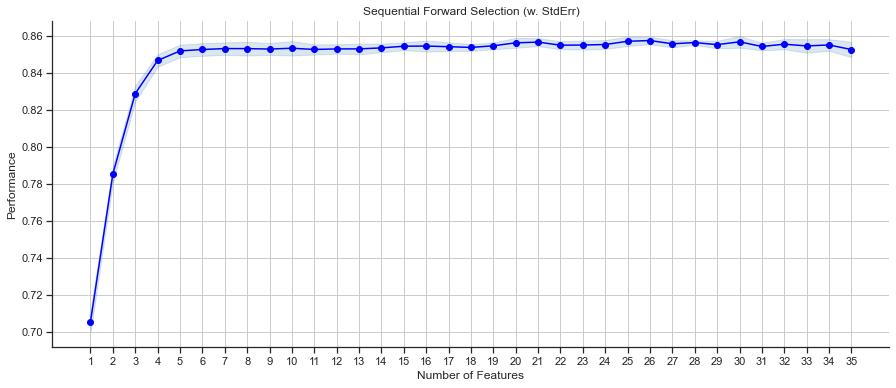

In [ ]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [11]:
selected_columns_1 = ['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'chronic_med_condition',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa',
 'household_adults',
 'employment_industry']

##### Seasonal Flu Vaccines

In [408]:
sfs2 = SFS(xgb.XGBClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [409]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   28.4s finished

[2023-05-02 20:12:23] Features: 1/35 -- score: 0.7183836938438439[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   51.5s finished

[2023-05-02 20:13:15] Features: 2/35 -- score: 0.7778923836706837[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.6min finished

[2023-05-02 20:14:50] Features: 3/35 -- score: 0.8112666448194605[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [450]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7266282156510848, 0.7165140310424655, 0.724...",0.718384,"(31,)",0.011555,0.00899,0.004495
2,"(0, 31)","[0.7885046409441441, 0.7809179952134329, 0.788...",0.777892,"(0, 31)",0.014924,0.011612,0.005806
3,"(0, 22, 31)","[0.8250652425919296, 0.8133020061449484, 0.812...",0.811267,"(0, 22, 31)",0.011915,0.00927,0.004635
4,"(0, 22, 30, 31)","[0.8463885189154591, 0.8283160043790528, 0.835...",0.831558,"(0, 22, 30, 31)",0.011649,0.009063,0.004532
5,"(0, 22, 25, 30, 31)","[0.8476592673259805, 0.833663191666446, 0.8421...",0.835758,"(0, 22, 25, 30, 31)",0.010865,0.008454,0.004227
6,"(0, 22, 25, 26, 30, 31)","[0.8506990771065558, 0.8370095006106961, 0.845...",0.83813,"(0, 22, 25, 26, 30, 31)",0.012394,0.009643,0.004822
7,"(0, 22, 25, 26, 30, 31, 32)","[0.8487937459205392, 0.8406939659092348, 0.849...",0.84027,"(0, 22, 25, 26, 30, 31, 32)",0.012102,0.009416,0.004708
8,"(0, 13, 22, 25, 26, 30, 31, 32)","[0.8518749978415552, 0.8405610057086549, 0.852...",0.841761,"(0, 13, 22, 25, 26, 30, 31, 32)",0.01287,0.010013,0.005006
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.8553423235917443, 0.8417733322128607, 0.851...",0.844526,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.011138,0.008666,0.004333
10,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)","[0.8557252317018561, 0.8431679753557405, 0.850...",0.846023,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)",0.009394,0.007309,0.003654


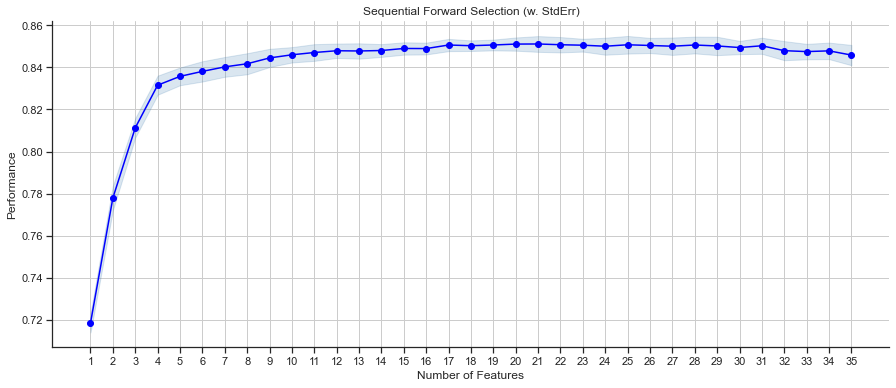

In [451]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [488]:
sfdf2['avg_score'] = sfdf2['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()

selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [12]:
selected_columns_2 = ['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_occupation']

#### Model Optimization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [60]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
col = []
ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

##### h1n1 Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [47]:
def objective(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train[selected_columns_1]), label=y_train.h1n1_vaccine)
    dtest = xgb.DMatrix(ct.fit_transform(X_test[selected_columns_1]), label=y_test.h1n1_vaccine)
    
    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.h1n1_vaccine, pred_labels)    

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [54]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6975230836888867
  Params: 
    booster=dart,
    lambda=6.227375966727043e-06,
    alpha=0.0013009943951840916,
    max_depth=4,
    eta=0.48963301939403747,
    gamma=0.00677056244687695,
    grow_policy=depthwise,
    sample_type=weighted,
    normalize_type=forest,
    rate_drop=8.829340538393375e-07,
    skip_drop=8.518372994885679e-06,


##### Seasonal Flu Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_2].select_dtypes('object').columns
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [51]:
def objective2(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train[selected_columns_2]), label=y_train.seasonal_vaccine, enable_categorical=True)
    dtest = xgb.DMatrix(ct.fit_transform(X_test[selected_columns_2]), label=y_test.seasonal_vaccine, enable_categorical=True)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.seasonal_vaccine, pred_labels)    

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

In [55]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6975230836888867
  Params: 
    booster=gblinear,
    lambda=5.5733661662182675e-05,
    alpha=5.073550463632246e-06,


#### Model Optimization (using all features)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [85]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
col = []
ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

##### h1n1 Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [86]:
def objective(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train), label=y_train.h1n1_vaccine)
    dtest = xgb.DMatrix(ct.fit_transform(X_test), label=y_test.h1n1_vaccine)
    
    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.h1n1_vaccine, pred_labels)    

In [87]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2023-05-04 16:45:31,376] A new study created in memory with name: no-name-3032f839-83e2-4afb-81ad-6218678f3652


[16:45:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.72679
[1]	validation-auc:0.76429
[2]	validation-auc:0.77787
[3]	validation-auc:0.78727
[4]	validation-auc:0.79006
[5]	validation-auc:0.79163
[6]	validation-auc:0.79303
[7]	validation-auc:0.79385
[8]	validation-auc:0.79582
[9]	validation-auc:0.79751


[I 2023-05-04 16:45:33,281] Trial 0 finished with value: 0.568876810512225 and parameters: {'booster': 'gblinear', 'lambda': 0.22329924953916103, 'alpha': 8.077733304712393e-05}. Best is trial 0 with value: 0.568876810512225.


[16:45:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78741
[1]	validation-auc:0.79536
[2]	validation-auc:0.80197
[3]	validation-auc:0.80839
[4]	validation-auc:0.81064
[5]	validation-auc:0.81472
[6]	validation-auc:0.81760
[7]	validation-auc:0.81910
[8]	validation-auc:0.82032
[9]	validation-auc:0.82167


[I 2023-05-04 16:45:34,337] Trial 1 finished with value: 0.711524835751121 and parameters: {'booster': 'gblinear', 'lambda': 2.3681216737379724e-06, 'alpha': 3.1751908127328534e-07}. Best is trial 1 with value: 0.711524835751121.


[16:45:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.44336
[1]	validation-auc:0.48716
[2]	validation-auc:0.49909
[3]	validation-auc:0.50181
[4]	validation-auc:0.51535
[5]	validation-auc:0.53854
[6]	validation-auc:0.56570
[7]	validation-auc:0.59227
[8]	validation-auc:0.61495
[9]	validation-auc:0.63733


[I 2023-05-04 16:45:35,149] Trial 2 finished with value: 0.5 and parameters: {'booster': 'gblinear', 'lambda': 1.8470512319486206e-07, 'alpha': 0.10952070975647124}. Best is trial 1 with value: 0.711524835751121.


[16:45:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78346
[1]	validation-auc:0.79598
[2]	validation-auc:0.80188
[3]	validation-auc:0.80738
[4]	validation-auc:0.81169
[5]	validation-auc:0.81437
[6]	validation-auc:0.81746
[7]	validation-auc:0.81931
[8]	validation-auc:0.82078
[9]	validation-auc:0.82124


[I 2023-05-04 16:45:35,921] Trial 3 finished with value: 0.7099222719458037 and parameters: {'booster': 'gblinear', 'lambda': 0.001072267816376615, 'alpha': 0.0004352136233851177}. Best is trial 1 with value: 0.711524835751121.


[16:45:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.76110
[1]	validation-auc:0.76110
[2]	validation-auc:0.76110
[3]	validation-auc:0.76110
[4]	validation-auc:0.76110
[5]	validation-auc:0.76110
[6]	validation-auc:0.76110
[7]	validation-auc:0.76110
[8]	validation-auc:0.76110
[9]	validation-auc:0.76110


[I 2023-05-04 16:45:36,889] Trial 4 finished with value: 0.6163850834696472 and parameters: {'booster': 'gbtree', 'lambda': 1.0683305463736881e-06, 'alpha': 4.173607282474027e-06, 'max_depth': 2, 'eta': 2.1130165060874262e-07, 'gamma': 0.5145697272255445, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.711524835751121.


[16:45:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.50000


[I 2023-05-04 16:45:37,724] Trial 5 pruned. Trial was pruned at iteration 0.


[16:45:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.50000


[I 2023-05-04 16:45:38,440] Trial 6 pruned. Trial was pruned at iteration 0.


[16:45:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81917
[1]	validation-auc:0.82371
[2]	validation-auc:0.83059
[3]	validation-auc:0.83409
[4]	validation-auc:0.83777
[5]	validation-auc:0.83917
[6]	validation-auc:0.83863
[7]	validation-auc:0.83947
[8]	validation-auc:0.84020
[9]	validation-auc:0.84195


[I 2023-05-04 16:45:40,237] Trial 7 finished with value: 0.7155923615576846 and parameters: {'booster': 'gbtree', 'lambda': 0.00033779714038720233, 'alpha': 0.0012101790897843688, 'max_depth': 8, 'eta': 0.2590961274788733, 'gamma': 0.19999268434491624, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:41,282] Trial 8 pruned. Trial was pruned at iteration 0.


[16:45:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79564
[1]	validation-auc:0.79879
[2]	validation-auc:0.79839
[3]	validation-auc:0.79868
[4]	validation-auc:0.79839


[I 2023-05-04 16:45:43,385] Trial 9 pruned. Trial was pruned at iteration 4.


[16:45:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81882
[1]	validation-auc:0.82416
[2]	validation-auc:0.82905
[3]	validation-auc:0.82588
[4]	validation-auc:0.81554
[5]	validation-auc:0.81179
[6]	validation-auc:0.81119
[7]	validation-auc:0.81146
[8]	validation-auc:0.80657
[9]	validation-auc:0.80421


[I 2023-05-04 16:45:44,923] Trial 10 finished with value: 0.7111128340320747 and parameters: {'booster': 'gbtree', 'lambda': 1.884740742463383e-08, 'alpha': 0.5653289082213817, 'max_depth': 9, 'eta': 0.7895362385135047, 'gamma': 0.8955225612354021, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:45,411] Trial 11 pruned. Trial was pruned at iteration 0.


[16:45:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83597
[2]	validation-auc:0.84174
[3]	validation-auc:0.84154
[4]	validation-auc:0.84234
[5]	validation-auc:0.84232
[6]	vali

[I 2023-05-04 16:45:46,489] Trial 12 finished with value: 0.7068019095734825 and parameters: {'booster': 'gbtree', 'lambda': 3.832996646738778e-05, 'alpha': 0.0035101065870654425, 'max_depth': 6, 'eta': 0.1395599055152961, 'gamma': 0.004925577631212891, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:47,179] Trial 13 pruned. Trial was pruned at iteration 0.


[16:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82656
[1]	validation-auc:0.82759
[2]	validation-auc:0.82791
[3]	validation-auc:0.82782
[4]	validation-auc:0.82773
[5]	validation-auc:0.82771
[6]	vali

[I 2023-05-04 16:45:49,071] Trial 14 finished with value: 0.6993705763720885 and parameters: {'booster': 'dart', 'lambda': 1.8061769586495197e-06, 'alpha': 0.0016783147196936848, 'max_depth': 7, 'eta': 0.004750622439855306, 'gamma': 0.007921092640492943, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00011905478482263299, 'skip_drop': 0.788083668389069}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:50,125] Trial 15 pruned. Trial was pruned at iteration 0.


[16:45:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82531
[1]	validation-auc:0.82531
[2]	validation-auc:0.82531
[3]	validation-auc:0.82531
[4]	validation-auc:0.82531
[5]	validation-auc:0.82531
[6]	vali

[I 2023-05-04 16:45:51,725] Trial 16 finished with value: 0.6890302838188723 and parameters: {'booster': 'gbtree', 'lambda': 0.0024013343836336186, 'alpha': 1.2544978821930024e-07, 'max_depth': 4, 'eta': 0.0017045008292360573, 'gamma': 2.3734405986405047e-05, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.


[16:45:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.77040


[I 2023-05-04 16:45:53,019] Trial 17 pruned. Trial was pruned at iteration 0.


[16:45:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81892
[1]	validation-auc:0.82362
[2]	validation-auc:0.82709
[3]	validation-auc:0.82871
[4]	validation-auc:0.82879
[5]	validation-auc:0.82904
[6]	validation-auc:0.82881
[7]	validation-auc:0.82958
[8]	validation-auc:0.83156
[9]	validation-auc:0.83374


[I 2023-05-04 16:45:55,123] Trial 18 finished with value: 0.7082906338492266 and parameters: {'booster': 'gbtree', 'lambda': 0.00012824177201674648, 'alpha': 9.66315032796765e-06, 'max_depth': 8, 'eta': 0.0707946795257538, 'gamma': 0.025477918810489986, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.7155923615576846.


[16:45:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82531
[1]	validation-auc:0.82531
[2]	validation-auc:0.82531
[3]	validation-auc:0.82531
[4]	validation-auc:0.82531
[5]	validation-auc:0.82531
[6]	validation-auc:0.82531
[7]	validation-auc:0.82531
[8]	validation-auc:0.82531
[9]	validation-auc:0.82531


[I 2023-05-04 16:45:56,349] Trial 19 finished with value: 0.6890302838188723 and parameters: {'booster': 'dart', 'lambda': 9.233222445051324e-06, 'alpha': 1.7404766922527367e-06, 'max_depth': 4, 'eta': 0.0008460678651352715, 'gamma': 0.0006184432525154448, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.7517227940502623, 'skip_drop': 1.1278989850362918e-08}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:45:57,301] Trial 20 pruned. Trial was pruned at iteration 0.


[16:45:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:45:58,066] Trial 21 pruned. Trial was pruned at iteration 0.


[16:45:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:45:58,873] Trial 22 pruned. Trial was pruned at iteration 0.


[16:45:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:45:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82766
[1]	validation-auc:0.82829
[2]	validation-auc:0.82582
[3]	validation-auc:0.82737
[4]	validation-auc:0.82539
[5]	validation-auc:0.82515
[6]	vali

[I 2023-05-04 16:46:02,659] Trial 23 finished with value: 0.7128149552589782 and parameters: {'booster': 'gbtree', 'lambda': 2.388060201850511e-07, 'alpha': 0.7638681338728123, 'max_depth': 9, 'eta': 0.6366030061215868, 'gamma': 0.051445635325899644, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.


[16:46:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82656
[1]	validation-auc:0.82751
[2]	validation-auc:0.82780
[3]	validation-auc:0.82876
[4]	validation-auc:0.83026
[5]	validation-auc:0.82998
[6]	validation-auc:0.83120
[7]	validation-auc:0.83206
[8]	validation-auc:0.83249
[9]	validation-auc:0.83292


[I 2023-05-04 16:46:05,435] Trial 24 finished with value: 0.7032449227569809 and parameters: {'booster': 'gbtree', 'lambda': 1.277531669230664e-07, 'alpha': 0.00022987086833327252, 'max_depth': 7, 'eta': 0.015330199394601991, 'gamma': 0.04856164661763011, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.
[I 2023-05-04 16:46:06,572] Trial 25 pruned. Trial was pruned at iteration 0.


[16:46:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82685
[1]	validation-auc:0.82886
[2]	validation-auc:0.82904
[3]	validation-auc:0.82573
[4]	validation-auc:0.82283
[5]	validation-auc:0.81754
[6]	vali

[I 2023-05-04 16:46:08,584] Trial 26 finished with value: 0.7143790779359794 and parameters: {'booster': 'gbtree', 'lambda': 3.6632128229883846e-06, 'alpha': 0.06102845772881951, 'max_depth': 7, 'eta': 0.9366479671150284, 'gamma': 0.0019376675695332946, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7155923615576846.


[16:46:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789
[1]	validation-auc:0.83363
[2]	validation-auc:0.83618
[3]	validation-auc:0.83419
[4]	validation-auc:0.83098
[5]	validation-auc:0.82692
[6]	validation-auc:0.82410
[7]	validation-auc:0.81849
[8]	validation-auc:0.81593
[9]	validation-auc:0.81582


[I 2023-05-04 16:46:10,808] Trial 27 finished with value: 0.7203335113341511 and parameters: {'booster': 'gbtree', 'lambda': 4.2154982394643624e-05, 'alpha': 0.10444989108069702, 'max_depth': 7, 'eta': 0.7084394234432615, 'gamma': 0.0029284383308014516, 'grow_policy': 'depthwise'}. Best is trial 27 with value: 0.7203335113341511.


[16:46:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82689
[1]	validation-auc:0.82976
[2]	validation-auc:0.83114
[3]	validation-auc:0.81473
[4]	validation-auc:0.81336
[5]	validation-auc:0.81183
[6]	validation-auc:0.80989
[7]	validation-auc:0.80598
[8]	validation-auc:0.80617
[9]	validation-auc:0.80503


[I 2023-05-04 16:46:13,776] Trial 28 finished with value: 0.7206784613384265 and parameters: {'booster': 'gbtree', 'lambda': 4.83509451251889e-05, 'alpha': 0.0682303349456247, 'max_depth': 7, 'eta': 0.9070832262116028, 'gamma': 0.001174484224270065, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83616
[2]	validation-auc:0.84145
[3]	validation-auc:0.84212
[4]	validation-auc:0.84136
[5]	validation-auc:0.84141
[6]	validation-auc:0.84225
[7]	validation-auc:0.84358
[8]	validation-auc:0.84430
[9]	validation-auc:0.84492


[I 2023-05-04 16:46:15,398] Trial 29 finished with value: 0.7058207565770498 and parameters: {'booster': 'gbtree', 'lambda': 3.875271785683461e-05, 'alpha': 0.00943976444872445, 'max_depth': 6, 'eta': 0.10623124371119545, 'gamma': 0.000553108437466411, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82705
[1]	validation-auc:0.82766
[2]	validation-auc:0.82871
[3]	validation-auc:0.82960
[4]	validation-auc:0.83105
[5]	validation-auc:0.83215
[6]	validation-auc:0.83344
[7]	validation-auc:0.83327
[8]	validation-auc:0.83390
[9]	validation-auc:0.83364


[I 2023-05-04 16:46:16,739] Trial 30 finished with value: 0.7100651857666366 and parameters: {'booster': 'gbtree', 'lambda': 0.0001732929506071474, 'alpha': 0.08504421617083521, 'max_depth': 7, 'eta': 0.021569601291253633, 'gamma': 0.00978869261427368, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82685
[1]	validation-auc:0.83284
[2]	validation-auc:0.83492
[3]	validation-auc:0.83334
[4]	validation-auc:0.83169
[5]	validation-auc:0.82648
[6]	validation-auc:0.82317
[7]	validation-auc:0.82221
[8]	validation-auc:0.82034
[9]	validation-auc:0.81410


[I 2023-05-04 16:46:17,899] Trial 31 finished with value: 0.7145855656855477 and parameters: {'booster': 'gbtree', 'lambda': 3.77706163954767e-05, 'alpha': 0.061393380105714775, 'max_depth': 7, 'eta': 0.7005442594985666, 'gamma': 0.0021773842026882495, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81917


[I 2023-05-04 16:46:18,554] Trial 32 pruned. Trial was pruned at iteration 0.


[16:46:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83725
[2]	validation-auc:0.84045
[3]	validation-auc:0.84267
[4]	validation-auc:0.84040
[5]	validation-auc:0.84204
[6]	validation-auc:0.84408
[7]	validation-auc:0.84550
[8]	validation-auc:0.84748
[9]	validation-auc:0.84812


[I 2023-05-04 16:46:19,352] Trial 33 finished with value: 0.7115977765169129 and parameters: {'booster': 'gbtree', 'lambda': 0.0002904660720065155, 'alpha': 0.039995036206989035, 'max_depth': 5, 'eta': 0.2618452077818759, 'gamma': 0.00022913557090608252, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83318
[1]	validation-auc:0.83315
[2]	validation-auc:0.83657
[3]	validation-auc:0.83673
[4]	validation-auc:0.83770
[5]	validation-auc:0.83993
[6]	validation-auc:0.84030
[7]	validation-auc:0.84028
[8]	validation-auc:0.83991
[9]	validation-auc:0.84211


[I 2023-05-04 16:46:21,302] Trial 34 finished with value: 0.7015206364404091 and parameters: {'booster': 'gbtree', 'lambda': 1.775010725667371e-05, 'alpha': 0.19406444143575274, 'max_depth': 6, 'eta': 0.04695427344141466, 'gamma': 4.365457525083506e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82719
[1]	validation-auc:0.83595
[2]	validation-auc:0.83990
[3]	validation-auc:0.84058
[4]	validation-auc:0.84251
[5]	validation-auc:0.84472
[6]	validation-auc:0.84309
[7]	validation-auc:0.84195
[8]	validation-auc:0.84295
[9]	validation-auc:0.84535


[I 2023-05-04 16:46:24,373] Trial 35 finished with value: 0.7130879846480322 and parameters: {'booster': 'gbtree', 'lambda': 0.0005643793943843766, 'alpha': 0.20879373436418922, 'max_depth': 7, 'eta': 0.24219475268992197, 'gamma': 0.0015270385909697418, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81340


[I 2023-05-04 16:46:25,446] Trial 36 pruned. Trial was pruned at iteration 0.


[16:46:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83950
[2]	validation-auc:0.83943
[3]	validation-auc:0.84137
[4]	validation-auc:0.84277
[5]	validation-auc:0.84149
[6]	validation-auc:0.84136
[7]	validation-auc:0.84265
[8]	validation-auc:0.84542
[9]	validation-auc:0.84720


[I 2023-05-04 16:46:26,702] Trial 37 finished with value: 0.7050697402752292 and parameters: {'booster': 'dart', 'lambda': 0.0001284152345599218, 'alpha': 0.007044078794412308, 'max_depth': 5, 'eta': 0.16746531867620784, 'gamma': 0.14259905510246185, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8683455429671828e-08, 'skip_drop': 0.4718083048194957}. Best is trial 28 with value: 0.7206784613384265.


[16:46:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82655


[I 2023-05-04 16:46:27,270] Trial 38 pruned. Trial was pruned at iteration 0.


[16:46:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83350
[1]	validation-auc:0.83311
[2]	validation-auc:0.83315
[3]	validation-auc:0.83317
[4]	validation-auc:0.83337
[5]	validation-auc:0.83339
[6]	validation-auc:0.83345
[7]	validation-auc:0.83342
[8]	validation-auc:0.83393
[9]	validation-auc:0.83401


[I 2023-05-04 16:46:28,342] Trial 39 finished with value: 0.7040328963317425 and parameters: {'booster': 'gbtree', 'lambda': 2.3338635914814658e-05, 'alpha': 0.1466783978275151, 'max_depth': 6, 'eta': 0.0069753402970858065, 'gamma': 0.15414432322449848, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.
[I 2023-05-04 16:46:28,975] Trial 40 pruned. Trial was pruned at iteration 0.


[16:46:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82685
[1]	validation-auc:0.83192
[2]	validation-auc:0.83519
[3]	validation-auc:0.83475
[4]	validation-auc:0.83458
[5]	validation-auc:0.83294
[6]	vali

[I 2023-05-04 16:46:30,555] Trial 41 finished with value: 0.717108676269313 and parameters: {'booster': 'gbtree', 'lambda': 6.2031412179741386e-06, 'alpha': 0.0531766706711103, 'max_depth': 7, 'eta': 0.6633424423307401, 'gamma': 0.002206560383404612, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81423


[I 2023-05-04 16:46:31,651] Trial 42 pruned. Trial was pruned at iteration 0.


[16:46:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83008
[1]	validation-auc:0.83350
[2]	validation-auc:0.83614
[3]	validation-auc:0.83674
[4]	validation-auc:0.83815
[5]	validation-auc:0.83851
[6]	validation-auc:0.83941
[7]	validation-auc:0.84027
[8]	validation-auc:0.84156
[9]	validation-auc:0.84200


[I 2023-05-04 16:46:33,605] Trial 43 finished with value: 0.709948888601598 and parameters: {'booster': 'gbtree', 'lambda': 2.0931195767263298e-05, 'alpha': 0.350454374433611, 'max_depth': 7, 'eta': 0.08721230292798748, 'gamma': 0.0003999012668765723, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83320
[1]	validation-auc:0.83943
[2]	validation-auc:0.83976
[3]	validation-auc:0.84204
[4]	validation-auc:0.84513
[5]	validation-auc:0.84444
[6]	validation-auc:0.84447
[7]	validation-auc:0.84457
[8]	validation-auc:0.84580
[9]	validation-auc:0.84456


[I 2023-05-04 16:46:35,037] Trial 44 finished with value: 0.71534645889971 and parameters: {'booster': 'gbtree', 'lambda': 1.060637742988244e-05, 'alpha': 0.1794615698022464, 'max_depth': 6, 'eta': 0.336178805869231, 'gamma': 0.00010565553170737533, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83361
[1]	validation-auc:0.83760
[2]	validation-auc:0.83734
[3]	validation-auc:0.83868
[4]	validation-auc:0.83990
[5]	validation-auc:0.83954
[6]	validation-auc:0.84115
[7]	validation-auc:0.84116
[8]	validation-auc:0.84006
[9]	validation-auc:0.84082


[I 2023-05-04 16:46:36,020] Trial 45 finished with value: 0.7038875248754441 and parameters: {'booster': 'gbtree', 'lambda': 8.261885922994276e-06, 'alpha': 0.9646753531470842, 'max_depth': 6, 'eta': 0.05150131912339899, 'gamma': 0.00011135054692410164, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83694
[1]	validation-auc:0.83758
[2]	validation-auc:0.84054
[3]	validation-auc:0.84209
[4]	validation-auc:0.84183
[5]	validation-auc:0.84481
[6]	validation-auc:0.84453
[7]	validation-auc:0.84634
[8]	validation-auc:0.84773
[9]	validation-auc:0.84882


[I 2023-05-04 16:46:37,304] Trial 46 finished with value: 0.7117525148102678 and parameters: {'booster': 'gbtree', 'lambda': 2.193507693487387e-06, 'alpha': 0.28160747843354356, 'max_depth': 5, 'eta': 0.2726056535276454, 'gamma': 4.095178540794367e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83717
[2]	validation-auc:0.84181
[3]	validation-auc:0.84138
[4]	validation-auc:0.84159
[5]	validation-auc:0.84168
[6]	validation-auc:0.84310
[7]	validation-auc:0.84395
[8]	validation-auc:0.84590
[9]	validation-auc:0.84641


[I 2023-05-04 16:46:38,482] Trial 47 finished with value: 0.7079708166453703 and parameters: {'booster': 'gbtree', 'lambda': 8.993363767658601e-05, 'alpha': 0.08747692436967888, 'max_depth': 6, 'eta': 0.1454250244966354, 'gamma': 0.00017654149141553842, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82531


[I 2023-05-04 16:46:39,237] Trial 48 pruned. Trial was pruned at iteration 0.


[16:46:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.77060


[I 2023-05-04 16:46:39,929] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:46:41,292] Trial 50 pruned. Trial was pruned at iteration 0.


[16:46:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789
[1]	validation-auc:0.82666


[I 2023-05-04 16:46:42,784] Trial 51 pruned. Trial was pruned at iteration 1.


[16:46:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82998
[1]	validation-auc:0.83457
[2]	validation-auc:0.83747
[3]	validation-auc:0.83967
[4]	validation-auc:0.84140
[5]	validation-auc:0.84350
[6]	validation-auc:0.84023
[7]	validation-auc:0.84083
[8]	validation-auc:0.84006
[9]	validation-auc:0.83711


[I 2023-05-04 16:46:45,081] Trial 52 finished with value: 0.7192272044109085 and parameters: {'booster': 'gbtree', 'lambda': 3.307884015385516e-05, 'alpha': 0.38028435901502583, 'max_depth': 7, 'eta': 0.38619256380951444, 'gamma': 0.010987715423631618, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83328
[1]	validation-auc:0.83653
[2]	validation-auc:0.84014
[3]	validation-auc:0.84087
[4]	validation-auc:0.84274
[5]	validation-auc:0.84306
[6]	validation-auc:0.84429
[7]	validation-auc:0.84521
[8]	validation-auc:0.84523
[9]	validation-auc:0.84713


[I 2023-05-04 16:46:46,084] Trial 53 finished with value: 0.7085010630896355 and parameters: {'booster': 'gbtree', 'lambda': 0.00018190862447622496, 'alpha': 0.41265977814913585, 'max_depth': 6, 'eta': 0.13852385372788406, 'gamma': 0.012977501432117278, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.
[I 2023-05-04 16:46:46,820] Trial 54 pruned. Trial was pruned at iteration 0.


[16:46:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83379
[1]	validation-auc:0.83768
[2]	validation-auc:0.83826
[3]	validation-auc:0.83770
[4]	validation-auc:0.83889
[5]	validation-auc:0.83864
[6]	vali

[I 2023-05-04 16:46:48,133] Trial 55 finished with value: 0.7030689931540477 and parameters: {'booster': 'gbtree', 'lambda': 8.514132747695138e-05, 'alpha': 0.9411359793516668, 'max_depth': 6, 'eta': 0.03740498069024442, 'gamma': 0.0010117583230342222, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7206784613384265.


[16:46:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82788
[1]	validation-auc:0.83480
[2]	validation-auc:0.83771
[3]	validation-auc:0.84009
[4]	validation-auc:0.84201
[5]	validation-auc:0.84126
[6]	validation-auc:0.84073
[7]	validation-auc:0.83988
[8]	validation-auc:0.84014
[9]	validation-auc:0.83842


[I 2023-05-04 16:46:49,476] Trial 56 finished with value: 0.7159718111994355 and parameters: {'booster': 'gbtree', 'lambda': 4.2637761619691175e-06, 'alpha': 0.15306293103765428, 'max_depth': 7, 'eta': 0.3968537615144528, 'gamma': 0.004907145970776203, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.7206784613384265.
[I 2023-05-04 16:46:50,472] Trial 57 pruned. Trial was pruned at iteration 0.


[16:46:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:46:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:46:53,623] Trial 58 pruned. Trial was pruned at iteration 0.


[16:46:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83194


[I 2023-05-04 16:46:55,217] Trial 59 pruned. Trial was pruned at iteration 1.


[16:46:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79455


[I 2023-05-04 16:46:55,917] Trial 60 pruned. Trial was pruned at iteration 0.


[16:46:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82770
[1]	validation-auc:0.83674
[2]	validation-auc:0.83850
[3]	validation-auc:0.84135
[4]	validation-auc:0.83994
[5]	validation-auc:0.83833
[6]	validation-auc:0.83957
[7]	validation-auc:0.83898
[8]	validation-auc:0.83858
[9]	validation-auc:0.83565


[I 2023-05-04 16:46:57,144] Trial 61 finished with value: 0.724975150059512 and parameters: {'booster': 'gbtree', 'lambda': 9.36255580795658e-06, 'alpha': 0.09403763787416182, 'max_depth': 7, 'eta': 0.4662410961117156, 'gamma': 0.0012504901430155663, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:46:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81347


[I 2023-05-04 16:46:57,830] Trial 62 pruned. Trial was pruned at iteration 0.


[16:46:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82944
[1]	validation-auc:0.83493
[2]	validation-auc:0.83674
[3]	validation-auc:0.83864
[4]	validation-auc:0.84268
[5]	validation-auc:0.84348
[6]	validation-auc:0.84475
[7]	validation-auc:0.84577
[8]	validation-auc:0.84647
[9]	validation-auc:0.84597


[I 2023-05-04 16:46:58,956] Trial 63 finished with value: 0.7198092003113872 and parameters: {'booster': 'gbtree', 'lambda': 1.2756235229516154e-05, 'alpha': 0.3158957354190776, 'max_depth': 7, 'eta': 0.163338576683931, 'gamma': 0.0011945495046585526, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:46:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83001
[1]	validation-auc:0.83538
[2]	validation-auc:0.83758
[3]	validation-auc:0.83769
[4]	validation-auc:0.83949
[5]	validation-auc:0.84200
[6]	validation-auc:0.84220
[7]	validation-auc:0.84342
[8]	validation-auc:0.84473
[9]	validation-auc:0.84622


[I 2023-05-04 16:47:00,697] Trial 64 finished with value: 0.7090761497885228 and parameters: {'booster': 'gbtree', 'lambda': 1.5551563557534068e-05, 'alpha': 0.38891843106122714, 'max_depth': 7, 'eta': 0.1283895173459569, 'gamma': 0.0010240329587246405, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82774
[1]	validation-auc:0.83548


[I 2023-05-04 16:47:01,939] Trial 65 pruned. Trial was pruned at iteration 2.


[16:47:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83200
[1]	validation-auc:0.83533
[2]	validation-auc:0.83777
[3]	validation-auc:0.83871
[4]	validation-auc:0.84083
[5]	validation-auc:0.84301
[6]	validation-auc:0.84462
[7]	validation-auc:0.84561
[8]	validation-auc:0.84681
[9]	validation-auc:0.84751


[I 2023-05-04 16:47:05,542] Trial 66 finished with value: 0.7103204552616676 and parameters: {'booster': 'gbtree', 'lambda': 8.858908207039126e-06, 'alpha': 0.5549268298258987, 'max_depth': 7, 'eta': 0.14999300326728224, 'gamma': 0.0004114255117374572, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82882
[1]	validation-auc:0.83576
[2]	validation-auc:0.83668
[3]	validation-auc:0.83088
[4]	validation-auc:0.83121


[I 2023-05-04 16:47:06,450] Trial 67 pruned. Trial was pruned at iteration 4.


[16:47:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.67152


[I 2023-05-04 16:47:07,089] Trial 68 pruned. Trial was pruned at iteration 0.


[16:47:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81920


[I 2023-05-04 16:47:07,686] Trial 69 pruned. Trial was pruned at iteration 0.


[16:47:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80162


[I 2023-05-04 16:47:08,249] Trial 70 pruned. Trial was pruned at iteration 0.


[16:47:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82776
[1]	validation-auc:0.83580
[2]	validation-auc:0.83938
[3]	validation-auc:0.84043
[4]	validation-auc:0.84415
[5]	validation-auc:0.84177
[6]	validation-auc:0.84072
[7]	validation-auc:0.84196
[8]	validation-auc:0.84102
[9]	validation-auc:0.83941


[I 2023-05-04 16:47:09,321] Trial 71 finished with value: 0.7161886395661503 and parameters: {'booster': 'gbtree', 'lambda': 3.0121999055556254e-06, 'alpha': 0.13803816543929143, 'max_depth': 7, 'eta': 0.4371219138894703, 'gamma': 0.026543710104492472, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83348
[1]	validation-auc:0.83996
[2]	validation-auc:0.84225
[3]	validation-auc:0.84374
[4]	validation-auc:0.84339
[5]	validation-auc:0.84413
[6]	validation-auc:0.84108
[7]	validation-auc:0.84174
[8]	validation-auc:0.84176
[9]	validation-auc:0.84086


[I 2023-05-04 16:47:10,753] Trial 72 finished with value: 0.7248918686765735 and parameters: {'booster': 'gbtree', 'lambda': 2.7940197032895526e-06, 'alpha': 0.14209074183386958, 'max_depth': 6, 'eta': 0.4457808326690404, 'gamma': 0.029966362932422882, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83317
[1]	validation-auc:0.83739
[2]	validation-auc:0.84038
[3]	validation-auc:0.84233
[4]	validation-auc:0.84402
[5]	validation-auc:0.84566
[6]	validation-auc:0.84608
[7]	validation-auc:0.84741
[8]	validation-auc:0.84976
[9]	validation-auc:0.84980


[I 2023-05-04 16:47:13,652] Trial 73 finished with value: 0.7126755192241812 and parameters: {'booster': 'gbtree', 'lambda': 2.4968221208747273e-06, 'alpha': 0.24365938842408807, 'max_depth': 6, 'eta': 0.19074909419624736, 'gamma': 0.02796422338319947, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82705


[I 2023-05-04 16:47:14,731] Trial 74 pruned. Trial was pruned at iteration 0.


[16:47:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.84017
[2]	validation-auc:0.84018
[3]	validation-auc:0.83974
[4]	validation-auc:0.84151
[5]	validation-auc:0.84258
[6]	validation-auc:0.84470
[7]	validation-auc:0.84502
[8]	validation-auc:0.84731
[9]	validation-auc:0.84689


[I 2023-05-04 16:47:16,092] Trial 75 finished with value: 0.7076534570769791 and parameters: {'booster': 'gbtree', 'lambda': 2.5498816000456216e-05, 'alpha': 0.01425158163996712, 'max_depth': 6, 'eta': 0.20733704146910192, 'gamma': 0.008998697183727223, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83140
[1]	validation-auc:0.83670
[2]	validation-auc:0.83746
[3]	validation-auc:0.83996
[4]	validation-auc:0.83883
[5]	validation-auc:0.83996
[6]	validation-auc:0.83894
[7]	validation-auc:0.83762


[I 2023-05-04 16:47:17,196] Trial 76 pruned. Trial was pruned at iteration 8.


[16:47:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.81383


[I 2023-05-04 16:47:17,919] Trial 77 pruned. Trial was pruned at iteration 0.


[16:47:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83380


[I 2023-05-04 16:47:18,541] Trial 78 pruned. Trial was pruned at iteration 2.


[16:47:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82683


[I 2023-05-04 16:47:19,221] Trial 79 pruned. Trial was pruned at iteration 0.


[16:47:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83698
[1]	validation-auc:0.83575
[2]	validation-auc:0.84150
[3]	validation-auc:0.84368
[4]	validation-auc:0.84369
[5]	validation-auc:0.84493
[6]	validation-auc:0.84021
[7]	validation-auc:0.84102
[8]	validation-auc:0.83940
[9]	validation-auc:0.83860


[I 2023-05-04 16:47:20,377] Trial 80 finished with value: 0.7177369962797892 and parameters: {'booster': 'dart', 'lambda': 2.5669319092578e-05, 'alpha': 0.22420010786222927, 'max_depth': 5, 'eta': 0.5856231769563073, 'gamma': 0.04043395114945822, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.023839414618716446, 'skip_drop': 0.018226072792131287}. Best is trial 61 with value: 0.724975150059512.


[16:47:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83698
[1]	validation-auc:0.83586
[2]	validation-auc:0.84346
[3]	validation-auc:0.84397
[4]	validation-auc:0.84589
[5]	validation-auc:0.84275
[6]	validation-auc:0.84093
[7]	validation-auc:0.84103
[8]	validation-auc:0.83959
[9]	validation-auc:0.83661


[I 2023-05-04 16:47:23,960] Trial 81 finished with value: 0.7129450708271993 and parameters: {'booster': 'dart', 'lambda': 1.6472009301830113e-05, 'alpha': 0.21815454243337137, 'max_depth': 5, 'eta': 0.598344798697633, 'gamma': 0.02650084014199779, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.019404407346384215, 'skip_drop': 0.013830790757348915}. Best is trial 61 with value: 0.724975150059512.


[16:47:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83685
[2]	validation-auc:0.83847
[3]	validation-auc:0.83883


[I 2023-05-04 16:47:25,655] Trial 82 pruned. Trial was pruned at iteration 4.
[I 2023-05-04 16:47:26,309] Trial 83 pruned. Trial was pruned at iteration 0.


[16:47:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83348
[1]	validation-auc:0.83661
[2]	validation-auc:0.84156
[3]	validation-auc:0.84149
[4]	validation-auc:0.84109
[5]	validation-auc:0.84182
[6]	vali

[I 2023-05-04 16:47:27,789] Trial 84 finished with value: 0.7060336434529241 and parameters: {'booster': 'dart', 'lambda': 2.9829404943710872e-06, 'alpha': 0.1247497827401285, 'max_depth': 6, 'eta': 0.11291534543710627, 'gamma': 0.0015051265228815496, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.06119588107234857, 'skip_drop': 0.006297155870836066}. Best is trial 61 with value: 0.724975150059512.
[I 2023-05-04 16:47:28,480] Trial 85 pruned. Trial was pruned at iteration 0.


[16:47:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82936


[I 2023-05-04 16:47:29,145] Trial 86 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:47:29,651] Trial 87 pruned. Trial was pruned at iteration 0.


[16:47:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83699
[1]	validation-auc:0.83840
[2]	validation-auc:0.84047
[3]	validation-auc:0.84331
[4]	validation-auc:0.84642
[5]	validation-auc:0.84672
[6]	vali

[I 2023-05-04 16:47:30,596] Trial 88 finished with value: 0.7158224982522966 and parameters: {'booster': 'gbtree', 'lambda': 1.950796364650657e-05, 'alpha': 0.07586056137512309, 'max_depth': 5, 'eta': 0.38029946710834533, 'gamma': 0.1254850497314118, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.
[I 2023-05-04 16:47:32,374] Trial 89 pruned. Trial was pruned at iteration 0.


[16:47:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:47:33,484] Trial 90 pruned. Trial was pruned at iteration 0.


[16:47:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789


[I 2023-05-04 16:47:34,454] Trial 91 pruned. Trial was pruned at iteration 0.


[16:47:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82849


[I 2023-05-04 16:47:35,398] Trial 92 pruned. Trial was pruned at iteration 0.


[16:47:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83323
[1]	validation-auc:0.83961
[2]	validation-auc:0.83968
[3]	validation-auc:0.84215
[4]	validation-auc:0.84562
[5]	validation-auc:0.84589
[6]	validation-auc:0.84603
[7]	validation-auc:0.84466
[8]	validation-auc:0.84551
[9]	validation-auc:0.84704


[I 2023-05-04 16:47:36,566] Trial 93 finished with value: 0.7123369683462116 and parameters: {'booster': 'gbtree', 'lambda': 6.467201914682939e-06, 'alpha': 0.05046133969669728, 'max_depth': 6, 'eta': 0.3125308650279202, 'gamma': 0.00962933200886723, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.


[16:47:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83066


[I 2023-05-04 16:47:37,398] Trial 94 pruned. Trial was pruned at iteration 1.


[16:47:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82132


[I 2023-05-04 16:47:38,107] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:47:38,749] Trial 96 pruned. Trial was pruned at iteration 0.


[16:47:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.82789


[I 2023-05-04 16:47:39,621] Trial 97 pruned. Trial was pruned at iteration 0.


[16:47:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.83332
[1]	validation-auc:0.83652
[2]	validation-auc:0.83905
[3]	validation-auc:0.84090
[4]	validation-auc:0.84158
[5]	validation-auc:0.84224
[6]	validation-auc:0.84250
[7]	validation-auc:0.84354
[8]	validation-auc:0.84421
[9]	validation-auc:0.84551


[I 2023-05-04 16:47:40,590] Trial 98 finished with value: 0.7088263056397076 and parameters: {'booster': 'gbtree', 'lambda': 1.6424924211504447e-05, 'alpha': 0.3903907519953569, 'max_depth': 6, 'eta': 0.11330778778453078, 'gamma': 0.0007722921380374567, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.724975150059512.
[I 2023-05-04 16:47:41,510] Trial 99 pruned. Trial was pruned at iteration 0.


[16:47:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [88]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.724975150059512
  Params: 
    booster=gbtree,
    lambda=9.36255580795658e-06,
    alpha=0.09403763787416182,
    max_depth=7,
    eta=0.4662410961117156,
    gamma=0.0012504901430155663,
    grow_policy=lossguide,


##### Seasonal Flu Vaccines

In [ ]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_2].select_dtypes('object').columns
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [89]:
def objective2(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train), label=y_train.seasonal_vaccine, enable_categorical=True)
    dtest = xgb.DMatrix(ct.fit_transform(X_test), label=y_test.seasonal_vaccine, enable_categorical=True)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.seasonal_vaccine, pred_labels)    

In [90]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

[I 2023-05-04 16:47:43,025] A new study created in memory with name: no-name-bf724252-62af-486f-93f2-63c1163449bc


[16:47:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.76996
[1]	validation-auc:0.78430
[2]	validation-auc:0.78661
[3]	validation-auc:0.78770
[4]	validation-auc:0.79063
[5]	validation-auc:0.79420
[6]	validation-auc:0.79726
[7]	validation-auc:0.79630
[8]	validation-auc:0.79727
[9]	validation-auc:0.79935


[I 2023-05-04 16:47:44,158] Trial 0 finished with value: 0.7309297974939722 and parameters: {'booster': 'gblinear', 'lambda': 0.22329924953916103, 'alpha': 8.077733304712393e-05}. Best is trial 0 with value: 0.7309297974939722.


[16:47:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74493
[1]	validation-auc:0.76234
[2]	validation-auc:0.77679
[3]	validation-auc:0.78677
[4]	validation-auc:0.79417
[5]	validation-auc:0.79844
[6]	validation-auc:0.80304
[7]	validation-auc:0.80469
[8]	validation-auc:0.80772
[9]	validation-auc:0.80987


[I 2023-05-04 16:47:45,181] Trial 1 finished with value: 0.7437318387947081 and parameters: {'booster': 'gblinear', 'lambda': 2.3681216737379724e-06, 'alpha': 3.1751908127328534e-07}. Best is trial 1 with value: 0.7437318387947081.


[16:47:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.69194
[1]	validation-auc:0.69743
[2]	validation-auc:0.69541
[3]	validation-auc:0.70224
[4]	validation-auc:0.70218
[5]	validation-auc:0.70579
[6]	validation-auc:0.70963
[7]	validation-auc:0.71261
[8]	validation-auc:0.71485
[9]	validation-auc:0.71339


[I 2023-05-04 16:47:46,071] Trial 2 finished with value: 0.6804244693742427 and parameters: {'booster': 'gblinear', 'lambda': 1.8470512319486206e-07, 'alpha': 0.10952070975647124}. Best is trial 1 with value: 0.7437318387947081.


[16:47:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74922
[1]	validation-auc:0.76381
[2]	validation-auc:0.77808
[3]	validation-auc:0.78634
[4]	validation-auc:0.79379
[5]	validation-auc:0.79882
[6]	validation-auc:0.80261
[7]	validation-auc:0.80465
[8]	validation-auc:0.80820
[9]	validation-auc:0.81020


[I 2023-05-04 16:47:47,066] Trial 3 finished with value: 0.7431539283171136 and parameters: {'booster': 'gblinear', 'lambda': 0.001072267816376615, 'alpha': 0.0004352136233851177}. Best is trial 1 with value: 0.7437318387947081.


[16:47:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74175
[1]	validation-auc:0.75263
[2]	validation-auc:0.75263
[3]	validation-auc:0.75365
[4]	validation-auc:0.75263
[5]	validation-auc:0.75263
[6]	validation-auc:0.75365
[7]	validation-auc:0.75263
[8]	validation-auc:0.75365
[9]	validation-auc:0.75365


[I 2023-05-04 16:47:47,778] Trial 4 finished with value: 0.7224132072407462 and parameters: {'booster': 'gbtree', 'lambda': 1.0683305463736881e-06, 'alpha': 4.173607282474027e-06, 'max_depth': 2, 'eta': 2.1130165060874262e-07, 'gamma': 0.5145697272255445, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7437318387947081.


[16:47:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:47:48,713] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:47:49,476] Trial 6 pruned. Trial was pruned at iteration 0.


[16:47:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:47:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.80066
[2]	validation-auc:0.81021
[3]	validation-auc:0.81352
[4]	validation-auc:0.81515
[5]	validation-auc:0.81770
[6]	vali

[I 2023-05-04 16:47:50,599] Trial 7 finished with value: 0.7464100778292753 and parameters: {'booster': 'gbtree', 'lambda': 0.00033779714038720233, 'alpha': 0.0012101790897843688, 'max_depth': 8, 'eta': 0.2590961274788733, 'gamma': 0.19999268434491624, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7464100778292753.


[16:47:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:47:51,306] Trial 8 pruned. Trial was pruned at iteration 1.


[16:47:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78289
[1]	validation-auc:0.78512
[2]	validation-auc:0.78536
[3]	validation-auc:0.78553


[I 2023-05-04 16:47:52,466] Trial 9 pruned. Trial was pruned at iteration 3.


[16:47:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78869
[1]	validation-auc:0.79463
[2]	validation-auc:0.79456
[3]	validation-auc:0.78831
[4]	validation-auc:0.78380
[5]	validation-auc:0.78417


[I 2023-05-04 16:47:54,064] Trial 10 pruned. Trial was pruned at iteration 5.


[16:47:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75373
[1]	validation-auc:0.76726
[2]	validation-auc:0.77866
[3]	validation-auc:0.78589


[I 2023-05-04 16:47:55,174] Trial 11 pruned. Trial was pruned at iteration 3.


[16:47:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.80041
[2]	validation-auc:0.80499
[3]	validation-auc:0.80593
[4]	validation-auc:0.81148
[5]	validation-auc:0.81350
[6]	validation-auc:0.81583
[7]	validation-auc:0.81455
[8]	validation-auc:0.81850
[9]	validation-auc:0.81787


[I 2023-05-04 16:47:56,655] Trial 12 finished with value: 0.7407108948492761 and parameters: {'booster': 'gbtree', 'lambda': 3.832996646738778e-05, 'alpha': 0.0035101065870654425, 'max_depth': 6, 'eta': 0.1395599055152961, 'gamma': 0.004925577631212891, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.7464100778292753.


[16:47:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74861


[I 2023-05-04 16:47:57,241] Trial 13 pruned. Trial was pruned at iteration 0.


[16:47:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79517
[2]	validation-auc:0.79796
[3]	validation-auc:0.79809
[4]	validation-auc:0.79878
[5]	validation-auc:0.79827
[6]	validation-auc:0.79947


[I 2023-05-04 16:47:58,202] Trial 14 pruned. Trial was pruned at iteration 6.


[16:47:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74856


[I 2023-05-04 16:47:59,183] Trial 15 pruned. Trial was pruned at iteration 0.


[16:47:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80214
[2]	validation-auc:0.80214
[3]	validation-auc:0.80214
[4]	validation-auc:0.80214
[5]	validation-auc:0.80214


[I 2023-05-04 16:47:59,884] Trial 16 pruned. Trial was pruned at iteration 6.
[I 2023-05-04 16:48:00,583] Trial 17 pruned. Trial was pruned at iteration 0.


[16:48:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.80253
[2]	validation-auc:0.80313
[3]	validation-auc:0.80461
[4]	validation-auc:0.80564
[5]	validation-auc:0.80769
[6]	vali

[I 2023-05-04 16:48:03,448] Trial 18 pruned. Trial was pruned at iteration 9.


[16:48:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80214
[2]	validation-auc:0.80214
[3]	validation-auc:0.80214
[4]	validation-auc:0.80214
[5]	validation-auc:0.80214


[I 2023-05-04 16:48:04,650] Trial 19 pruned. Trial was pruned at iteration 6.
[I 2023-05-04 16:48:05,866] Trial 20 pruned. Trial was pruned at iteration 0.


[16:48:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.76015
[1]	validation-auc:0.77127
[2]	validation-auc:0.78197
[3]	validation-auc:0.79046
[4]	validation-auc:0.79469
[5]	validation-auc:0.79993
[6]	vali

[I 2023-05-04 16:48:07,046] Trial 21 finished with value: 0.7438737241870401 and parameters: {'booster': 'gblinear', 'lambda': 0.0008227260705070594, 'alpha': 0.00038814228576115753}. Best is trial 7 with value: 0.7464100778292753.


[16:48:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75624


[I 2023-05-04 16:48:07,696] Trial 22 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:48:08,684] Trial 23 pruned. Trial was pruned at iteration 0.


[16:48:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2023-05-04 16:48:09,411] Trial 24 pruned. Trial was pruned at iteration 0.


[16:48:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79749
[2]	validation-auc:0.79903
[3]	validation-auc:0.80087
[4]	validation-auc:0.80048
[5]	validation-auc:0.80152


[I 2023-05-04 16:48:10,486] Trial 25 pruned. Trial was pruned at iteration 6.


[16:48:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75482
[1]	validation-auc:0.77033
[2]	validation-auc:0.78151
[3]	validation-auc:0.78785


[I 2023-05-04 16:48:11,442] Trial 26 pruned. Trial was pruned at iteration 4.


[16:48:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.67927


[I 2023-05-04 16:48:12,402] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:48:13,230] Trial 28 pruned. Trial was pruned at iteration 0.


[16:48:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79373
[1]	validation-auc:0.79405
[2]	validation-auc:0.79432
[3]	validation-auc:0.79400
[4]	validation-auc:0.79378
[5]	validation-auc:0.79386


[I 2023-05-04 16:48:15,790] Trial 29 pruned. Trial was pruned at iteration 5.


[16:48:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75927
[1]	validation-auc:0.77285
[2]	validation-auc:0.78238
[3]	validation-auc:0.79103
[4]	validation-auc:0.79752
[5]	validation-auc:0.80118
[6]	validation-auc:0.80410
[7]	validation-auc:0.80579
[8]	validation-auc:0.80762


[I 2023-05-04 16:48:16,757] Trial 30 pruned. Trial was pruned at iteration 8.
[I 2023-05-04 16:48:17,352] Trial 31 pruned. Trial was pruned at iteration 0.


[16:48:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74164


[I 2023-05-04 16:48:18,038] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2023-05-04 16:48:19,122] Trial 33 pruned. Trial was pruned at iteration 0.


[16:48:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75230


[I 2023-05-04 16:48:20,068] Trial 34 pruned. Trial was pruned at iteration 0.


[16:48:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75402


[I 2023-05-04 16:48:20,636] Trial 35 pruned. Trial was pruned at iteration 0.


[16:48:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80214
[2]	validation-auc:0.80313
[3]	validation-auc:0.80313
[4]	validation-auc:0.80313
[5]	validation-auc:0.80674
[6]	validation-auc:0.80707
[7]	validation-auc:0.80781
[8]	validation-auc:0.80781


[I 2023-05-04 16:48:21,566] Trial 36 pruned. Trial was pruned at iteration 8.
[I 2023-05-04 16:48:22,387] Trial 37 pruned. Trial was pruned at iteration 0.


[16:48:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.80526
[2]	validation-auc:0.80616
[3]	validation-auc:0.80727
[4]	validation-auc:0.81005
[5]	validation-auc:0.80898
[6]	vali

[I 2023-05-04 16:48:26,026] Trial 38 finished with value: 0.7441551525978487 and parameters: {'booster': 'dart', 'lambda': 0.006688454614628294, 'alpha': 5.9959713114472854e-05, 'max_depth': 8, 'eta': 0.09075964665015182, 'gamma': 0.0006135174272312568, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0010445156579279656, 'skip_drop': 0.00041806896248492857}. Best is trial 7 with value: 0.7464100778292753.


[16:48:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79186
[1]	validation-auc:0.80408
[2]	validation-auc:0.80665
[3]	validation-auc:0.80980
[4]	validation-auc:0.80730
[5]	validation-auc:0.81007
[6]	validation-auc:0.81014
[7]	validation-auc:0.81280
[8]	validation-auc:0.81404
[9]	validation-auc:0.81448


[I 2023-05-04 16:48:27,876] Trial 39 finished with value: 0.7429554511724361 and parameters: {'booster': 'dart', 'lambda': 0.09419131063220802, 'alpha': 7.099784120173518e-05, 'max_depth': 8, 'eta': 0.1115452858681924, 'gamma': 0.0006599919416308697, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0005880788053922194, 'skip_drop': 0.0007440491078926921}. Best is trial 7 with value: 0.7464100778292753.


[16:48:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79940
[2]	validation-auc:0.79984
[3]	validation-auc:0.79993
[4]	validation-auc:0.79975
[5]	validation-auc:0.80093
[6]	validation-auc:0.80176


[I 2023-05-04 16:48:29,734] Trial 40 pruned. Trial was pruned at iteration 6.


[16:48:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78278
[1]	validation-auc:0.78689
[2]	validation-auc:0.77154
[3]	validation-auc:0.76633


[I 2023-05-04 16:48:31,100] Trial 41 pruned. Trial was pruned at iteration 3.


[16:48:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.79490
[2]	validation-auc:0.79509
[3]	validation-auc:0.79554
[4]	validation-auc:0.79573


[I 2023-05-04 16:48:32,298] Trial 42 pruned. Trial was pruned at iteration 5.


[16:48:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80256
[2]	validation-auc:0.79983
[3]	validation-auc:0.80188
[4]	validation-auc:0.80425
[5]	validation-auc:0.80570
[6]	validation-auc:0.80816
[7]	validation-auc:0.80839
[8]	validation-auc:0.80905
[9]	validation-auc:0.80954


[I 2023-05-04 16:48:33,765] Trial 43 pruned. Trial was pruned at iteration 9.


[16:48:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79345
[1]	validation-auc:0.79458
[2]	validation-auc:0.79531
[3]	validation-auc:0.79538
[4]	validation-auc:0.79554
[5]	validation-auc:0.79538


[I 2023-05-04 16:48:35,604] Trial 44 pruned. Trial was pruned at iteration 5.


[16:48:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79404
[1]	validation-auc:0.79517
[2]	validation-auc:0.79796
[3]	validation-auc:0.79808
[4]	validation-auc:0.79929
[5]	validation-auc:0.79828


[I 2023-05-04 16:48:36,756] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2023-05-04 16:48:37,319] Trial 46 pruned. Trial was pruned at iteration 0.


[16:48:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.78330
[1]	validation-auc:0.78526
[2]	validation-auc:0.78543
[3]	validation-auc:0.78629


[I 2023-05-04 16:48:38,102] Trial 47 pruned. Trial was pruned at iteration 3.


[16:48:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80184
[2]	validation-auc:0.80880
[3]	validation-auc:0.80672
[4]	validation-auc:0.81142
[5]	validation-auc:0.81333
[6]	validation-auc:0.81320
[7]	validation-auc:0.81265
[8]	validation-auc:0.81576
[9]	validation-auc:0.81688


[I 2023-05-04 16:48:38,893] Trial 48 finished with value: 0.7435515072394968 and parameters: {'booster': 'gbtree', 'lambda': 0.00013372452067127958, 'alpha': 4.695216831444935e-06, 'max_depth': 5, 'eta': 0.24228533898973656, 'gamma': 0.054536713718766644, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.7464100778292753.


[16:48:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80271
[2]	validation-auc:0.81239
[3]	validation-auc:0.80980
[4]	validation-auc:0.81605
[5]	validation-auc:0.81362
[6]	validation-auc:0.81749
[7]	validation-auc:0.81659
[8]	validation-auc:0.81931
[9]	validation-auc:0.81875


[I 2023-05-04 16:48:39,926] Trial 49 finished with value: 0.7446015465913777 and parameters: {'booster': 'gbtree', 'lambda': 0.00010175573142487084, 'alpha': 5.73330735338722e-06, 'max_depth': 5, 'eta': 0.27239254463221646, 'gamma': 0.03199034506727047, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.7464100778292753.


[16:48:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79611
[2]	validation-auc:0.80884
[3]	validation-auc:0.81353
[4]	validation-auc:0.79929
[5]	validation-auc:0.80360
[6]	validation-auc:0.81362
[7]	validation-auc:0.81984
[8]	validation-auc:0.81949
[9]	validation-auc:0.82129


[I 2023-05-04 16:48:40,837] Trial 50 finished with value: 0.7466938486139393 and parameters: {'booster': 'gbtree', 'lambda': 1.9847650146796274e-05, 'alpha': 9.101454632475133e-07, 'max_depth': 3, 'eta': 0.26616914840006595, 'gamma': 0.029235504708786168, 'grow_policy': 'lossguide'}. Best is trial 50 with value: 0.7466938486139393.


[16:48:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79611
[2]	validation-auc:0.80884
[3]	validation-auc:0.81452
[4]	validation-auc:0.79997
[5]	validation-auc:0.80953
[6]	validation-auc:0.81652
[7]	validation-auc:0.81980
[8]	validation-auc:0.82366
[9]	validation-auc:0.82552


[I 2023-05-04 16:48:41,624] Trial 51 finished with value: 0.7531567079340887 and parameters: {'booster': 'gbtree', 'lambda': 5.685163028734862e-06, 'alpha': 8.827987756978924e-07, 'max_depth': 3, 'eta': 0.28108914782976546, 'gamma': 0.017569860694916273, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:42,498] Trial 52 pruned. Trial was pruned at iteration 1.


[16:48:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:43,471] Trial 53 pruned. Trial was pruned at iteration 1.


[16:48:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:44,618] Trial 54 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:48:46,015] Trial 55 pruned. Trial was pruned at iteration 0.


[16:48:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:48:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.67927


[I 2023-05-04 16:48:47,239] Trial 56 pruned. Trial was pruned at iteration 0.


[16:48:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79363


[I 2023-05-04 16:48:47,760] Trial 57 pruned. Trial was pruned at iteration 1.


[16:48:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81041
[3]	validation-auc:0.81160
[4]	validation-auc:0.81273
[5]	validation-auc:0.81292
[6]	validation-auc:0.81153
[7]	validation-auc:0.81093
[8]	validation-auc:0.81481
[9]	validation-auc:0.81451


[I 2023-05-04 16:48:48,546] Trial 58 finished with value: 0.747767030619511 and parameters: {'booster': 'gbtree', 'lambda': 1.0445721490788477e-05, 'alpha': 5.553709279377156e-07, 'max_depth': 4, 'eta': 0.08668477582661063, 'gamma': 0.0021776642801260037, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81026
[3]	validation-auc:0.81274
[4]	validation-auc:0.81278
[5]	validation-auc:0.81194
[6]	validation-auc:0.81336
[7]	validation-auc:0.81496
[8]	validation-auc:0.81566
[9]	validation-auc:0.81794


[I 2023-05-04 16:48:49,495] Trial 59 finished with value: 0.7472871875273277 and parameters: {'booster': 'gbtree', 'lambda': 6.704873511520692e-06, 'alpha': 4.259538248616248e-07, 'max_depth': 4, 'eta': 0.10664136715948239, 'gamma': 0.002457714505313964, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81210
[2]	validation-auc:0.81495
[3]	validation-auc:0.81590
[4]	validation-auc:0.80780
[5]	validation-auc:0.81461
[6]	validation-auc:0.81221
[7]	validation-auc:0.81332
[8]	validation-auc:0.81225
[9]	validation-auc:0.81322


[I 2023-05-04 16:48:50,339] Trial 60 finished with value: 0.7396867153047585 and parameters: {'booster': 'gbtree', 'lambda': 6.802670693085824e-06, 'alpha': 4.508353162568114e-07, 'max_depth': 4, 'eta': 0.3197274062662932, 'gamma': 0.002911449558123245, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80120


[I 2023-05-04 16:48:51,081] Trial 61 pruned. Trial was pruned at iteration 2.


[16:48:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.80924
[3]	validation-auc:0.81065
[4]	validation-auc:0.81096
[5]	validation-auc:0.81233
[6]	validation-auc:0.81320
[7]	validation-auc:0.81317
[8]	validation-auc:0.81456
[9]	validation-auc:0.81389


[I 2023-05-04 16:48:51,899] Trial 62 finished with value: 0.7463765038040152 and parameters: {'booster': 'gbtree', 'lambda': 4.412753090166575e-06, 'alpha': 2.0133638527179716e-06, 'max_depth': 4, 'eta': 0.06917335079895578, 'gamma': 0.012009855147086376, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308


[I 2023-05-04 16:48:53,760] Trial 63 pruned. Trial was pruned at iteration 2.


[16:48:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363
[1]	validation-auc:0.79679


[I 2023-05-04 16:48:54,780] Trial 64 pruned. Trial was pruned at iteration 1.


[16:48:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81041
[3]	validation-auc:0.81160
[4]	validation-auc:0.81273
[5]	validation-auc:0.81292
[6]	validation-auc:0.81154
[7]	validation-auc:0.81095
[8]	validation-auc:0.81482
[9]	validation-auc:0.81449


[I 2023-05-04 16:48:57,102] Trial 65 finished with value: 0.747767030619511 and parameters: {'booster': 'gbtree', 'lambda': 1.302869972265156e-06, 'alpha': 2.0771653805872996e-06, 'max_depth': 4, 'eta': 0.08890927776478294, 'gamma': 0.014556703781248998, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:48:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.80838


[I 2023-05-04 16:48:58,171] Trial 66 pruned. Trial was pruned at iteration 2.


[16:48:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:48:58,946] Trial 67 pruned. Trial was pruned at iteration 1.


[16:48:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:48:59,594] Trial 68 pruned. Trial was pruned at iteration 0.


[16:49:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308


[I 2023-05-04 16:49:00,328] Trial 69 pruned. Trial was pruned at iteration 2.


[16:49:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81202
[2]	validation-auc:0.80658
[3]	validation-auc:0.81082
[4]	validation-auc:0.80192
[5]	validation-auc:0.80841
[6]	validation-auc:0.81455
[7]	validation-auc:0.81806
[8]	validation-auc:0.81666
[9]	validation-auc:0.81630


[I 2023-05-04 16:49:01,447] Trial 70 finished with value: 0.7453472022686671 and parameters: {'booster': 'gbtree', 'lambda': 1.727329891772461e-05, 'alpha': 9.211917362717837e-07, 'max_depth': 4, 'eta': 0.39918630035433406, 'gamma': 0.4061611035317015, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81476
[2]	validation-auc:0.80421
[3]	validation-auc:0.80415
[4]	validation-auc:0.80818
[5]	validation-auc:0.81166
[6]	validation-auc:0.80939
[7]	validation-auc:0.80788
[8]	validation-auc:0.80865
[9]	validation-auc:0.80898


[I 2023-05-04 16:49:02,894] Trial 71 finished with value: 0.7392842017814534 and parameters: {'booster': 'gbtree', 'lambda': 1.860304269595055e-05, 'alpha': 9.590894367135995e-07, 'max_depth': 4, 'eta': 0.6138193051745078, 'gamma': 0.281608955466767, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80987
[2]	validation-auc:0.81177
[3]	validation-auc:0.81259
[4]	validation-auc:0.81269
[5]	validation-auc:0.81607
[6]	validation-auc:0.81843
[7]	validation-auc:0.81781
[8]	validation-auc:0.81903
[9]	validation-auc:0.81480


[I 2023-05-04 16:49:04,876] Trial 72 finished with value: 0.7419647831898759 and parameters: {'booster': 'gbtree', 'lambda': 3.0393004386125193e-05, 'alpha': 1.7506724666945019e-06, 'max_depth': 4, 'eta': 0.1251428392136264, 'gamma': 0.5271846314024468, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.
[I 2023-05-04 16:49:05,809] Trial 73 pruned. Trial was pruned at iteration 0.


[16:49:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80489
[2]	validation-auc:0.81176
[3]	validation-auc:0.81322
[4]	validation-auc:0.81291
[5]	validation-auc:0.81516
[6]	vali

[I 2023-05-04 16:49:07,515] Trial 74 finished with value: 0.7352878308993465 and parameters: {'booster': 'gbtree', 'lambda': 2.4651342188610367e-06, 'alpha': 7.195659919886534e-07, 'max_depth': 5, 'eta': 0.43420433765978034, 'gamma': 0.09962416828575651, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:49:08,677] Trial 75 pruned. Trial was pruned at iteration 0.


[16:49:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81191
[2]	validation-auc:0.80778
[3]	validation-auc:0.81039
[4]	validation-auc:0.80247
[5]	validation-auc:0.80711
[6]	validation-auc:0.80271


[I 2023-05-04 16:49:11,311] Trial 76 pruned. Trial was pruned at iteration 6.


[16:49:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80252


[I 2023-05-04 16:49:14,976] Trial 77 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:49:17,644] Trial 78 pruned. Trial was pruned at iteration 0.


[16:49:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308
[2]	validation-auc:0.80313


[I 2023-05-04 16:49:19,371] Trial 79 pruned. Trial was pruned at iteration 2.


[16:49:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:49:20,491] Trial 80 pruned. Trial was pruned at iteration 0.


[16:49:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129


[I 2023-05-04 16:49:21,417] Trial 81 pruned. Trial was pruned at iteration 1.


[16:49:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.80845
[2]	validation-auc:0.81343
[3]	validation-auc:0.80584
[4]	validation-auc:0.81073
[5]	validation-auc:0.81398
[6]	validation-auc:0.81515
[7]	validation-auc:0.80918
[8]	validation-auc:0.81140
[9]	validation-auc:0.80651


[I 2023-05-04 16:49:22,467] Trial 82 finished with value: 0.7300633065573976 and parameters: {'booster': 'gbtree', 'lambda': 1.2342076232266842e-05, 'alpha': 2.11974098625514e-06, 'max_depth': 6, 'eta': 0.44868655383890377, 'gamma': 0.013201093568380153, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.81041
[3]	validation-auc:0.81160
[4]	validation-auc:0.81272
[5]	validation-auc:0.81354
[6]	validation-auc:0.81135
[7]	validation-auc:0.81334
[8]	validation-auc:0.81344


[I 2023-05-04 16:49:23,937] Trial 83 pruned. Trial was pruned at iteration 8.


[16:49:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79431
[1]	validation-auc:0.79725


[I 2023-05-04 16:49:26,675] Trial 84 pruned. Trial was pruned at iteration 1.


[16:49:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129
[1]	validation-auc:0.80236


[I 2023-05-04 16:49:28,409] Trial 85 pruned. Trial was pruned at iteration 1.


[16:49:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81477
[2]	validation-auc:0.80432
[3]	validation-auc:0.80415
[4]	validation-auc:0.80894
[5]	validation-auc:0.81285
[6]	validation-auc:0.81639
[7]	validation-auc:0.81809
[8]	validation-auc:0.81263
[9]	validation-auc:0.81507


[I 2023-05-04 16:49:29,487] Trial 86 finished with value: 0.7429090409384487 and parameters: {'booster': 'gbtree', 'lambda': 6.272065742132834e-05, 'alpha': 4.5996977696918716e-07, 'max_depth': 4, 'eta': 0.5953568127054054, 'gamma': 0.019602038461539864, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80129


[I 2023-05-04 16:49:30,602] Trial 87 pruned. Trial was pruned at iteration 1.


[16:49:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80821
[2]	validation-auc:0.80924
[3]	validation-auc:0.81065
[4]	validation-auc:0.81076
[5]	validation-auc:0.81233
[6]	validation-auc:0.81321
[7]	validation-auc:0.81315
[8]	validation-auc:0.81452
[9]	validation-auc:0.81384


[I 2023-05-04 16:49:31,823] Trial 88 finished with value: 0.7461417979437082 and parameters: {'booster': 'gbtree', 'lambda': 7.469006882647154e-06, 'alpha': 1.3427715232497324e-06, 'max_depth': 4, 'eta': 0.06761437103247522, 'gamma': 0.06350351996626864, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80308


[I 2023-05-04 16:49:32,724] Trial 89 pruned. Trial was pruned at iteration 1.
[I 2023-05-04 16:49:33,822] Trial 90 pruned. Trial was pruned at iteration 0.


[16:49:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80981
[2]	validation-auc:0.81553
[3]	validation-auc:0.81245
[4]	validation-auc:0.81494
[5]	validation-auc:0.81878
[6]	vali

[I 2023-05-04 16:49:37,050] Trial 91 finished with value: 0.7478652229315278 and parameters: {'booster': 'gbtree', 'lambda': 1.6981607716411792e-05, 'alpha': 4.2956531958178255e-06, 'max_depth': 4, 'eta': 0.18230709799301925, 'gamma': 0.03732460780183526, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81000
[2]	validation-auc:0.81182
[3]	validation-auc:0.81130
[4]	validation-auc:0.81402
[5]	validation-auc:0.81546
[6]	validation-auc:0.81511
[7]	validation-auc:0.81482
[8]	validation-auc:0.81732
[9]	validation-auc:0.81554


[I 2023-05-04 16:49:38,163] Trial 92 finished with value: 0.739103557909728 and parameters: {'booster': 'gbtree', 'lambda': 2.12185742725001e-05, 'alpha': 6.791249292525919e-07, 'max_depth': 4, 'eta': 0.13797025569491364, 'gamma': 0.015777854810319052, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.


[16:49:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79363


[I 2023-05-04 16:49:38,754] Trial 93 pruned. Trial was pruned at iteration 0.


[16:49:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81191
[2]	validation-auc:0.80777
[3]	validation-auc:0.81037
[4]	validation-auc:0.80247
[5]	validation-auc:0.80710


[I 2023-05-04 16:49:39,439] Trial 94 pruned. Trial was pruned at iteration 5.


[16:49:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81001
[2]	validation-auc:0.81569
[3]	validation-auc:0.81236
[4]	validation-auc:0.81597
[5]	validation-auc:0.81827
[6]	validation-auc:0.81117
[7]	validation-auc:0.81573
[8]	validation-auc:0.81353
[9]	validation-auc:0.81767


[I 2023-05-04 16:49:40,383] Trial 95 finished with value: 0.7404684123077693 and parameters: {'booster': 'gbtree', 'lambda': 2.8901467536961177e-06, 'alpha': 4.052297055940629e-06, 'max_depth': 4, 'eta': 0.19435799737138815, 'gamma': 0.033479633425365474, 'grow_policy': 'lossguide'}. Best is trial 51 with value: 0.7531567079340887.
[I 2023-05-04 16:49:41,141] Trial 96 pruned. Trial was pruned at iteration 0.


[16:49:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:49:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.81272
[2]	validation-auc:0.80418
[3]	validation-auc:0.81128
[4]	validation-auc:0.80994
[5]	validation-auc:0.80742


[I 2023-05-04 16:49:41,820] Trial 97 pruned. Trial was pruned at iteration 6.


[16:49:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.75365


[I 2023-05-04 16:49:42,780] Trial 98 pruned. Trial was pruned at iteration 0.


[16:49:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.80214
[1]	validation-auc:0.80588


[I 2023-05-04 16:49:44,116] Trial 99 pruned. Trial was pruned at iteration 2.


In [91]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.724975150059512
  Params: 
    booster=gbtree,
    lambda=5.685163028734862e-06,
    alpha=8.827987756978924e-07,
    max_depth=3,
    eta=0.28108914782976546,
    gamma=0.017569860694916273,
    grow_policy=lossguide,


#### Final Model

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [57]:
model_h1n1 = xgb.XGBClassifier(**trial.params)
model_flu = xgb.XGBClassifier(**trial2.params)

In [62]:
model_h1n1.fit(ct1.fit_transform(X_train[selected_columns_1]), y_train.h1n1_vaccine)
model_flu.fit(ct2.fit_transform(X_train[selected_columns_2]), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct1.fit_transform(X_test[selected_columns_1]))
pred_flu = model_flu.predict_proba(ct2.fit_transform(X_test[selected_columns_2]))

In [63]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [64]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.77046914366326

#### Final Model (using all features)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [93]:
model_h1n1 = xgb.XGBClassifier(**trial.params)
model_flu = xgb.XGBClassifier(**trial2.params)

In [94]:
model_h1n1.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
model_flu.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct.fit_transform(X_test))
pred_flu = model_flu.predict_proba(ct.fit_transform(X_test))

In [95]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [96]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.8137108654033496

#### For Submission

In [ ]:
f_model_h1n1 = xgb.XGBClassifier(**trial.params)
f_model_flu = xgb.XGBClassifier(**trial2.params)

f_model_h1n1.fit(ct1.fit_transform(df_features[selected_columns_1]), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct1.fit_transform(df_test_features[selected_columns_1]))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct2.fit_transform(df_features[selected_columns_2]), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct2.fit_transform(df_test_features[selected_columns_2]))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

### LGBM

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [127]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [128]:
sfs1 = SFS(LGBMClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [129]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   20.1s finished

[2023-05-03 22:34:12] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   36.4s finished

[2023-05-03 22:34:48] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7113835010038536, 0.7050972322778137, 0.717...",0.705494,"(28,)",0.015288,0.011895,0.005947
2,"(21, 28)","[0.7847583745616897, 0.7815650310982399, 0.790...",0.785555,"(21, 28)",0.01121,0.008722,0.004361
3,"(21, 26, 28)","[0.8246112722680583, 0.8247723202377777, 0.828...",0.829201,"(21, 26, 28)",0.011329,0.008814,0.004407
4,"(21, 26, 27, 28)","[0.8434496857364199, 0.8449978195243599, 0.849...",0.847803,"(21, 26, 27, 28)",0.009956,0.007746,0.003873
5,"(21, 25, 26, 27, 28)","[0.8509566666094155, 0.851631334493431, 0.8564...",0.854292,"(21, 25, 26, 27, 28)",0.008347,0.006494,0.003247
6,"(21, 22, 25, 26, 27, 28)","[0.8515010797867003, 0.8554435680202551, 0.858...",0.856444,"(21, 22, 25, 26, 27, 28)",0.007781,0.006054,0.003027
7,"(10, 21, 22, 25, 26, 27, 28)","[0.8556864397050542, 0.8555794772785971, 0.860...",0.858274,"(10, 21, 22, 25, 26, 27, 28)",0.008108,0.006309,0.003154
8,"(1, 10, 21, 22, 25, 26, 27, 28)","[0.8583990139545143, 0.857396893139758, 0.8607...",0.859807,"(1, 10, 21, 22, 25, 26, 27, 28)",0.006494,0.005052,0.002526
9,"(0, 1, 10, 21, 22, 25, 26, 27, 28)","[0.8590720162135239, 0.857490886458611, 0.8629...",0.861466,"(0, 1, 10, 21, 22, 25, 26, 27, 28)",0.007952,0.006187,0.003093
10,"(0, 1, 10, 14, 21, 22, 25, 26, 27, 28)","[0.8604634449941558, 0.8591133296921507, 0.862...",0.86258,"(0, 1, 10, 14, 21, 22, 25, 26, 27, 28)",0.008504,0.006616,0.003308


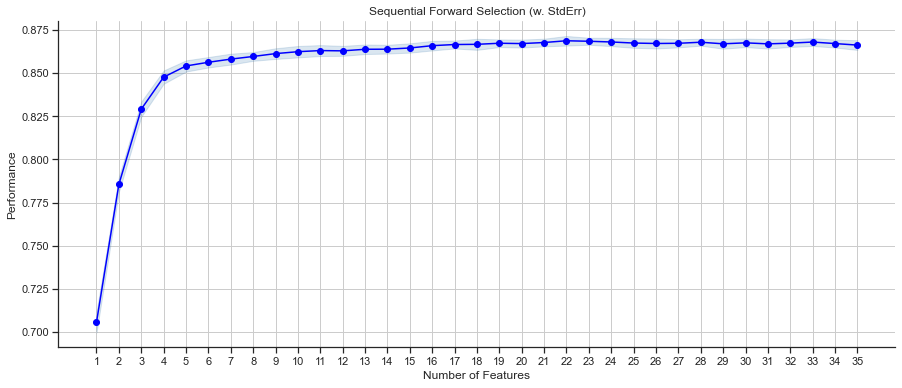

In [82]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [83]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [15]:
selected_columns_1 = ['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'age_group',
 'education',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults']

##### Seasonal Flu Vaccines

In [85]:
sfs2 = SFS(LGBMClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [86]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   12.8s finished

[2023-05-03 21:53:01] Features: 1/35 -- score: 0.7183493016257676[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   33.1s finished

[2023-05-03 21:53:35] Features: 2/35 -- score: 0.777958922881455[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   28.7s finished

[2023-05-03 21:54:04] Features: 3/35 -- score: 0.8115646781681323[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [87]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7268855078661294, 0.7157342536619893, 0.723...",0.718349,"(31,)",0.011885,0.009247,0.004623
2,"(0, 31)","[0.790595212744163, 0.7781306375644856, 0.7882...",0.777959,"(0, 31)",0.015209,0.011833,0.005917
3,"(0, 22, 31)","[0.8255655989783063, 0.8127822198948663, 0.812...",0.811565,"(0, 22, 31)",0.01195,0.009298,0.004649
4,"(0, 22, 30, 31)","[0.8481963390079346, 0.8297169960610777, 0.836...",0.833677,"(0, 22, 30, 31)",0.011068,0.008611,0.004306
5,"(0, 10, 22, 30, 31)","[0.8573933999650278, 0.8399443832234712, 0.843...",0.842552,"(0, 10, 22, 30, 31)",0.010733,0.008351,0.004175
6,"(0, 10, 22, 30, 31, 32)","[0.8603367422491458, 0.8453788874918359, 0.848...",0.847457,"(0, 10, 22, 30, 31, 32)",0.009641,0.007501,0.003751
7,"(0, 10, 22, 25, 30, 31, 32)","[0.8608189073348533, 0.8472423228420086, 0.852...",0.849648,"(0, 10, 22, 25, 30, 31, 32)",0.009036,0.00703,0.003515
8,"(0, 10, 22, 25, 26, 30, 31, 32)","[0.862515430148389, 0.8496718523868028, 0.8555...",0.851649,"(0, 10, 22, 25, 26, 30, 31, 32)",0.010213,0.007946,0.003973
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.8652052822902006, 0.8500247441426875, 0.858...",0.853378,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.010729,0.008347,0.004174
10,"(0, 10, 13, 22, 25, 26, 27, 30, 31, 32)","[0.8654362656241973, 0.8518712038600863, 0.859...",0.854666,"(0, 10, 13, 22, 25, 26, 27, 30, 31, 32)",0.01042,0.008107,0.004053


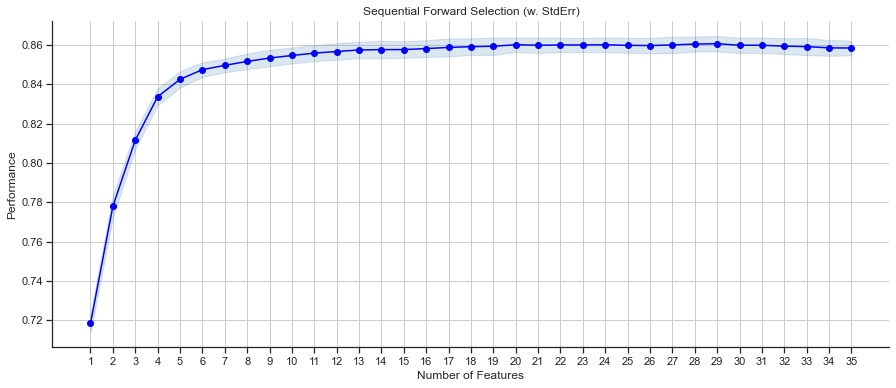

In [88]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [89]:
sfdf2['avg_score'] = sfdf2['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()
selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [16]:
selected_columns_2 = ['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_industry',
 'employment_occupation']

#### Model Optimization

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [45]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [51]:
def objective(trial):
    param = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = lgb.LGBMClassifier(**param)  
    model.fit(ct1.fit_transform(X_train[selected_columns_1]), y_train.h1n1_vaccine)
    
    preds = model.predict(ct1.fit_transform(X_test[selected_columns_1]))
    
    return roc_auc_score(y_test.h1n1_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [100]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7912389839968053
  Params: 
    reg_alpha=0.01936878421476343,
    reg_lambda=1.4998893098207997,
    colsample_bytree=0.7,
    subsample=0.7,
    learning_rate=0.006,
    max_depth=100,
    num_leaves=7,
    min_child_samples=171,
    min_data_per_groups=20,


##### Seasonal Flu Vaccines

In [101]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_2].select_dtypes('object').columns
col = []
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [102]:
def objective2(trial):
    param = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = LGBMClassifier(**param)  
    
    model.fit(ct2.fit_transform(X_train[selected_columns_2]), y_train.seasonal_vaccine, eval_set=[(ct2.fit_transform(X_test[selected_columns_2]), y_test.seasonal_vaccine)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(ct2.fit_transform(X_test[selected_columns_2]))
    
    return roc_auc_score(y_test.seasonal_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

In [104]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7912389839968053
  Params: 
    reg_alpha=0.08383858523911697,
    reg_lambda=0.012326453465371623,
    colsample_bytree=1.0,
    subsample=0.8,
    learning_rate=0.017,
    max_depth=20,
    num_leaves=868,
    min_child_samples=253,
    min_data_per_groups=93,


#### Model Optimization (using all features)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [60]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [71]:
def objective(trial):
    param = {
        "metric": 'auc',
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = lgb.LGBMClassifier(**param)  
    model.fit(ct1.fit_transform(X_train), y_train.h1n1_vaccine)
    
    preds = model.predict(ct1.fit_transform(X_test))
    
    return roc_auc_score(y_test.h1n1_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [73]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7443320898007015
  Params: 
    lambda_l1=0.00011245837595618146,
    lambda_l2=0.07441878376171743,
    num_leaves=31,
    feature_fraction=0.9743616454898388,
    bagging_fraction=0.4902389581804133,
    bagging_freq=3,
    min_child_samples=18,


##### Seasonal Flu Vaccines

In [64]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
col = []
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [68]:
def objective2(trial):
    param = {
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = lgb.LGBMClassifier(**param)  
    model.fit(ct1.fit_transform(X_train), y_train.seasonal_vaccine)
    
    preds = model.predict(ct1.fit_transform(X_test))
    
    return roc_auc_score(y_test.seasonal_vaccine, preds)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

In [70]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7443320898007015
  Params: 
    lambda_l1=0.00020474362632378208,
    lambda_l2=1.8442097517533176e-06,
    num_leaves=17,
    feature_fraction=0.5253233106677825,
    bagging_fraction=0.9118567900538517,
    bagging_freq=3,
    min_child_samples=29,


#### Final Model

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [116]:
model_h1n1 = lgb.LGBMClassifier(**trial.params)
model_flu = lgb.LGBMClassifier(**trial2.params)

In [117]:
model_h1n1.fit(ct1.fit_transform(X_train[selected_columns_1]), y_train.h1n1_vaccine)
model_flu.fit(ct2.fit_transform(X_train[selected_columns_2]), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct1.fit_transform(X_test[selected_columns_1]))
pred_flu = model_flu.predict_proba(ct2.fit_transform(X_test[selected_columns_2]))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [118]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [119]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.8052582172879232

#### Final Model (using all features)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [75]:
model_h1n1 = lgb.LGBMClassifier(**trial.params)
model_flu = lgb.LGBMClassifier(**trial2.params)

In [76]:
model_h1n1.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
model_flu.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct.fit_transform(X_test))
pred_flu = model_flu.predict_proba(ct.fit_transform(X_test))

[LightGBM] [Warning] feature_fraction is set=0.9743616454898388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743616454898388
[LightGBM] [Warning] lambda_l1 is set=0.00011245837595618146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011245837595618146
[LightGBM] [Warning] bagging_fraction is set=0.4902389581804133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4902389581804133
[LightGBM] [Warning] lambda_l2 is set=0.07441878376171743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07441878376171743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [77]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [78]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.834950661119624

#### For Submission

In [120]:
f_model_h1n1 = LGBMClassifier(**trial.params)
f_model_flu = LGBMClassifier(**trial2.params)

f_model_h1n1.fit(ct1.fit_transform(df_features[selected_columns_1]), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct1.fit_transform(df_test_features[selected_columns_1]))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct2.fit_transform(df_features[selected_columns_2]), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct2.fit_transform(df_test_features[selected_columns_2]))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


#### For Submission (using all features)

In [79]:
f_model_h1n1 = LGBMClassifier(**trial.params)
f_model_flu = LGBMClassifier(**trial2.params)

f_model_h1n1.fit(ct1.fit_transform(df_features), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct1.fit_transform(df_test_features))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct2.fit_transform(df_features), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct2.fit_transform(df_test_features))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

[LightGBM] [Warning] feature_fraction is set=0.9743616454898388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743616454898388
[LightGBM] [Warning] lambda_l1 is set=0.00011245837595618146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011245837595618146
[LightGBM] [Warning] bagging_fraction is set=0.4902389581804133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4902389581804133
[LightGBM] [Warning] lambda_l2 is set=0.07441878376171743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07441878376171743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5253233106677825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5253233106677825
[LightGBM] [Warning] lambda_l1 is set=0.00020474362632378208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020474362632378208
[LightGBM] [Warning

### Random Forest

#### Model Optimization (using all features)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [113]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns
ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

##### h1n1 Vaccines

In [120]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
    }

    model = RandomForestClassifier(random_state=5, **params)
    model.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
    preds = model.predict(ct.fit_transform(X_test))
    
    return roc_auc_score(y_test.h1n1_vaccine, preds)

In [121]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2023-05-04 17:11:34,125] A new study created in memory with name: no-name-6486f129-3593-4c49-8e0a-0707f155436b
[I 2023-05-04 17:11:39,147] Trial 0 finished with value: 0.6586549759884378 and parameters: {'n_estimators': 261, 'max_depth': 44, 'min_samples_split': 32, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.6586549759884378.
[I 2023-05-04 17:11:48,480] Trial 1 finished with value: 0.6658349811856412 and parameters: {'n_estimators': 514, 'max_depth': 32, 'min_samples_split': 116, 'min_samples_leaf': 32}. Best is trial 1 with value: 0.6658349811856412.
[I 2023-05-04 17:11:53,377] Trial 2 finished with value: 0.6671374352413054 and parameters: {'n_estimators': 332, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 45}. Best is trial 2 with value: 0.6671374352413054.
[I 2023-05-04 17:12:02,411] Trial 3 finished with value: 0.6681264712194194 and parameters: {'n_estimators': 469, 'max_depth': 11, 'min_samples_split': 133, 'min_samples_leaf': 18}. Best is trial 3 

In [122]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6995849471033381
  Params: 
    n_estimators=592,
    max_depth=43,
    min_samples_split=5,
    min_samples_leaf=2,


##### Seasonal Flu Vaccines

In [123]:
def objective2(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
    }

    model = RandomForestClassifier(random_state=5, **params)
    model.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)
    preds = model.predict(ct.fit_transform(X_test))
    
    return roc_auc_score(y_test.seasonal_vaccine, preds)

In [124]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

[I 2023-05-04 17:28:42,254] A new study created in memory with name: no-name-bd68b148-3f6d-4058-bb56-8ffccf47981b
[I 2023-05-04 17:28:46,079] Trial 0 finished with value: 0.7557832898172324 and parameters: {'n_estimators': 261, 'max_depth': 44, 'min_samples_split': 32, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.7557832898172324.
[I 2023-05-04 17:28:52,961] Trial 1 finished with value: 0.7602982622709159 and parameters: {'n_estimators': 514, 'max_depth': 32, 'min_samples_split': 116, 'min_samples_leaf': 32}. Best is trial 1 with value: 0.7602982622709159.
[I 2023-05-04 17:28:57,604] Trial 2 finished with value: 0.7583090871612927 and parameters: {'n_estimators': 332, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 45}. Best is trial 1 with value: 0.7602982622709159.
[I 2023-05-04 17:29:03,942] Trial 3 finished with value: 0.7596764713230977 and parameters: {'n_estimators': 469, 'max_depth': 11, 'min_samples_split': 133, 'min_samples_leaf': 18}. Best is trial 1 

In [125]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6995849471033381
  Params: 
    n_estimators=779,
    max_depth=28,
    min_samples_split=8,
    min_samples_leaf=6,


#### Final Model (using all features)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [127]:
model_h1n1 = RandomForestClassifier(**trial.params)
model_flu = RandomForestClassifier(**trial2.params)

In [128]:
model_h1n1.fit(ct.fit_transform(X_train), y_train.h1n1_vaccine)
model_flu.fit(ct.fit_transform(X_train), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct.fit_transform(X_test))
pred_flu = model_flu.predict_proba(ct.fit_transform(X_test))

In [129]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [ ]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6995849471033381
  Params: 
    n_estimators=779,
    max_depth=28,
    min_samples_split=8,
    min_samples_leaf=6,


#### For Submission (using all features)

In [136]:
f_model_h1n1 = RandomForestClassifier(**trial.params)
f_model_flu = RandomForestClassifier(**trial2.params)

f_model_h1n1.fit(ct.fit_transform(df_features), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct.fit_transform(df_test_features))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct.fit_transform(df_features), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct.fit_transform(df_test_features))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

## Submission

In [131]:
submission_df = pd.read_csv("data/submission_format.csv", 
                            index_col="respondent_id")

submission_df["h1n1_vaccine"] = predictions_h1n1
submission_df["seasonal_vaccine"] = predictions_flu

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.301486,0.429222
26708,0.021775,0.048482
26709,0.234853,0.262383
26710,0.610471,0.868520
26711,0.706608,0.662369


In [132]:
submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.301486,0.429222
26708,0.021775,0.048482
26709,0.234853,0.262383
26710,0.610471,0.868520
26711,0.706608,0.662369
...,...,...
53410,0.230207,0.497787
53411,0.085142,0.264729
53412,0.234513,0.363737


In [133]:
name = "RF_all_features"
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'predictions/{date}submssion_{name}.csv', index=True)